In [1]:
import pandas as pd
import os
import sys
import csv
import numpy as np
import ast
from spacy.matcher import PhraseMatcher
from spacy import displacy
from sklearn.metrics import confusion_matrix

# Get the parent directory of the current directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the Python path
sys.path.append(parent_dir)
import myutils
from config import Config

/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
config = Config()
rubrics = myutils.load_rubrics('../' + config.PATH_RUBRIC)

# are long rubrics an issue?
lens = {}
for k,v in rubrics.items():
    lens[k] = len(v['key_element'].tolist())

sorted_lens = sorted(lens.items(), key=lambda x: x[1], reverse=True)
print(sorted_lens)

[('8.1_MM', 18), ('5.12', 16), ('2.4', 16), ('10.1_TC', 11), ('6.1_IPP', 10), ('10.2_TC', 7), ('10.3_TC', 7), ('5.7', 7), ('2.1_DLL_v1.1', 6), ('12.1_PE', 6), ('6.2_IPP', 6), ('6.3_IPP', 6), ('12.2_PE', 5), ('6.3', 5), ('1.6', 5), ('7', 4), ('1', 4), ('3', 4), ('4.1_LM_v1.0', 3), ('8.2_MM', 3), ('4.2_LM_v1.0', 3), ('6', 2), ('4', 2), ('4.3_LM', 2), ('8.3_MM', 2), ('4.13', 2), ('4.3', 2), ('2.3_DLL_v1.1', 2), ('2.2_DLL', 2), ('12.3_PE', 2), ('8', 2), ('5.11', 1)]


In [3]:
# how much similar spans do we predict?

duplicates = []
differences = []
lengths = []
# Open the CSV file and read its contents
with open('../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)

    # Iterate over each row in the CSV file
    for row in reader:
        # Extract the justification_cues column as a string
        justification_cues_str = row['justification_cues']
        
        # Convert the string representation of the list of tuples to an actual list
        justification_cues = eval(justification_cues_str)
        
        duplicates.append(len(justification_cues) != len(set(justification_cues)))
        differences.append(len(justification_cues) - len(set(justification_cues)))
        lengths.append(len(justification_cues))
print(len([d for d in duplicates if d==True]))
print(np.average(differences))
        

411
1.784829721362229


In [4]:
converters = {
    'justification_cues': ast.literal_eval,
    'scoring_vectors': ast.literal_eval,
    'justification_cue_spans': ast.literal_eval,
}

In [5]:
# calculate metrics without unseen questions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

german_ids = [str(i) for i in range(0,9)]

unseen_question_ids = ['2', '5', '1.2', '11.1_SDN', '11.2_SDN', '11.3_SDN', '11.4_SDN']

In [6]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_summation_token_classification_regression/final_prediction.csv',
             ] 

In [7]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(float(p['score']))
                y_pred_de.append(float(p['y_pred']))
            else:
                y_true_en.append(float(p['score']))
                y_pred_en.append(float(p['y_pred']))
    print(file_path.split('/')[2])
    print('DE', mean_squared_error(y_true_de, y_pred_de, squared=True))
    print('EN', mean_squared_error(y_true_en, y_pred_en, squared=True))
    y_true_de = [str(i) for i in y_true_de]
    y_pred_de = [str(i) for i in y_pred_de]
    y_true_en = [str(i) for i in y_true_en]
    y_pred_en = [str(i) for i in y_pred_en]
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))

grading_final_decision_tree_span_prediction_regression
DE 0.08902214022140222
EN 0.07320833333333333
DE QWK 0.5955458464631624
EN QWK 0.4212823236835116
grading_final_decision_tree_token_classification_regression
DE 0.16576337638376384
EN 0.093625
DE QWK 0.13877081542845704
EN QWK 0.2800901184919762
grading_final_summation_span_prediction_regression
DE 0.43219557195571956
EN 0.5784166666666667
DE QWK 0.07812420583344826
EN QWK 0.035800488911631234
grading_final_summation_token_classification_regression
DE 0.4481088560885609
EN 0.5874583333333333
DE QWK 0.05816434764099743
EN QWK 0.05894317036811114


In [8]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_classification/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_summation_token_classification_classification/final_prediction.csv',
             ] 

In [9]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(p['class'])
                y_pred_de.append(p['y_pred'])
            else:
                y_true_en.append(p['class'])
                y_pred_en.append(p['y_pred'])
    print(file_path.split('/')[2])
    print('DE', classification_report(y_true_de, y_pred_de, digits=3))
    print('EN', classification_report(y_true_en, y_pred_en, digits=3))
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))
    print(20*'-')

grading_final_decision_tree_span_prediction_classification
DE                  precision    recall  f1-score   support

        CORRECT      0.651     0.689     0.670       103
      INCORRECT      0.714     0.213     0.328        47
PARTIAL_CORRECT      0.649     0.793     0.714       121

       accuracy                          0.653       271
      macro avg      0.671     0.565     0.570       271
   weighted avg      0.661     0.653     0.630       271

EN                  precision    recall  f1-score   support

        CORRECT      0.827     0.758     0.791       240
      INCORRECT      0.294     0.238     0.263        21
PARTIAL_CORRECT      0.580     0.702     0.635       114

       accuracy                          0.712       375
      macro avg      0.567     0.566     0.563       375
   weighted avg      0.722     0.712     0.714       375

DE QWK 0.4682854195909948
EN QWK 0.4702357755261106
--------------------
grading_final_decision_tree_token_classification_classific

/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

grading_final_summation_span_prediction_classification
DE                  precision    recall  f1-score   support

        CORRECT      1.000     0.029     0.057       103
      INCORRECT      0.199     1.000     0.332        47
PARTIAL_CORRECT      0.312     0.083     0.131       121

       accuracy                          0.221       271
      macro avg      0.504     0.371     0.173       271
   weighted avg      0.554     0.221     0.137       271

EN                  precision    recall  f1-score   support

        CORRECT      0.744     0.121     0.208       240
      INCORRECT      0.075     0.762     0.137        21
PARTIAL_CORRECT      0.407     0.439     0.422       114

       accuracy                          0.253       375
      macro avg      0.408     0.440     0.256       375
   weighted avg      0.604     0.253     0.269       375

DE QWK -0.08564610600911138
EN QWK 0.10210185029906649
--------------------
grading_final_summation_token_classification_classification

In [10]:
file_path = '../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv'
predictions_span = pd.read_csv(file_path, converters=converters)
file_path = '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv'
predictions_token = pd.read_csv(file_path, converters=converters)

In [11]:
print('Generate more detailed insights per question...')
save_path = '../results/grading_final_decision_tree_span_prediction_regression'
reports = {}
cms = {}
for qid in list(rubrics.keys()):
    y_true = [str(d['score']) for i, d in predictions_span[predictions_span['question_id'] == str(qid)].iterrows()]
    y_pred = [str(d['y_pred']) for i, d in predictions_span[predictions_span['question_id'] == str(qid)].iterrows()]
    cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    reports[qid] = report
    cms[qid] = cm.tolist()


myutils.save_json(reports, save_path, 'final_reports.json')
myutils.save_json(cms, save_path, 'final_cms.json')

print(reports)

Generate more detailed insights per question...


/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

saved final_reports.json
saved final_cms.json
{'5.12': {'1.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}}, '6': {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '0.25': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '0.375': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '0.5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24}, '0.625': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '0.75': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '0.875': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '1.0': {'precision': 1.0, 'recall': 0.07142857142857142, 'f1-score': 0.13333333333333333, 'support': 14}, 'accuracy': 0.019230769230769232, 'macro avg': {'precisio

In [12]:
def display_ents(predictions):
    def on_match(matcher, doc, id, matches):
        ents = []
        for m in matches:
            start = m[0]
            end = m[1]
            ents.append({
                'label': 'CUE',
                'span_start': start,
                'span_end': end
            })
        return matches

    def merge_spans(spans):
        sorted_spans = sorted(spans, key=lambda x: x[1])
        merged_spans = []
        for span in sorted_spans:
            if not merged_spans:
                merged_spans.append(span)
            else:
                last_span = merged_spans[-1]
                if last_span[2] >= span[1]:
                    merged_span = (last_span[0], last_span[1], max(last_span[2], span[2]))
                    merged_spans[-1] = merged_span
                else:
                    merged_spans.append(span)
        return merged_spans

    for i, d in predictions.iterrows():
        text = config.nlp(d['text'])
        matcher = PhraseMatcher(config.nlp.vocab)
        spans = []
        for jus_cue in d['justification_cue_spans']:
            print(jus_cue)
            for j in jus_cue:
                if len(j):
                    span = config.nlp(j)
                    spans.append(span)
        matcher.add('CUE',spans, on_match=on_match)
        matches = matcher(text)
        print(matches)
        matches = merge_spans(matches)
        text.ents = matches
        print(d['question_id'])
        displacy.render(text, style="ent", options={'colors': {'CUE': '#F5F503'}})
        print('True score:', d['score'], 'Predicted score:', d['y_pred'])

In [13]:
#display_ents(predictions_token)

In [14]:
display_ents(predictions_span)

['Das alles gut zu', 'Das alles gut zu']
[(13999982436800569226, 0, 4)]
8


True score: 0.0 Predicted score: 0.125
['(z.B.Sauberkeit', 'Waren bei deinem Stationsbesuch Handschuhe oder Papierhandtücher (an der Zapfsäule) oder Handdesinfektionsmittel (am Shopeingang) verfügbar, sodass du deine Hände sauber halten konntest? Bist du mit der Warenpräsentation des Shops innen und außen zufrieden']
[(13999982436800569226, 47, 86), (13999982436800569226, 87, 90)]
8


True score: 1.0 Predicted score: 0.875
['Arbeitskleidung zulässig? Wurdest du von allen Mitarbeitern, die dich im Shop bedienten, begrüßt und verabschiedet? Es zählen auch non-verbale Gesten, wie z.B. winken oder nicken. Haben sich die Mitarbeiter im Shop, die dich bedienten, um eine persönlichere Begrüßung oder Verabschiedung bemüht (z.B. Blickkontakt, Lächeln)? Wie zufrieden warst du mit der Freundlichkeit und Gastfreundschaft der Mitarbeiter des Shops, die dich bedienten? (5 = sehr zufrieden bis 1 = sehr unzufrieden) Wie zufrieden warst du mit der Bedienung durch die Mitarbeiter? (5 = “Sehr zufrieden” und 1 = “Sehr unzufrieden”)', 'Arbeitskleidung zulässig? Wurdest du von allen Mitarbeitern, die dich im Shop bedienten, begrüßt und verabschiedet? Es zählen auch non-verbale Gesten, wie z.B. winken oder nicken. Haben sich die Mitarbeiter im Shop, die dich bedienten, um eine persönlichere Begrüßung oder Verabschiedung bemüht (z.B. Blickkontakt']
[(13999982436800569226, 0, 58), (13999982

True score: 0.0 Predicted score: 0.625
['Dann ob der Shop sauber ist und die Gänge nicht zugestellt sind', 'Ob die Regale gut gefüllt sind und das warenangebot gut sortiert ist']
[(13999982436800569226, 0, 12), (13999982436800569226, 13, 25)]
8


True score: 1.0 Predicted score: 0.875
['Gepflegter Außenbereich mit den dortigen Einrichtungen, Vorhandensein von Handschuhen, Papierhandtüchern oder Desinfektionsmittel sowie Warenpräsentation', 'Gepflegter Außenbereich mit den dortigen Einrichtungen, Vorhandensein von Handschuhen, Papierhandtüchern oder Desinfektionsmittel sowie Warenpräsentation']
[(13999982436800569226, 0, 16)]
8


True score: 0.0 Predicted score: 0.875
['im Hinblick auf Sauberkeit', 'Ich soll auf die Warenpräsentation achten, im Hinblick auf Sauberkeit, Ordnung, Preisauszeichnung aller Produkte und Lücken in den Waren Regalen']
[(13999982436800569226, 0, 24), (13999982436800569226, 7, 12)]
8


True score: 1.0 Predicted score: 0.875
['ALLES', 'ALLES']
[(13999982436800569226, 0, 1)]
8


True score: 0.0 Predicted score: 0.875
['Das Verhalten der Mitarbeiter', '']
[(13999982436800569226, 0, 4)]
8


True score: 0.0 Predicted score: 0.875
['auseneindruck', 'auseneindruck']
[(13999982436800569226, 0, 1)]
8


True score: 1.0 Predicted score: 0.875
['Sauberkeit und Preisauszeichnung) im Shop bewerten', '']
[(13999982436800569226, 39, 47)]
8


True score: 1.0 Predicted score: 0.875
['Das Erscheinungsbild soll Sauber', 'Das Erscheinungsbild soll Sauber, geplegt und ordentlich sein. Man soll einen guten Überblick über das Warenangebot haben']
[(13999982436800569226, 0, 4)]
8


True score: 1.0 Predicted score: 0.875
['Waren Präsentation innerhalb und außerhalb des Shops (Sauberkeit', 'Waren Präsentation innerhalb und außerhalb des Shops (Sauberkeit']
[(13999982436800569226, 0, 9)]
8


True score: 1.0 Predicted score: 0.875
['Shop', 'Shop']
[(13999982436800569226, 10, 11)]
8


True score: 0.5 Predicted score: 0.625
['Arbeitskleidung getragen', 'Arbeitskleidung getragen']
[(13999982436800569226, 0, 2)]
8


True score: 0.0 Predicted score: 0.625
['Warenpräsentation, innen und außen. Ist alles sauber', 'Warenpräsentation']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 9)]
8


True score: 1.0 Predicted score: 0.875
['Shop selbst', 'Shop selbst']
[(13999982436800569226, 0, 2)]
8


True score: 0.75 Predicted score: 0.625
['Ob dieser gepflegt und sauber isr', 'Ob dieser gepflegt und sauber isr']
[(13999982436800569226, 0, 6)]
8


True score: 1.0 Predicted score: 0.125
['Ich bewerte Sauberkeit', 'Preisauszeichnung an allen Produkten']
[(13999982436800569226, 0, 3), (13999982436800569226, 6, 10)]
8


True score: 1.0 Predicted score: 0.875
['- Überblick über die Sauberkeit und Zustand der Sanitäranlagen / Toiletten', '- Überblick über die Sauberkeit und Zustand der Sanitäranlagen / Toiletten. - Funktionsfähigkeit aller Anlagen - Sauberkeit der Sanitäreinrichtungen - ausreichend Verbrauchsmaterial - Arbeitskleidung und gut sichtbares Namensschild der Mitarbeiter -Begrüßung der Mitarbeiter - Zufriedenheit über Freundlichkeit und Gastfreundschaft der Mitarbeiter des Shops - Zufriedenheit über Bedienung durch die Mitarbeiter - Hinweis auf Möglichkeit des Kunden-Feedbacks - gepflegter Außenbereich? - Ausreichend Handschuhe oder Papierhandtücher oder Handdesinfektionsmittel verfügbar? - Warenpräsentation des Shops innen und außen']
[(13999982436800569226, 0, 11)]
8


True score: 1.0 Predicted score: 0.875
['Ob der Verkäufer freundlich ist (Gestik/minik),', '']
[(13999982436800569226, 0, 11)]
8


True score: 0.0 Predicted score: 0.625
['Er wirkt gepflegt/sauber', 'Er wirkt gepflegt/sauber/ordentlich']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 7)]
8


True score: 1.0 Predicted score: 0.625
['Sauberkeit', 'Auf die Möglichkeit, ein Kunden-Feedback zu hinterlassen, und auf die Warenpräsentation des Shops, Sauberkeit']
[(13999982436800569226, 0, 19), (13999982436800569226, 18, 19)]
8


True score: 1.0 Predicted score: 1.0
['allgemeine Sauberkeit', 'Bestückung mit Waren']
[(13999982436800569226, 0, 2), (13999982436800569226, 3, 6)]
8


True score: 1.0 Predicted score: 0.875
['Das es sauber und ordentlich ist', 'Das es sauber und ordentlich ist']
[(13999982436800569226, 0, 6)]
8


True score: 1.0 Predicted score: 0.875
['Auf die Sauberkeit und die Freundlichkeit der Mitarbeiter', 'Auf die Sauberkeit und die Freundlichkeit der Mitarbeiter']
[(13999982436800569226, 0, 8)]
8


True score: 0.5 Predicted score: 0.875
['Siehe Jobbeschreibung', 'Siehe Jobbeschreibung']
[(13999982436800569226, 0, 2)]
8


True score: 0.0 Predicted score: 0.125
['Ist die Fläche Sauber und die Produkte in Ordnung', 'Sind alle Preisschilder angebracjt']
[(13999982436800569226, 0, 4), (13999982436800569226, 12, 21)]
8


True score: 1.0 Predicted score: 0.875
['Normaler Kunde aussehen und verhalten', 'Normaler Kunde aussehen']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 5)]
8


True score: 0.0 Predicted score: 0.625
['Sauberkeit des Shops', 'Sauberkeit des Shops']
[(13999982436800569226, 0, 3)]
8


True score: 1.0 Predicted score: 0.875
['Warenpräsentation', 'Warenpräsentation']
[(13999982436800569226, 0, 1)]
8


True score: 0.5 Predicted score: 0.875
['Sauberkeit', 'Sortimentauswahl']
[(13999982436800569226, 4, 5), (13999982436800569226, 6, 7)]
8


True score: 1.0 Predicted score: 1.0
['Sauberkeit', 'Sauberkeit']
[(13999982436800569226, 0, 1)]
8


True score: 1.0 Predicted score: 1.0
['Das allgemeine Gesamterscheinungsbild sowie zusätzlich ob z.b. Papiertücher und Handschuhe an den Zapfsäulen vorhanden sind', 'Das allgemeine Gesamterscheinungsbild sowie zusätzlich ob z.b. Papiertücher und Handschuhe an den Zapfsäulen vorhanden sind']
[(13999982436800569226, 0, 16)]
8


True score: 0.0 Predicted score: 0.625
['ob man gut behandelt wird und ob es ordentlich ist', 'ob']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 10), (13999982436800569226, 6, 7)]
8


True score: 0.25 Predicted score: 0.625
['Ordnung und vollständigkeit des Shops und der Tankstelle im allgemeinen', 'Ordnung und vollständigkeit des Shops und der Tankstelle im allgemeinen']
[(13999982436800569226, 0, 11)]
8


True score: 1.0 Predicted score: 0.625
['sauber ', 'Auf ausreichend Möglichkeiten zur Handreinigung/ Desinfektion an der Zapfsäule und im Eingangsbereich, darauf, daß bzw. ob alle Auslagen ']
[(13999982436800569226, 0, 22), (13999982436800569226, 36, 37)]
8


True score: 1.0 Predicted score: 0.875
['Vermittelte dir der Außenbereich mit den dortigen Einrichtungen (z.B. Luftprüfer', 'Vermittelte dir der Außenbereich mit den dortigen Einrichtungen (z.B. Luftprüfer, Staubsauger) insgesamt den Eindruck, dass alles gepflegt und sicher war? (5 = "Stimme voll und ganz zu", 1 = “Stimme überhaupt nicht zu”)']
[(13999982436800569226, 0, 12), (13999982436800569226, 0, 46)]
8


True score: 0.0 Predicted score: 0.625
['Aufgeräumt, übersichtlich sauber', 'Aufgeräumt']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 4)]
8


True score: 1.0 Predicted score: 0.875
['Sauberkeit', 'Übersicht']
[(13999982436800569226, 0, 1), (13999982436800569226, 4, 5)]
8


True score: 1.0 Predicted score: 1.0
['Foto von außen machen', 'Foto von außen machen']
[(13999982436800569226, 0, 4)]
4


True score: 1.0 Predicted score: 1.0
['Ich mache ein Foto von außen und schreibe etwas dazu in die Beschreibung', 'Foto von außen']
[(13999982436800569226, 0, 13), (13999982436800569226, 3, 6)]
4


True score: 1.0 Predicted score: 1.0
['versuche zu vermitteln das dringend in die Toiletten muss', 'versuche zu vermitteln das dringend in die Toiletten muss']
[(13999982436800569226, 1, 10)]
4


True score: 0.0 Predicted score: 0.75
['Vermerke in der ', 'Vermerke in der ']
[(13999982436800569226, 0, 3)]
4


True score: 1.0 Predicted score: 0.75
['Ich mache Bilder von außen', 'mache Bilder von ']
[(13999982436800569226, 0, 5), (13999982436800569226, 1, 4)]
4


True score: 0.5 Predicted score: 1.0
['keine Möglichkeit besteht dies angeben', 'fragen ']
[(13999982436800569226, 3, 8)]
4


True score: 0.0 Predicted score: 0.75
['Fotos', 'mache']
[(13999982436800569226, 0, 1), (13999982436800569226, 1, 2)]
4


True score: 1.0 Predicted score: 0.75
['Foto', 'Foto der WC Tür an und eines eventuell vorhandenen ']
[(13999982436800569226, 3, 4), (13999982436800569226, 3, 12)]
4


True score: 1.0 Predicted score: 0.75
['fotografiere die Außentür und vermerke den Fall in der Aufgabe', 'fotografiere die']
[(13999982436800569226, 1, 3), (13999982436800569226, 1, 11)]
4


True score: 1.0 Predicted score: 1.0
['frage', 'frage']
[(13999982436800569226, 1, 2)]
4


True score: 0.0 Predicted score: 0.25
['außen', 'vermerke es in der']
[(13999982436800569226, 1, 5), (13999982436800569226, 11, 12)]
4


True score: 1.0 Predicted score: 1.0
['Sanitäranlagen von außen fotografieren', 'Sanitäranlagen von außen']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 4)]
4


True score: 1.0 Predicted score: 1.0
['Dann lasse', '']
[(13999982436800569226, 0, 2)]
4


True score: 0.0 Predicted score: 0.75
['außen fotografieren und vermerken', 'Wenn mir die Mitarbeiter kein Schlüssel dafür geben können oder wollen oder sie Toiletten gesperrt oder nicht benutzbar sind']
[(13999982436800569226, 0, 19), (13999982436800569226, 25, 29)]
4


True score: 1.0 Predicted score: 1.0
['Ich mache ein Foto der Toilette von außen und Vermerke in Fragebogen dass die Toiletten gesperrt waren', 'Fragebogen dass die Toiletten gesperrt waren']
[(13999982436800569226, 0, 17), (13999982436800569226, 11, 17)]
4


True score: 1.0 Predicted score: 1.0
['außen', 'außen']
[(13999982436800569226, 3, 4)]
4


True score: 1.0 Predicted score: 1.0
['außen gemacht werden und entsprechend vermerkt werden', 'Es sollten in diesem Fall Bilder der Toilette von außen gemacht werden und entsprechend vermerkt werden']
[(13999982436800569226, 0, 16), (13999982436800569226, 9, 16)]
4


True score: 1.0 Predicted score: 1.0
['außen machen', 'soll die Bilder der Toilettentür von außen machen']
[(13999982436800569226, 1, 9), (13999982436800569226, 7, 9)]
4


True score: 0.5 Predicted score: 1.0
['Fotos von außen machen und im Job vermerken das die Anlagen gesperrt sind', 'Fotos von außen machen und im Job vermerken das die Anlagen gesperrt sind']
[(13999982436800569226, 0, 14)]
4


True score: 1.0 Predicted score: 1.0
['außen', 'außen']
[(13999982436800569226, 1, 2)]
4


True score: 1.0 Predicted score: 1.0
['außen fotografieren', '']
[(13999982436800569226, 1, 3)]
4


True score: 1.0 Predicted score: 1.0
['Fotos', 'Fotos dokumentieren und schriftlich festhalten']
[(13999982436800569226, 1, 2), (13999982436800569226, 1, 6)]
4


True score: 1.0 Predicted score: 0.75
['gehst du in die Tankstelle', 'frag']
[(13999982436800569226, 1, 6)]
4


True score: 0.0 Predicted score: 0.75
['Foto', 'Foto']
[(13999982436800569226, 1, 2)]
4


True score: 1.0 Predicted score: 0.75
['fragen', 'fragen']
[(13999982436800569226, 4, 5)]
4


True score: 0.0 Predicted score: 0.25
['Foto und vermerke es bei der entsprechenden Aufgabe', 'Belege dies durch Foto und vermerke es bei der entsprechenden Aufgabe']
[(13999982436800569226, 0, 11), (13999982436800569226, 3, 11)]
4


True score: 1.0 Predicted score: 0.75
['Hier muss ich Fotos von außen machen', 'Fotos von ']
[(13999982436800569226, 0, 7), (13999982436800569226, 3, 5)]
4


True score: 1.0 Predicted score: 1.0
['foto', 'foto von aussen machen']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 4)]
4


True score: 1.0 Predicted score: 1.0
['sanitären Anlagen leider nicht bewerten', 'ich die sanitären Anlagen ']
[(13999982436800569226, 2, 6), (13999982436800569226, 4, 9)]
4


True score: 0.0 Predicted score: 1.0
['außen', 'frage']
[(13999982436800569226, 1, 2), (13999982436800569226, 15, 16)]
4


True score: 1.0 Predicted score: 1.0
['außen', 'außen bzw. vom gesperrten Bereich und weise in der App darauf hin']
[(13999982436800569226, 4, 5), (13999982436800569226, 4, 17)]
4


True score: 1.0 Predicted score: 1.0
['Ich tätige ein Foto von außen', 'tätige ein Foto von außen']
[(13999982436800569226, 0, 6), (13999982436800569226, 1, 6)]
4


True score: 1.0 Predicted score: 1.0
['Ich mache von außen ein Bild von der Toilette', '']
[(13999982436800569226, 0, 9)]
4


True score: 1.0 Predicted score: 1.0
['Fertige ein Foto von außen an', 'Fertige ein Foto von ']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 6)]
4


True score: 1.0 Predicted score: 1.0
['außen', 'fotografiere die Toilette von außen']
[(13999982436800569226, 1, 6), (13999982436800569226, 5, 6)]
4


True score: 1.0 Predicted score: 1.0
['dass die Sanitäranlagen gesperrt oder geschlossen waren', 'Fotos von Außen und vermerke']
[(13999982436800569226, 2, 7), (13999982436800569226, 8, 15)]
4


True score: 1.0 Predicted score: 1.0
['Fotos', 'Fotos von der Toilette']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 4)]
4


True score: 1.0 Predicted score: 1.0
['Foto von außen anfertigen und in der app vermerken', 'Foto von außen anfertigen und in der app vermerken']
[(13999982436800569226, 0, 9)]
4


True score: 1.0 Predicted score: 1.0
['außen', '']
[(13999982436800569226, 6, 7)]
4


True score: 1.0 Predicted score: 1.0
['Nachfragen nach einer Alternativen Toilette', 'Nachfragen']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 5)]
4


True score: 0.0 Predicted score: 1.0
['Verschlossene Tür von außen fotografieren', 'Zustand']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 7)]
4


True score: 1.0 Predicted score: 1.0
['Kraftstoff und mindestens ein Artikel aus dem Shop', 'Kraftstoff und mindestens ein Artikel aus dem Shop', '', 'Kraftstoff und mindestens ein Artikel aus dem Shop. Bis 16,50 wird via AppJobber erstattet, alles weitere muss man selbst zahlen']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 22)]
7


True score: 1.0 Predicted score: 0.5
['tanken und Einkauf im Shop', 'tanken und Einkauf im Shop', 'Shop', 'tanken und Einkauf im Shop']
[(13999982436800569226, 0, 6), (13999982436800569226, 5, 6)]
7


True score: 1.0 Predicted score: 0.75
['Tanken plus einen Artikel Meiner Wahl - maximal 16,50h', 'Tanken plus einen Artikel Meiner Wahl - maximal 16,50h', '16,50', 'Tanken plus einen Artikel Meiner Wahl - maximal 16,50h']
[(13999982436800569226, 0, 9)]
7


True score: 0.5 Predicted score: 0.875
['Treibstoff und ShopArtike', 'Treibstoff und ShopArtike', 'ShopArtike', 'Bezahlen tut AppJobber - die rechnen mit ihrem Auftraggeber ab']
[(13999982436800569226, 0, 3), (13999982436800569226, 2, 3), (13999982436800569226, 4, 14)]
7


True score: 0.5 Predicted score: 0.375
['Tanken und ein Shopartikel', 'Tanken und ein Shopartikel', '16,50€ werden die Kosten von AppJobber getragen', 'bis 16,50€ werden die Kosten von AppJobber getragen']
[(13999982436800569226, 0, 4), (13999982436800569226, 5, 14), (13999982436800569226, 6, 14)]
7


True score: 1.0 Predicted score: 1.0
['tanken und einen Artikel aus dem Shop', 'tanken und einen Artikel aus dem Shop', '', 'bezahlen muss ich selbst']
[(13999982436800569226, 0, 7), (13999982436800569226, 8, 12)]
7


True score: 1.0 Predicted score: 0.75
['Ich muss tanken und im Shop einkaufen', 'Ich muss tanken und im Shop einkaufen', 'Shop', 'Ich muss tanken und im Shop']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 8), (13999982436800569226, 6, 7)]
7


True score: 0.75 Predicted score: 0.75
['Tanken und Shopeinkauf', 'Tanken und Shopeinkauf', '16,50', 'Tanken und Shopeinkauf']
[(13999982436800569226, 0, 3), (13999982436800569226, 7, 8)]
7


True score: 0.75 Predicted score: 1.0
['Kraftstoff und ein Produkt meiner Wahl aus dem Shop', 'Kraftstoff und ein Produkt meiner Wahl aus dem Shop', '16.50', 'Kraftstoff und ein Produkt meiner Wahl aus dem Shop. Maximal sind 16.50 EUR erstattbar']
[(13999982436800569226, 0, 9), (13999982436800569226, 0, 15), (13999982436800569226, 12, 13)]
7


True score: 1.0 Predicted score: 1.0
['Kraftstoff und min 1 Artikel vom Shop', 'Kraftstoff und min 1 Artikel vom Shop', 'Shop', 'Kraftstoff und min 1 Artikel vom Shop']
[(13999982436800569226, 0, 7), (13999982436800569226, 6, 7)]
7


True score: 0.5 Predicted score: 0.25
['Tanken und Einkauf im Shop', 'Tanken und Einkauf im Shop', 'Shop', 'Tanken und Einkauf im Shop']
[(13999982436800569226, 0, 6), (13999982436800569226, 5, 6)]
7


True score: 1.0 Predicted score: 0.625
['Tanken und im Shop', 'Tanken und im Shop', 'Shop', 'Tanken und im Shop']
[(13999982436800569226, 0, 5), (13999982436800569226, 4, 5)]
7


True score: 0.5 Predicted score: 0.25
['tanken und einen Artikel kaufen und bezahlen', 'tanken und einen Artikel kaufen und bezahlen', '16 50', '16 50 werden erstattet']
[(13999982436800569226, 0, 7), (13999982436800569226, 8, 10), (13999982436800569226, 8, 12)]
7


True score: 1.0 Predicted score: 0.75
['Ich muss tanken (maximal 16,50 Euro erstattet) und einen Artikel meiner Wahl kaufen', 'Ich muss tanken (maximal 16,50 Euro erstattet) und einen Artikel meiner Wahl kaufen', '16,50', 'Ich muss tanken (maximal 16,50 Euro erstattet) und einen Artikel meiner Wahl kaufen']
[(13999982436800569226, 0, 15), (13999982436800569226, 5, 6)]
7


True score: 1.0 Predicted score: 1.0
['Sprit und ein Item', 'Sprit und ein Item', '16,50', 'Sprit und ein Item. Bis 16,50 Euro werden übernommen']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 10), (13999982436800569226, 6, 7)]
7


True score: 1.0 Predicted score: 1.0
['Tanken und Ware im Laden', 'Tanken und Ware im Laden', 'Laden', 'Tanken und Ware im Laden']
[(13999982436800569226, 0, 6), (13999982436800569226, 5, 6)]
7


True score: 0.5 Predicted score: 0.625
['Kraftstoff UND Shopartikel', 'Kraftstoff UND Shopartikel', '16,50', 'Kraftstoff UND Shopartikel. Bis zu 16,50 Euro des tatsächlichen Warenwertes werden durch den Auftraggeber erstattet']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 16), (13999982436800569226, 6, 7)]
7


True score: 1.0 Predicted score: 1.0
['tanken und Einkauf im Shop', 'tanken und Einkauf im Shop', '', '']
[(13999982436800569226, 0, 6)]
7


True score: 1.0 Predicted score: 0.75
['Tanken plus Einkauf im Shop', 'Tanken plus Einkauf im Shop', 'Shop', 'Shop']
[(13999982436800569226, 0, 6), (13999982436800569226, 5, 6)]
7


True score: 1.0 Predicted score: 1.0
['Tanken sowie einen Kauf aus dem Tankstellensortiment', 'Tanken sowie einen Kauf aus dem Tankstellensortiment', 'Es wird nur der Maximalbetrag von 16,50€', 'Tanken sowie einen Kauf aus dem Tankstellensortiment. Es wird nur der Maximalbetrag von 16,50€ vergütet']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 17), (13999982436800569226, 8, 16)]
7


True score: 0.75 Predicted score: 1.0
['Ich muss tanken und ein Produkt im Shop kaufen und diese selbst bezahlen', 'Ich muss tanken und ein Produkt im Shop kaufen und diese selbst bezahlen', 'Kosten bis 16,50€', 'Ich muss tanken und ein Produkt im Shop kaufen und diese selbst bezahlen, die Kosten bis 16,50€ werden mir bei erfolgreiche Erledigung der Aufgaben erstattet']
[(13999982436800569226, 0, 14), (13999982436800569226, 0, 28), (13999982436800569226, 16, 20)]
7


True score: 1.0 Predicted score: 1.0
['Mann muss Kraftstoff tanken und dannnoch etwas in der Tankstelle kaufen die werden bis 16.50€ erstattet', 'Mann muss Kraftstoff tanken und dannnoch etwas in der Tankstelle kaufen die werden bis 16.50€ erstattet', '16.50€ erstattet', 'Mann muss Kraftstoff tanken und dannnoch etwas in der Tankstelle kaufen die werden bis 16.50€ erstattet']
[]
7


/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/spacy/displacy/__init__.py:211: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


True score: 1.0 Predicted score: 1.0
['Ich muss tanken + shopkauf', 'Ich muss tanken + shopkauf', 'shop', 'Ich muss tanken + shopkauf']
[(13999982436800569226, 0, 5)]
7


True score: 0.75 Predicted score: 0.625
['Ich muss tanken und einen Einkauf im Shop tätigen', 'Ich muss tanken und einen Einkauf im Shop tätigen', 'Der Preis muss mindestens 16,50€ betragen', 'Ich muss tanken und einen Einkauf im Shop tätigen. Der Preis muss mindestens 16,50€ betragen. Bis zu diesem Betrag werden die Kosten auch übernommen']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 28), (13999982436800569226, 11, 18)]
7


True score: 1.0 Predicted score: 1.0
['Ich muss Kraftstoff tanken und einen Artikel kaufen', 'Ich muss Kraftstoff tanken und einen Artikel kaufen', 'Ich muss Kraftstoff tanken und einen Artikel kaufen', 'Ich muss Kraftstoff tanken und einen Artikel kaufen']
[(13999982436800569226, 0, 8)]
7


True score: 0.25 Predicted score: 0.75
['Ich zahle die vorgegebenen Käufe und bekomme den Kaufpreis mit der Vergütung erstattet', 'Ich zahle die vorgegebenen Käufe und bekomme den Kaufpreis mit der Vergütung erstattet', 'zahle die vorgegebenen Käufe und bekomme den Kaufpreis mit der Vergütung ', 'Ich zahle die vorgegebenen Käufe und bekomme den Kaufpreis mit der Vergütung erstattet']
[(13999982436800569226, 0, 13), (13999982436800569226, 1, 12)]
7


True score: 0.5 Predicted score: 0.625
['Ich muss Kraftstoff und mindestens ein weiteren Produkt kaufen', 'Ich muss Kraftstoff und mindestens ein weiteren Produkt kaufen', 'Ich bekomme einen Betrag bis max. 16,50€', 'Ich muss Kraftstoff und mindestens ein weiteren Produkt kaufen. Ich bekomme einen Betrag bis max. 16,50€ zurückerstattet']
[(13999982436800569226, 0, 9), (13999982436800569226, 0, 20), (13999982436800569226, 10, 19)]
7


True score: 1.0 Predicted score: 1.0
['tanken und etwas aus dem Shop', 'tanken und etwas aus dem Shop', '16,50', 'Geld bekomme ich erstattet']
[(13999982436800569226, 4, 10), (13999982436800569226, 12, 13), (13999982436800569226, 15, 19)]
7


True score: 1.0 Predicted score: 1.0
['bezahle die', 'Ich bezahle die Käufe', '', 'Ich bezahle die Käufe']
[(13999982436800569226, 0, 4), (13999982436800569226, 1, 3)]
7


True score: 0.0 Predicted score: 0.0
['kraftstoff und einen Artikel aus dem Shop bis 16.50 Euro werden diese erstattet', 'kraftstoff und einen Artikel aus dem Shop bis 16.50 Euro werden diese erstattet', '', 'kraftstoff und einen Artikel aus dem Shop bis 16.50 Euro werden diese erstattet']
[(13999982436800569226, 0, 13)]
7


True score: 1.0 Predicted score: 1.0
['Tanken und ein anderes Objekt und dies wird mir gutgeschrieben', 'Tanken und ein anderes Objekt und dies wird mir gutgeschrieben', '16,50 ', 'Tanken und ein anderes Objekt und dies wird mir gutgeschrieben, wenn ich nicht über 16,50 bezahle, aber ich muss es vorstrecken']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 23), (13999982436800569226, 15, 16)]
7


True score: 0.75 Predicted score: 1.0
['Tanken und ein Produkt meiner Wahl', 'Tanken und ein Produkt meiner Wahl', 'Tanken und ein Produkt meiner Wahl', 'Die Käufe bezahle ich']
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 11)]
7


True score: 0.5 Predicted score: 1.0
['Tanken & einen Kauf im Shop', 'Tanken & einen Kauf im Shop', 'Shop', 'Shop']
[(13999982436800569226, 0, 7), (13999982436800569226, 6, 7)]
7


True score: 0.75 Predicted score: 0.75
['Die gefragt sind', 'Die gefragt sind Und ich muss diese bezahlen', 'gefragt sind Und', 'Die gefragt sind Und ich muss diese bezahlen']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 8), (13999982436800569226, 1, 4)]
7


True score: 0.0 Predicted score: 0.375
['Benzinkauf und z. B. Feuerzeug', 'Benzinkauf und z. B. Feuerzeug', 'Benzinkauf und z. B. Feuerzeug', 'Benzinkauf und z. B. Feuerzeug. Bezahlung durch mich']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 9)]
7


True score: 0.5 Predicted score: 0.625
['Ich darf einen Gegenstand meiner Wahl kaufen', 'Ich darf einen Gegenstand meiner Wahl kaufen', 'übersteigt Dieser zusammen mit dem Kraftstoff nicht 16,50€ wird mir dieser Beitrag erstattet', 'Ich darf einen Gegenstand meiner Wahl kaufen']
[(13999982436800569226, 0, 7), (13999982436800569226, 14, 28)]
7


True score: 0.75 Predicted score: 0.625
['Kraftstoff', 'Kraftstoff und etwas aus dem Shop', '', 'Kraftstoff und etwas aus dem Shop']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 6)]
7


True score: 0.75 Predicted score: 0.75
['tanken und ein Produkt aus dem Shop', 'tanken und ein Produkt aus dem Shop', '', 'tanken und ein Produkt aus dem Shop.. bis 16,50 zahlt app jobber']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 13)]
7


True score: 0.75 Predicted score: 1.0
['Kraftstoff und ein Kauf im Shop', 'Kraftstoff und ein Kauf im Shop', 'Shop', 'Kraftstoff und ein Kauf im Shop']
[(13999982436800569226, 0, 7), (13999982436800569226, 6, 7)]
7


True score: 1.0 Predicted score: 0.75
['Tanken UND EINKAUFEN', 'Tanken UND EINKAUFEN', 'Ich bezahle sie und bekomme bis zum genannten Betrag in der Beschreibung ', 'Tanken UND EINKAUFEN. Ich bezahle sie und bekomme bis zum genannten Betrag in der Beschreibung erstattet']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 17), (13999982436800569226, 4, 16)]
7


True score: 0.75 Predicted score: 0.625
['Tank', 'Tank und 1Artikel', 'Tank und 1Artikel bis max. 16,50€', 'Tank und 1Artikel bis max. 16,50€ werden übernommen']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 3), (13999982436800569226, 0, 8), (13999982436800569226, 0, 10)]
7


True score: 1.0 Predicted score: 1.0
['jeder Tageszeit', 'Shops']
[(13999982436800569226, 1, 3), (13999982436800569226, 9, 10)]
6


True score: 1.0 Predicted score: 0.625
['24 Stunden am Tag', 'Tag,']
[(13999982436800569226, 0, 4), (13999982436800569226, 3, 5)]
6


True score: 0.5 Predicted score: 0.625
['24 Std darf ich ihn ausfuehren', '24 Std darf ich ihn ausfuehren']
[(13999982436800569226, 0, 6)]
6


True score: 0.0 Predicted score: 0.625
['den Öffnungszeiten der', 'den Öffnungszeiten der']
[(13999982436800569226, 1, 4)]
6


True score: 0.5 Predicted score: 0.625
['', 'den']
[(13999982436800569226, 1, 2)]
6


True score: 0.5 Predicted score: 0.375
['Shops', 'Shops']
[(13999982436800569226, 4, 5)]
6


True score: 1.0 Predicted score: 0.625
['keine Rolle', 'Shops']
[(13999982436800569226, 14, 15), (13999982436800569226, 19, 21)]
6


True score: 1.0 Predicted score: 0.625
['Die Tageszeit spielt keine Rolle', 'so lange der Shop geöffnet ist']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 12)]
6


True score: 1.0 Predicted score: 1.0
['keine Rolle', 'Immer wenn der Tankstellenshop geöffnet hat']
[(13999982436800569226, 0, 6), (13999982436800569226, 9, 11)]
6


True score: 1.0 Predicted score: 0.875
['', 'Shops achten']
[(13999982436800569226, 16, 18)]
6


True score: 1.0 Predicted score: 0.625
['Öffnungszeiten', 'Öffnungszeiten der']
[(13999982436800569226, 1, 2), (13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['den regulären Öffnungszeiten', '']
[(13999982436800569226, 1, 4)]
6


True score: 0.5 Predicted score: 0.625
['den Öffnungszeiten und es muss so hell sein', ',dass']
[(13999982436800569226, 1, 9), (13999982436800569226, 9, 11)]
6


True score: 1.0 Predicted score: 0.625
['jeder Tageszeit', 'Zu jeder Tageszeit solange der Shop geöffnet hat']
[(13999982436800569226, 0, 8), (13999982436800569226, 1, 3)]
6


True score: 1.0 Predicted score: 0.625
['Tankstelle', ',']
[(13999982436800569226, 2, 3), (13999982436800569226, 3, 4)]
6


True score: 0.5 Predicted score: 0.375
['jeder Tageszeit', 'jeder Tageszeit']
[(13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['jeder Öffnungszeit', 'jeder Öffnungszeit']
[(13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['öffnungszeiten', '']
[(13999982436800569226, 2, 3)]
6


True score: 0.5 Predicted score: 0.625
['', '']
[]
6


True score: 0.0 Predicted score: 0.375
['keine rolle', '']
[(13999982436800569226, 3, 5)]
6


True score: 0.5 Predicted score: 0.625
['Während den Öffnungszeiten der', 'Während den Öffnungszeiten der Tankstelle']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 5)]
6


True score: 0.75 Predicted score: 0.625
['keine', 'Tageszeit ']
[(13999982436800569226, 0, 1), (13999982436800569226, 2, 3)]
6


True score: 0.75 Predicted score: 0.625
['Grundlegend ist der Job ganztägig machbar', 'Grundlegend ist der Job ganztägig machbar']
[(13999982436800569226, 0, 6)]
6


True score: 1.0 Predicted score: 0.875
['keine Rolle', 'Tageslicht spielt keine Rolle']
[(13999982436800569226, 0, 4), (13999982436800569226, 2, 4)]
6


True score: 0.5 Predicted score: 0.625
['der', '']
[(13999982436800569226, 1, 2)]
6


True score: 0.0 Predicted score: 0.375
['Von 8 Uhr bis 20 Uhr', '']
[(13999982436800569226, 0, 6)]
6


True score: 0.0 Predicted score: 0.375
['Tageslicht ist nicht', '']
[(13999982436800569226, 5, 8)]
6


True score: 0.5 Predicted score: 0.625
['Während der', 'Während']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 2)]
6


True score: 0.5 Predicted score: 0.625
['', 'während']
[(13999982436800569226, 0, 1)]
6


True score: 0.5 Predicted score: 0.375
['Jederzeit', ', ']
[(13999982436800569226, 0, 1), (13999982436800569226, 1, 2)]
6


True score: 0.25 Predicted score: 0.375
[', ', ', ']
[(13999982436800569226, 1, 2)]
6


True score: 0.5 Predicted score: 0.375
['Shop', 'Shop']
[]
6


True score: 1.0 Predicted score: 0.375
['den Öffnungszeiten', 'den Öffnungszeiten']
[(13999982436800569226, 1, 3)]
6


True score: 0.25 Predicted score: 0.625
['jeder Tageszeit ', 'jeder Tageszeit ']
[(13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['Shops', 'Shops']
[(13999982436800569226, 4, 5)]
6


True score: 1.0 Predicted score: 0.625
['', ',']
[(13999982436800569226, 3, 4)]
6


True score: 0.75 Predicted score: 0.375
['keine ', 'Der Check ist an keine direkte Tageszeit gebunden,']
[(13999982436800569226, 0, 9), (13999982436800569226, 4, 5)]
6


True score: 0.5 Predicted score: 0.625
['keine Rolle', 'Shop']
[(13999982436800569226, 5, 6), (13999982436800569226, 15, 17)]
6


True score: 1.0 Predicted score: 0.625
['Immer während den', 'Immer während den']
[(13999982436800569226, 0, 3)]
6


True score: 0.5 Predicted score: 0.625
['12:30-13:30 eben halt', '12:30-13:30']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 5)]
6


True score: 0.0 Predicted score: 0.375
['jeder Tageszeit', 'jeder Tageszeit']
[(13999982436800569226, 5, 7)]
6


True score: 0.5 Predicted score: 0.625
['9', '']
[(13999982436800569226, 1, 2)]
6


True score: 0.0 Predicted score: 0.375
['Jederzeit', ', hauptsache während der Öffnungzeiten']
[(13999982436800569226, 0, 1), (13999982436800569226, 1, 6)]
6


True score: 0.5 Predicted score: 0.625
['Öffnungszeiten', 'Öffnungszeiten Tankstelle']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 2)]
6


True score: 0.5 Predicted score: 0.625
['Jeden Tag während der Öffnungszeiten der jeweiligen Tankstelle', 'Jeden Tag ']
[(13999982436800569226, 0, 2), (13999982436800569226, 0, 8)]
6


True score: 0.25 Predicted score: 0.625
['besten wenn es noch', 'besten wenn es noch']
[(13999982436800569226, 1, 5)]
6


True score: 0.0 Predicted score: 0.625
['', 'Shops']
[(13999982436800569226, 6, 7)]
6


True score: 1.0 Predicted score: 0.625
['', '']
[]
6


True score: 0.5 Predicted score: 0.375
['den Öffnungszeiten', '']
[(13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['8', '8 und 17 Uhr']
[(13999982436800569226, 1, 2), (13999982436800569226, 1, 5)]
6


True score: 0.0 Predicted score: 0.375
['jeder Tageszeit ausgeführt werden. Hauptsache der Shop ist auf', 'Hauptsache der Shop ist auf']
[(13999982436800569226, 4, 14), (13999982436800569226, 9, 14)]
6


True score: 1.0 Predicted score: 0.625
['jeder Tageszeit', 'jeder Tageszeit']
[(13999982436800569226, 1, 3)]
6


True score: 0.5 Predicted score: 0.625
['Ich verhalte mich wie ein normaler Kunde', 'verhalte', 'verhalte mich wie ein normaler Kunde', 'Ich verhalte mich wie ein normaler Kunde']
[(13999982436800569226, 0, 7), (13999982436800569226, 1, 2), (13999982436800569226, 1, 7)]
3


True score: 0.0 Predicted score: 0.375
['', 'was der Verkäufer anhat', '', '']
[(13999982436800569226, 14, 18)]
3


True score: 1.0 Predicted score: 0.25
['Passende Arbeitskleidung', 'Passende Arbeitskleidung', 'Passende Arbeitskleidung', 'Passende Arbeitskleidung']
[(13999982436800569226, 0, 2)]
3


True score: 0.0 Predicted score: 0.375
['immer Frôhlich sein und dabei bleiben', 'immer Frôhlich sein und dabei bleiben', 'immer Frôhlich sein und dabei bleiben', 'immer Frôhlich sein']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 6)]
3


True score: 0.0 Predicted score: 0.125
['Begrüßung', 'Uniform', 'Uniform', 'Uniform']
[(13999982436800569226, 0, 1), (13999982436800569226, 4, 5)]
3


True score: 1.0 Predicted score: 0.625
['ganz normaler Kunde verhalten', 'Ich soll mich wie ein ganz normaler Kunde verhalten', 'soll mich wie ein ganz normaler Kunde verhalten', 'soll mich wie ein ganz normaler Kunde verhalten']
[(13999982436800569226, 0, 9), (13999982436800569226, 1, 9), (13999982436800569226, 5, 9)]
3


True score: 0.0 Predicted score: 0.0
['Ob die Mitarbeiter alle die richtige Kleidung tragen', 'Ob die Mitarbeiter alle die richtige Kleidung tragen', 'die Mitarbeiter alle die richtige Kleidung tragen', 'Shell Card gefragt haben und ob sie freundlich in der Gesprächsführung waren']
[(13999982436800569226, 0, 8), (13999982436800569226, 1, 8), (13999982436800569226, 11, 23)]
3


True score: 0.5 Predicted score: 0.125
['zusätzliche Angebote unterbreitet, nach der Shell Clubkarte fragt, Shell Kleidung trägt', '', 'zusätzliche Angebote unterbreitet', 'nach der Shell Clubkarte fragt']
[(13999982436800569226, 6, 9), (13999982436800569226, 6, 19), (13999982436800569226, 10, 15)]
3


True score: 0.75 Predicted score: 0.375
['Begrüssung und Verabschiedung freundlich', 'Begrüssung und Verabschiedung freundlich', 'Mitarbeiter Arbeitskleidung', 'Mitarbeiter Arbeitskleidung']
[(13999982436800569226, 0, 2), (13999982436800569226, 9, 13)]
3


True score: 0.5 Predicted score: 0.875
['Eventuelle persönliche Begrüßung', 'Eventuelle persönliche Begrüßung', 'Zusätzliche angebote unterbreitet', 'Befragung nach der clubkarte oder app']
[(13999982436800569226, 0, 3), (13999982436800569226, 14, 17), (13999982436800569226, 27, 33)]
3


True score: 0.75 Predicted score: 0.625
['ob er sich freundlich verhält also mich begrüßt und verabschiedet', 'verabschiedet', 'ob er nach Club Smart fragt', 'ob er nach Club Smart fragt']
[(13999982436800569226, 11, 17), (13999982436800569226, 18, 28), (13999982436800569226, 27, 28)]
3


True score: 1.0 Predicted score: 0.625
['Ich soll mich wie ein normaler Kunde ', 'Ich soll mich wie ein normaler Kunde verhalten', 'soll mich wie ein normaler Kunde verhalten', 'Ich soll']
[(13999982436800569226, 0, 2), (13999982436800569226, 0, 7), (13999982436800569226, 0, 8), (13999982436800569226, 1, 8)]
3


True score: 0.0 Predicted score: 0.0
['begrüßt mich der Mitarbeiter', 'Höflich bleiben', 'macht er mir ein zusätzliches angebot', 'fragt er nach der shell kundenkarte']
[(13999982436800569226, 0, 2), (13999982436800569226, 3, 7), (13999982436800569226, 21, 27), (13999982436800569226, 28, 34)]
3


True score: 1.0 Predicted score: 0.875
['haben gegrüßt oder mich durch ihr Verhalten angeregt mich zu verabschieden etc', 'gegrüßt oder mich durch ihr Verhalten angeregt mich zu verabschieden etc', 'und haben Mitarbeiter nur mir noch zusätzliche Angebote unterbreitet', 'Wurde ich nach der Shell ClubSmartKarte gefragt']
[(13999982436800569226, 13, 25), (13999982436800569226, 14, 25), (13999982436800569226, 26, 33), (13999982436800569226, 34, 43)]
3


True score: 1.0 Predicted score: 0.875
['Begrüßung', 'Begrüßung', 'Begrüßung', 'Begrüßung']
[(13999982436800569226, 0, 1)]
3


True score: 0.75 Predicted score: 0.625
['sie freundlich und bemüht sind und was sie für Arbeitskleidung tragen', 'Ob sie ', 'sie freundlich und bemüht sind und was sie für Arbeitskleidung tragen', 'sie freundlich und bemüht sind und was sie für Arbeitskleidung tragen']
[(13999982436800569226, 0, 2), (13999982436800569226, 1, 12)]
3


True score: 0.25 Predicted score: 0.375
['persönliche Begrüßung und Verabschiedung', 'persönliche Begrüßung und Verabschiedung', 'zusätzliche Angebote', 'Arbeitskleidung mit Namensschild']
[(13999982436800569226, 0, 3), (13999982436800569226, 4, 8), (13999982436800569226, 9, 11)]
3


True score: 1.0 Predicted score: 0.625
['Ob der Mitarbeiter Arbeitskleidung trägt', 'Ob der Mitarbeiter Arbeitskleidung trägt und wie freundlich er sich verhält', 'Ob der Mitarbeiter Arbeitskleidung trägt und wie freundlich er sich verhält', 'Ob der Mitarbeiter Arbeitskleidung trägt und wie freundlich er sich verhält']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 11)]
3


True score: 0.5 Predicted score: 0.0
['Freundlichkeit und Arbeitskleidung', 'Freundlichkeit und Arbeitskleidung', 'Freundlichkeit und Arbeitskleidung', 'und ob ich nach der Karte gefragt werde']
[(13999982436800569226, 0, 3), (13999982436800569226, 4, 12)]
3


True score: 0.25 Predicted score: 0.375
['ob der Mitarbeiter mich begrüßt uns verabschiedet und ob der Mitarbeiter freundlich ist', 'Zudem achte ich darauf', 'Zudem achte ich darauf', 'Ich achte darauf, ob der Mitarbeiter Arbeitskleidung und ein Namensschild trägt. Zudem achte ich darauf, ob der Mitarbeiter mich begrüßt uns verabschiedet und ob der Mitarbeiter ']
[(13999982436800569226, 0, 29), (13999982436800569226, 13, 17), (13999982436800569226, 18, 31)]
3


True score: 0.5 Predicted score: 0.0
['', 'Höflichkeit und respektvolles Verhalten', 'Höflichkeit', 'Höflichkeit']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 4)]
3


True score: 0.0 Predicted score: 0.125
['', 'Freundlichkeit', 'Hinweise auf Angebote', 'ShellClub Smartcard auf Anfrage']
[(13999982436800569226, 0, 1), (13999982436800569226, 2, 6), (13999982436800569226, 11, 14)]
3


True score: 0.75 Predicted score: 0.625
['Ob ich begrüßt wurde', '', 'ob der Mitarbeiter mir ein persönliches Angebot unterbreitet und ob er mich nach einem Kundenfeedback fragt', 'ob ich nach meiner Club Karte gefragt wurde']
[(13999982436800569226, 0, 4), (13999982436800569226, 10, 18), (13999982436800569226, 19, 35)]
3


True score: 0.75 Predicted score: 0.875
['stets freundlich sein und den Anweisungen folgen', 'stets freundlich sein und den Anweisungen folgen', 'stets freundlich sein', 'stets freundlich sein']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 7)]
3


True score: 0.0 Predicted score: 0.0
['Freundlichkeit', 'Freundlichkeit', 'Freundlichkeit', 'Freundlichkeit']
[(13999982436800569226, 0, 1)]
3


True score: 0.5 Predicted score: 0.25
['Namensschild', 'Namensschild', 'Zusatzangebot', 'Namensschild']
[(13999982436800569226, 0, 1), (13999982436800569226, 7, 8)]
3


True score: 0.75 Predicted score: 1.0
['traegt', 'Namensschild traegt', 'Namensschild traegt', 'Ob er ein Namensschild traegt']
[(13999982436800569226, 0, 5), (13999982436800569226, 3, 5), (13999982436800569226, 4, 5)]
3


True score: 0.0 Predicted score: 0.375
['ich verhalte mich ', 'ich verhalte mich stets freundlich und halte mich an die', 'ich verhalte mich stets freundlich und halte mich an die Anweisungen des Personals', 'ich verhalte mich stets freundlich und halte']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 7)]
3


True score: 0.0 Predicted score: 0.0
['Freundlichkeit', 'Verabschieudng', 'Freundlichkeit', 'Freundlichkeit']
[(13999982436800569226, 0, 1), (13999982436800569226, 5, 6)]
3


True score: 0.5 Predicted score: 0.25
['Freundlichkeit Begrüßung und Verabschiedung Namensschilder und Berufsbekleidung Wurde nach der Shell App oder der Club Karte gefragt Schnelle Bedienung Zusätzliche Angebote', 'Freundlichkeit Begrüßung und Verabschiedung Namensschilder und Berufsbekleidung Wurde nach der Shell App oder der Club Karte gefragt Schnelle Bedienung Zusätzliche Angebote', 'Freundlichkeit Begrüßung und Verabschiedung Namensschilder und Berufsbekleidung Wurde nach der Shell App oder der Club Karte gefragt Schnelle Bedienung Zusätzliche Angebote', 'Freundlichkeit Begrüßung und Verabschiedung Namensschilder und Berufsbekleidung Wurde nach der Shell App oder der Club Karte gefragt Schnelle Bedienung Zusätzliche Angebote']
[(13999982436800569226, 0, 21)]
3


True score: 1.0 Predicted score: 0.75
['Darauf achten ob ich auf sonstige Angebote hingewiesen werde', 'Darauf achten ob ich auf sonstige Angebote hingewiesen werde', 'Darauf achten ob ich auf sonstige Angebote hingewiesen werde', 'Darauf achten ob ich nach der Shell Smartcard gefragt werde']
[(13999982436800569226, 0, 10), (13999982436800569226, 22, 31)]
3


True score: 0.5 Predicted score: 0.25
['Er soll nicht anmerken', 'soll nicht', 'Er soll nicht anmerken', 'soll nicht anmerken']
[(13999982436800569226, 0, 4), (13999982436800569226, 1, 3), (13999982436800569226, 1, 4)]
3


True score: 0.0 Predicted score: 0.0
['Ob ich begrüßt werde', 'Und sich von mir verabschiedet', 'Ob ich begrüßt werde, der Mitarbeiter Arbeitskleidung trägt und freundlich ist', 'der']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 12), (13999982436800569226, 5, 6), (13999982436800569226, 13, 18)]
3


True score: 0.5 Predicted score: 0.5
['', 'Verhalten der Mitarbeiter', 'frage', 'frage nach Clubsmartkarte beachten und Berufskleidung']
[(13999982436800569226, 0, 3), (13999982436800569226, 5, 6), (13999982436800569226, 5, 11)]
3


True score: 0.5 Predicted score: 0.25
['Freundlichkeit', 'Freundlichkeit und hilfsbereit', 'Freundlichkeit und hilfsbereit', 'Freundlichkeit und hilfsbereit']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 3)]
3


True score: 0.0 Predicted score: 0.25
['Deutlich', 'Deutlich und Respekt sagen', 'Deutlich', 'Deutlich und Respekt sagen']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 4)]
3


True score: 0.0 Predicted score: 0.75
['Begrüßung', 'Verabschiedung', 'erlaubte Berufsmode', 'erlaubte Berufsmode']
[(13999982436800569226, 0, 2), (13999982436800569226, 5, 6), (13999982436800569226, 7, 8)]
3


True score: 0.5 Predicted score: 0.625
['Freundlichkeit', 'Freundlichkeit', 'Freundlichkeit', 'Freundlichkeit']
[(13999982436800569226, 0, 1)]
3


True score: 0.0 Predicted score: 0.25
['Ich achte besonders auf die Kleidung und die Höflichkeit der Personen,', 'Ich achte besonders auf die Kleidung und die Höflichkeit der Personen', 'fragen nach einer Shell Club Smart Karte', 'fragen nach einer Shell Club Smart Karte']
[(13999982436800569226, 0, 11), (13999982436800569226, 0, 12), (13999982436800569226, 19, 26)]
3


True score: 0.25 Predicted score: 0.25
['Begrüßung und Verabschiedung', 'Begrüßung und Verabschiedung', 'Blickkontakt', 'Blickkontakt']
[(13999982436800569226, 0, 1), (13999982436800569226, 10, 13)]
3


True score: 0.5 Predicted score: 0.625
['Freundlich sein und nicht u erkennen geben', 'Freundlich sein und nicht u erkennen geben', 'Freundlich sein und nicht u erkennen geben', 'Freundlich sein und nicht u erkennen geben']
[(13999982436800569226, 0, 7)]
3


True score: 0.0 Predicted score: 0.0
['Sollte ich mich zu erkennen geben müssen werde ich den Auftrag mit Zustimmung des Mitarbeiters Erledigen', 'Sollte ich mich zu erkennen geben müssen werde ich den Auftrag mit Zustimmung des Mitarbeiters Erledigen', 'Sollte ich mich zu erkennen geben müssen werde ich den Auftrag mit Zustimmung des Mitarbeiters Erledigen', 'ich mich zu erkennen geben müssen werde ich den Auftrag mit Zustimmung des Mitarbeiters Erledigen']
[(13999982436800569226, 25, 41), (13999982436800569226, 26, 41)]
3


True score: 0.0 Predicted score: 0.0
['Auf Kleidung', 'Auf Kleidung', 'Auf Kleidung', 'Auf Kleidung']
[(13999982436800569226, 0, 2)]
3


True score: 0.25 Predicted score: 0.0
['Club smart Karte nicht', 'Club smart Karte nicht von selbst vorzeigen ansonsten normal höflich', 'Club smart Karte nicht von selbst vorzeigen ansonsten normal höflich', 'Club smart Karte']
[(13999982436800569226, 1, 4), (13999982436800569226, 1, 5), (13999982436800569226, 1, 11)]
3


True score: 0.25 Predicted score: 0.25
['Begrüßung und Verabschiedung', 'Begrüßung und Verabschiedung', 'Ob man mich nach der ClubKarte fragt', 'Ob man mich nach der ClubKarte fragt']
[(13999982436800569226, 0, 7), (13999982436800569226, 23, 26)]
3


True score: 1.0 Predicted score: 0.875
['Begrüßung und Verabschiedung', 'Begrüßung und Verabschiedung', '', 'Auf Freundlichkeit']
[(13999982436800569226, 0, 2), (13999982436800569226, 3, 6)]
3


True score: 0.5 Predicted score: 0.625
['dass mich der Mitarbeiter freundlich begrüßt und allgemein freundlich ist und mich auch nach meiner Clubsmartkarte fragt', 'Hält er Blickkontakt und verabschiedet mich freundlich und bedankt sich für den Einkauf', 'Macht er ein Zusatzangebot', 'dass mich der Mitarbeiter freundlich begrüßt und allgemein freundlich ist und mich auch nach meiner Clubsmartkarte fragt']
[(13999982436800569226, 11, 28), (13999982436800569226, 29, 33), (13999982436800569226, 34, 47)]
3


True score: 1.0 Predicted score: 0.375
['undercouver bleiben', 'undercouver bleiben', 'undercouver bleiben', 'undercouver bleiben']
[(13999982436800569226, 0, 2)]
3


True score: 0.0 Predicted score: 0.0
['Ich soll auf eine persönliche Begrüßung u. Verabschiedung', 'Ich soll auf eine persönliche Begrüßung u. Verabschiedung', 'Dabei ist speziell auf die Frage nach der Kundenkarte und das Angebot eines Zusatzverkaufes sowie den Hinweis auf die Möglichkeit', 'Dabei ist speziell auf die Frage nach der Kundenkarte und das Angebot eines Zusatzverkaufes sowie den Hinweis auf die Möglichkeit']
[(13999982436800569226, 0, 8), (13999982436800569226, 20, 40)]
3


True score: 1.0 Predicted score: 0.75
['', 'fragt', 'fragt', 'fragt']
[(13999982436800569226, 8, 9)]
3


True score: 0.25 Predicted score: 0.0
['Begrüßung und verabschiedung', 'Begrüßung und verabschiedung', '', 'frage nach Clubsmartkarte']
[(13999982436800569226, 6, 9), (13999982436800569226, 10, 13)]
3


True score: 0.75 Predicted score: 0.625
['Freundlich sein und immer an die Anweisungen des Personals halten', 'Freundlich sein und immer an die Anweisungen des Personals halten. Kundenansprache, Arbeitskleidung', 'Freundlich sein und immer an die Anweisungen des Personals halten. Kundenansprache, Arbeitskleidung, Namensschild, Freundlichkeit des Mitarbeiters', 'Freundlich sein und immer an die Anweisungen des Personals halten. Kundenansprache, Arbeitskleidung, Namensschild, Freundlichkeit des Mitarbeiters']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 14), (13999982436800569226, 0, 20)]
3


True score: 0.25 Predicted score: 0.25
['Begrüßung/Verabschiedung', 'Ich achte auch die mögliche Dienstkleidung der Mitarbeiter*innen. Weiter auf Blickkontakt, Freundlichkeit, das unterbreiten von Zusatzangeboten( Kundenkarte, Produkte etc... ) Hinweis auf Kundenfeedback und auf Art und Weise der Begrüßung/Verabschiedung', 'das unterbreiten von Zusatzangeboten( Kundenkarte', 'das unterbreiten von Zusatzangeboten( Kundenkarte']
[(13999982436800569226, 0, 38), (13999982436800569226, 15, 21), (13999982436800569226, 35, 38)]
3


True score: 1.0 Predicted score: 1.0
['Ob die MA mich nach der Kundenkarte fragen und ob sie freundlich sind und sich für ggfls Wartezeiten entschuldigen', 'Ob die MA mich nach der Kundenkarte fragen und ob sie freundlich sind und sich für ggfls Wartezeiten entschuldigen', 'Ob die MA mich nach der Kundenkarte fragen und ob sie freundlich sind und sich für ggfls Wartezeiten entschuldigen. Auch soll ich auf die Kleidung achten und ob ein zusätzliches Angebot angepreist wird', 'Ob die MA mich nach der Kundenkarte fragen und ob sie freundlich sind und sich für ggfls Wartezeiten entschuldigen']
[(13999982436800569226, 0, 19), (13999982436800569226, 0, 34)]
3


True score: 0.5 Predicted score: 0.25
['Ich gebe mich zu erkennen und zeige das Informationsschreiben vor', 'Ich gebe mich zu erkennen und zeige das Informationsschreiben vor', 'gebe mich', 'Ich gebe mich zu erkennen und zeige das Informationsschreiben vor']
[(13999982436800569226, 0, 10), (13999982436800569226, 1, 3)]
1


True score: 0.5 Predicted score: 0.5
['ich zeige das Informationsschreiben', 'ich zeige das Informationsschreiben', 'ich zeige das', 'ich zeige das Informationsschreiben']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 4)]
1


True score: 0.25 Predicted score: 0.25
['Ich gebe mich zu erkennen und zeige das Informationsschreiben vor. Mit Erlaubnis des Mitarbeiters mache ich den Job zu Ende. Ich vermerke, dass ich erkannt wurde', 'Ich gebe mich zu erkennen und zeige das Informationsschreiben vor', 'dass ich erkannt wurde', 'Mit Erlaubnis des Mitarbeiters mache ich den Job zu Ende']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 29), (13999982436800569226, 11, 21), (13999982436800569226, 25, 29)]
1


True score: 1.0 Predicted score: 0.875
['zeige das', 'zeige das Informationsschreiben', 'zeige', 'zeige das Informationsschreiben']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 2), (13999982436800569226, 0, 3)]
1


True score: 0.25 Predicted score: 0.5
['Freundlich und versuche meine gegenüber', 'Freundlich und versuche meine gegenüber es zu erklären was ich mach', '', 'Freundlich und versuche meine gegenüber es zu erklären was ich mach']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 11)]
1


True score: 0.25 Predicted score: 0.5
['Zu erkennen geben und Info schreiben vorzeigen', 'Zu erkennen geben und Info schreiben vorzeigen', 'erkennen geben und Info schreiben', 'Zu erkennen geben und Info schreiben']
[(13999982436800569226, 0, 6), (13999982436800569226, 0, 7), (13999982436800569226, 1, 6)]
1


True score: 0.5 Predicted score: 0.625
['Zu erkennen geben und Infoschreiben vorlegen', 'Zu erkennen geben und Infoschreiben vorlegen', 'Infoschreiben vorlegen', 'erkennen geben und Infoschreiben vorlegen']
[(13999982436800569226, 0, 6), (13999982436800569226, 1, 6), (13999982436800569226, 4, 6)]
1


True score: 0.5 Predicted score: 0.625
['zeige das infornationsschreiben', 'Ich zeige das infornationsschreiben und bin freundlich', 'zeige das infornationsschreiben und bin ', 'Ich zeige das infornationsschreiben und bin ']
[(13999982436800569226, 0, 6), (13999982436800569226, 0, 7), (13999982436800569226, 1, 4), (13999982436800569226, 1, 6)]
1


True score: 0.25 Predicted score: 0.25
['zeige das Informationsschreiben vor und bitte darum den Auftrag zu Ende führen zu dürfen', 'zeige das Informationsschreiben vor und bitte darum den Auftrag zu Ende führen zu dürfen', 'zeige das Informationsschreiben vor und bitte darum den Auftrag zu Ende ', 'zeige das Informationsschreiben vor und bitte darum den Auftrag zu Ende führen zu dürfen']
[(13999982436800569226, 4, 15), (13999982436800569226, 4, 18)]
1


True score: 0.75 Predicted score: 0.625
['zeige höflich das', 'zeige höflich das Legitimationsschreiben vor', 'zeige', 'zeige höflich das Legitimationsschreiben vor']
[(13999982436800569226, 1, 2), (13999982436800569226, 1, 4), (13999982436800569226, 1, 6)]
1


True score: 0.25 Predicted score: 0.5
['dass man erkannt wurde', 'Informationsschreiben vorzeigen', '', 'Informationsschreiben vorzeigen']
[(13999982436800569226, 0, 2), (13999982436800569226, 12, 16)]
1


True score: 1.0 Predicted score: 0.625
['Ich gebe mich zu erkennen', 'Zeige das Informationsschreiben vor und führe den Check zu ende', 'Zeige das Informationsschreiben vor und führe den Check zu ende', 'Zeige das Informationsschreiben vor und führe den Check zu ende']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 16)]
1


True score: 0.75 Predicted score: 0.625
['zeige das Schreiben was ich von euch bekommen habe vor', 'zeige das Schreiben was ich von euch bekommen habe vor', 'zeige das Schreiben was ich von euch bekommen habe vor', 'und zeige das Schreiben was ich von euch bekommen habe vor']
[(13999982436800569226, 8, 19), (13999982436800569226, 9, 19)]
1


True score: 0.5 Predicted score: 0.375
['Ich gebe mich zu erkennen und mache mit der Erlaubnis des Mitarbeiters weiter', 'Ich gebe mich zu erkennen und mache mit der Erlaubnis des Mitarbeiters weiter', 'gebe mich zu erkennen und mache', 'Ich gebe mich zu erkennen und mache mit der Erlaubnis des Mitarbeiters weiter']
[(13999982436800569226, 0, 13), (13999982436800569226, 1, 7)]
1


True score: 0.75 Predicted score: 0.875
['Ich gebe mich zu erkennen und lege das Informationsschreiben vor', 'Ich gebe mich zu erkennen und lege das Informationsschreiben vor', 'gebe mich zu erkennen und lege das Informationsschreiben vor', 'gebe mich zu erkennen und lege das Informationsschreiben vor']
[(13999982436800569226, 0, 10), (13999982436800569226, 1, 10)]
1


True score: 0.5 Predicted score: 0.625
['Ich gebe mich zu erkennen und zeige das Info-Schreiben vor', '', 'Einverständnis des Mitarbeiters führe ich den Check durch - Vermerke das in der Aufgabe', 'Mit Einverständnis des Mitarbeiters führe ich den Check durch - Vermerke das in der Aufgabe']
[(13999982436800569226, 0, 12), (13999982436800569226, 13, 28), (13999982436800569226, 14, 28)]
1


True score: 1.0 Predicted score: 0.625
['zeige', 'Ich zeige das Informatiosschreiben vor', 'zeige das Informatiosschreiben vor', 'Ich zeige das']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 5), (13999982436800569226, 1, 2), (13999982436800569226, 1, 5)]
1


True score: 0.25 Predicted score: 0.25
['Ich gebe mich zu erkennen und lege ein informationsschreiben vor', 'Ich gebe mich zu erkennen und lege ein informationsschreiben vor', '', 'Ich gebe mich zu erkennen und lege ein informationsschreiben vor']
[(13999982436800569226, 0, 10)]
1


True score: 0.75 Predicted score: 0.625
['Zu erkennen geben und Legitimationsschreiben vorzeigen', 'Zu erkennen geben und Legitimationsschreiben vorzeigen', 'erkennen geben und Legitimationsschreiben vorzeigen', 'Zu erkennen geben und Legitimationsschreiben vorzeigen']
[(13999982436800569226, 0, 6), (13999982436800569226, 1, 6)]
1


True score: 0.5 Predicted score: 0.5
['Ich gebe mich zu erkennen und zeige das Informationsschreiben vor', 'Ich gebe mich zu erkennen und zeige das Informationsschreiben vor', 'zeige das Informationsschreiben vor', 'Ich gebe mich zu erkennen und zeige das Informationsschreiben vor']
[(13999982436800569226, 0, 10), (13999982436800569226, 6, 10)]
1


True score: 0.5 Predicted score: 0.5
['ich gebe mich zu erkennen und lege das Informationsschreiben vor', 'ich gebe mich zu erkennen und lege das Informationsschreiben vor', 'lege das Informationsschreiben', 'ich gebe mich zu erkennen und lege das Informationsschreiben vor']
[(13999982436800569226, 0, 10), (13999982436800569226, 6, 9)]
1


True score: 0.5 Predicted score: 0.625
['zeige mein Informationsschreiben', 'Ich zeige mein Informationsschreiben', 'zeige mein Informationsschreiben', 'Ich zeige mein Informationsschreiben']
[(13999982436800569226, 0, 4), (13999982436800569226, 1, 4)]
1


True score: 0.25 Predicted score: 0.5
['Ich gebe mich erst dann zu erkennen', 'wenn ich enttarnt wurde und zeige dann das von Euch in der Jobbeschreibung vorhandene Infoschreiben vor', 'Ich führe den Check mit Erlaubnis der Mitarbeiter zu Ende durch und vermerke es bei der der anschliessenden Dokumentation/ der Beantwortung der Fragen', 'Ich führe den Check mit Erlaubnis der Mitarbeiter zu Ende durch und vermerke es bei der der anschliessenden Dokumentation/ der Beantwortung der Fragen']
[(13999982436800569226, 0, 7)]
1


True score: 1.0 Predicted score: 0.75
['Ich gebe mich zu erkennen wenn nötig und zeige das Legimitationsschreiben vor das für mich in dem fall im Fragebogen hinterlegt wurde', 'Ich gebe mich zu erkennen wenn nötig und zeige das Legimitationsschreiben vor das für mich in dem fall im Fragebogen hinterlegt wurde', 'fall im Fragebogen', 'gebe mich zu erkennen wenn nötig und zeige das Legimitationsschreiben vor das für mich in dem fall im Fragebogen hinterlegt wurde']
[(13999982436800569226, 0, 23), (13999982436800569226, 1, 23), (13999982436800569226, 17, 21)]
1


True score: 0.5 Predicted score: 0.625
['sehr gut für mich', 'Es ', '', 'Es ']
[(13999982436800569226, 0, 1), (13999982436800569226, 2, 6)]
1


True score: 0.0 Predicted score: 0.0
['Ich gebe mich zu erkennen und zeige ihm das jop schreiben', '', 'jop', 'Zusätzlich führe ich den jop zu Ende mit Erlaubniss des mitarbeitets']
[(13999982436800569226, 0, 11), (13999982436800569226, 9, 10), (13999982436800569226, 12, 23), (13999982436800569226, 16, 17)]
1


True score: 0.75 Predicted score: 0.5
['höflich und nett,', 'höflich und nett', 'höflich und nett, ich erkläre warum ich ', 'höflich und nett']
[(13999982436800569226, 0, 3), (13999982436800569226, 0, 4), (13999982436800569226, 0, 8)]
1


True score: 0.0 Predicted score: 0.0
['', 'zeige ich das Legitimationsschreiben', '', 'Wenn ich auf die Tätigkeit als ']
[(13999982436800569226, 0, 6), (13999982436800569226, 10, 14)]
1


True score: 0.25 Predicted score: 0.5
['Mitarbeiter das Informationsschreiben vor', 'Ich lege dem Mitarbeiter das Informationsschreiben vor', 'Ich lege dem Mitarbeiter das Informationsschreiben vor. Führe Die Tätigkeit mit Erlaubnis weiter aus', 'Führe Die Tätigkeit mit Erlaubnis weiter aus']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 15), (13999982436800569226, 3, 7), (13999982436800569226, 8, 15)]
1


True score: 0.25 Predicted score: 1.0
['Ich gebe mich dann zu erkennen', 'zeige das Erlaubnisformular und versuche mit Erlaubnis den test zu Ende zu führen', 'zeige das Erlaubnisformular und versuche mit Erlaubnis den test zu Ende zu führen', 'zeige das Erlaubnisformular und versuche mit Erlaubnis den test zu Ende zu führen']
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 20)]
1


True score: 0.75 Predicted score: 0.5
['Ich gebe mich zu erkennen und zeige das informationsschreiben', 'Ich gebe mich zu erkennen und zeige das informationsschreiben. Ich vermerke in der Aufgabe das ich erkannt wurde', 'Ich vermerke in der Aufgabe das ich erkannt wurde', 'Ich gebe mich zu erkennen und zeige das informationsschreiben. Ich vermerke in der Aufgabe das ich erkannt wurde']
[(13999982436800569226, 0, 9), (13999982436800569226, 0, 19), (13999982436800569226, 10, 19)]
1


True score: 0.75 Predicted score: 0.625
['Ich gebe mich bekannt und zeige', 'Ich gebe mich bekannt und zeige', 'Ich gebe mich bekannt und zeige, ', 'gebe mich bekannt und zeige']
[(13999982436800569226, 0, 6), (13999982436800569226, 0, 7), (13999982436800569226, 1, 6)]
1


True score: 0.5 Predicted score: 0.5
['Ich gebe noch zu erkennen und zeige das Infoschreiben vor', 'Ich gebe noch zu erkennen und zeige das Infoschreiben vor', 'zeige das Infoschreiben vor. Mit Erlaubnis des Shellmitarbeiters führe ich den Test zu Ende', 'Mit Erlaubnis des Shellmitarbeiters führe ich den Test zu Ende']
[(13999982436800569226, 0, 10), (13999982436800569226, 6, 21), (13999982436800569226, 11, 21)]
1


True score: 0.75 Predicted score: 1.0
['erkläre was ich tue und mache mit der Erlaubnis des Mitarbeiters weiter', 'erkläre was ich tue und mache mit der Erlaubnis des Mitarbeiters weiter', 'erkläre was', 'Ich erkläre was ich tue und mache mit der Erlaubnis des Mitarbeiters weiter']
[(13999982436800569226, 0, 13), (13999982436800569226, 1, 3), (13999982436800569226, 1, 13)]
1


True score: 0.5 Predicted score: 0.75
['zeige Erlaubnisschein vor und vermerke es als Kommentar', 'zeige Erlaubnisschein vor und vermerke es als Kommentar', 'zeige Erlaubnisschein vor und vermerke es als', 'zeige Erlaubnisschein vor und vermerke es als Kommentar']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 8)]
1


True score: 0.5 Predicted score: 0.25
['Ich gebe mich zu erkennen und vermerke es', 'gebe mich zu erkennen und vermerke es', 'gebe mich zu erkennen und vermerke es', 'Ich gebe mich zu erkennen und vermerke es']
[(13999982436800569226, 0, 8), (13999982436800569226, 1, 8)]
1


True score: 0.75 Predicted score: 0.5
['Ich gebe mich zu erkennen und bitte den Mitarbeiter höflich mit mir zusammen zu arbeiten', 'mir zusammen zu arbeiten', 'mir zusammen zu arbeiten', 'Ich gebe mich zu erkennen und bitte den Mitarbeiter höflich mit mir zusammen zu arbeiten']
[(13999982436800569226, 0, 15), (13999982436800569226, 11, 15)]
1


True score: 0.25 Predicted score: 0.5
['kann ich mich zu erkennen geben und ein Schreiben zum Job vorzeigen', 'kann ich mich zu erkennen geben und ein Schreiben zum Job vorzeigen', 'kann ich mich zu erkennen geben und ein Schreiben zum Job vorzeigen', 'kann ich mich zu erkennen geben und ein Schreiben zum Job vorzeigen']
[(13999982436800569226, 9, 21)]
1


True score: 0.5 Predicted score: 0.625
['Ich gebe mich zu erkennen', 'zeige Ihnen dieses Schreiben und frage obe Ich fortfahren darf', 'frage', 'zeige Ihnen dieses Schreiben und frage obe Ich fortfahren darf']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 16), (13999982436800569226, 11, 12)]
1


True score: 0.5 Predicted score: 0.5
['Ich gebe mich zu erkennen und zeige das Referenzschreiben', 'Ich gebe mich zu erkennen und zeige das Referenzschreiben', 'gebe mich zu', 'Ich gebe mich zu erkennen und zeige das']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 9), (13999982436800569226, 1, 4)]
1


True score: 0.5 Predicted score: 0.5
['ich gebe mich zu erkennen bzw gebe das Informationsschreiben von euch an das Personal', 'ich gebe mich zu erkennen bzw gebe das Informationsschreiben von euch an das Personal', 'euch an', 'ich gebe mich zu erkennen bzw gebe das Informationsschreiben von euch an das Personal']
[(13999982436800569226, 0, 14), (13999982436800569226, 10, 12)]
1


True score: 0.5 Predicted score: 0.625
['zeige dann das Schreiben und führe die Aufgaben mit der Staff Erlaubnis weiter aus', 'Ich zeige dann das Schreiben und führe die Aufgaben mit der Staff Erlaubnis weiter aus', 'zeige dann das Schreiben und führe die Aufgaben mit der Staff Erlaubnis weiter aus', 'Ich zeige dann das Schreiben und führe die Aufgaben mit der Staff Erlaubnis weiter aus']
[(13999982436800569226, 0, 15), (13999982436800569226, 1, 15)]
1


True score: 0.5 Predicted score: 0.625
['Ich gebe mich zu erkennen und zeige das Legitimationsschreiben', 'zeige das Legitimationsschreiben', 'zeige das Legitimationsschreiben,welches dem Job beigefügt ist vor. Evtl. mache ich die Checks mit Erlaubnis des Stationspersonals', 'Evtl. mache ich die Checks mit Erlaubnis des Stationspersonals']
[(13999982436800569226, 0, 9), (13999982436800569226, 6, 9), (13999982436800569226, 6, 27), (13999982436800569226, 17, 27)]
1


True score: 0.75 Predicted score: 0.875
['Zu erkennen geben', 'Anschreiben vorzeigen', '', 'Zu erkennen geben']
[(13999982436800569226, 0, 3), (13999982436800569226, 4, 6)]
1


True score: 0.5 Predicted score: 0.625
['Reverse Path Broadcast is based on RPF to suitable reduce of Overhead', 'The Reverse Path Forwarding guarantees that the Packet used the best route when this packet arrived at the IS entry port. Reverse Path Broadcast is based on RPF to suitable reduce of Overhead. RPF (for a packet arriving at an IS) -Has this packet arrived at the IS entry port over which the packets for this station/source are usually also sent? Yes: -Assumption: Packet used the BEST route until now -Action: resend over all edges (not including the incoming one) No: -Assumption: Packet did NOT use this route (it is NOT the best route) -Action: discard packet (most likely duplicate) RPB: -Has this packet arrived at the IS entry port over which the packets for this station/source are usually also sent? Yes: -Packet used the BEST route until now? -YES: select the edge at which the packets arrived and from which they are then rerouted to source S (in reversed direction) -NO: DO N

True score: 0.75 Predicted score: 0.875
['Reverse Path Forwarding: Used for ensuring loop-free forwarding of multicast packets in multicast routing and to help prevent IP address spoofing in unicast routing', 'Reverse Path Forwarding: Used for ensuring loop-free forwarding of multicast packets in multicast routing and to help prevent IP address spoofing in unicast routing', 'Reverse Path Broadcast: Used to check if the set of shortest paths to a node forms a tree that spans the network']
[(13999982436800569226, 0, 27), (13999982436800569226, 87, 110)]
8.2_MM


True score: 0.875 Predicted score: 0.875
['-prevent routing loops/ cycles in the network RPF: -each node has a route to every other node -each node only forwards a broadcast packet received from the same port used to send packets back towards the sender -so the packet is forwarded only if it comes from the same route that would be used to reply to the source RPB: -improvement of RPF If the packet arrived at the IS entry over which the packets for this station/source S are usually also sent and packet used the best route until', '-prevent routing loops/ cycles in the network RPF: -each node has a route to every other node -each node only forwards a broadcast packet received from the same port used to send packets back towards the sender -so the packet is forwarded only if it comes from the same route that would be used to reply to the source RPB: -improvement of RPF If the packet arrived at the IS entry over which the packets for this station/source S are usually also sent and packet us

True score: 0.75 Predicted score: 0.625
['Reverse Path Forwarding and Reverse Path Broadcasting are both algorithms used for loop-free multi- and broadcast communication and therefore aim to be more efficient than simple attempts like flooding or individual sending of packets to every destination in the network. The idea of both algorithms is the use of so called “spanning trees” for each individual node in the network, which contain routes to every subnode in every subnetwork. Since one intermediary system does only know his own spanning tree, but not the ones of the surrounding nodes, each router has to use its knowledge of optimal routing for certain destinations as a criterion for further transmission. For Reverse Path Forwarding this means', 'Reverse Path Forwarding and Reverse Path Broadcasting are both algorithms used for loop-free multi- and broadcast communication and therefore aim to be more efficient than simple attempts like flooding or individual sending of packets to ever

True score: 1.0 Predicted score: 0.875
['The PURPOSE of these two algorithms is the EFFICIENT (e.g. compared to flooding) execution of BROADCAST ROUTING', '', 'The PURPOSE of these two algorithms is the EFFICIENT (e.g. compared to flooding) execution of BROADCAST ROUTING, i.e. the sending of packets to all other hosts in the subnet. MODE OF OPERATION: Both are based on the idea of the Spanning Tree to use the shortest possible paths from the sender to the receivers. _RPF_ FORWARDS A BROADCAST PACKET arriving on one link over all other links ONLY IF IT ARRIVES OVER A LINK OVER WHICH']
[(13999982436800569226, 0, 19), (13999982436800569226, 0, 84)]
8.2_MM


True score: 1.0 Predicted score: 0.875
['They use information the IS has about the network structure (derived from normal unicast packets) to guess where to send the multicast packets', 'They are techniques to forward multicast packets in networks. They use information the IS has about the network structure (derived from normal unicast packets) to guess where to send the multicast packets. If a packet in RPF arrives over the "usual" path over which the sender sends', 'They are techniques to forward multicast packets in networks']
[(13999982436800569226, 0, 9), (13999982436800569226, 0, 53), (13999982436800569226, 10, 35)]
8.2_MM


True score: 0.75 Predicted score: 0.875
['Reverse Path Forwarding and Reverse Path Broadcast are used in broadcasting', 'Reverse Path Forwarding and Reverse Path Broadcast are used in broadcasting', 'Reverse Path Forwarding and Reverse Path Broadcast are used in broadcasting']
[(13999982436800569226, 0, 11)]
8.2_MM


True score: 1.0 Predicted score: 0.875
['In Reverse Path Broadcasting', 'Reverse Path Forwarding: - Purpose: reduce traffic in broadcasting compared to flooding. In Reverse Path Forwarding, a sender only sends an incoming packet to all of its adjacent nodes if it has arrived over the edge that is considered to be part of the shortest path between that node and the source. Otherwise, the packet is ignored. Reverse Path Broadcasting: - Purpose: further reduce traffic compared to Reverse Path Forwarding', 'Reverse Path Broadcasting: - Purpose: further reduce traffic compared to Reverse Path Forwarding. In Reverse Path Broadcasting']
[(13999982436800569226, 0, 79), (13999982436800569226, 64, 84), (13999982436800569226, 80, 84)]
8.2_MM


True score: 1.0 Predicted score: 0.875
['Reverse Path Forwarding (RPF) and Reverse Path Broadcast (RPB) are algorithms that are used to distribute packets with more than one receiver in a network', 'Reverse Path Forwarding (RPF) and Reverse Path Broadcast (RPB) are algorithms that are used to distribute packets with more than one receiver in a network', 'Reverse Path Forwarding (RPF) and Reverse Path Broadcast (RPB) are algorithms that are used to distribute packets with more than one receiver in a network']
[(13999982436800569226, 0, 29)]
8.2_MM


True score: 0.625 Predicted score: 0.875
['Reverse Path Broadcast is also used for loop free forwarding and works similar to RPF', 'Reverse Path Forwarding is an algorithm to allow loop free forwarding of packets (especially for multicast). The source IP of an incoming packet is looked up in the routing table. If the packet would be send on this interface if the source IP would be the destination, the packet is forwarded on all edges but the incoming one', "Reverse Path Forwarding is an algorithm to allow loop free forwarding of packets (especially for multicast). The source IP of an incoming packet is looked up in the routing table. If the packet would be send on this interface if the source IP would be the destination, the packet is forwarded on all edges but the incoming one. Packets that don't arrive via the shortest route may be ignored. Reverse Path Broadcast is also used for loop free forwarding and works similar to RPF"]
[(13999982436800569226, 0, 63), (13999982436800569226, 0,

True score: 0.75 Predicted score: 0.875
['Reverse path broadcast is an extension of RPF: in this case packets are only forwarded to this interfaces', 'Reverse path forwarding prevents multicast traffic from entering routing loops by looking up a table which holds all routers the multicast packet already visited. The packet is then forwarded to all routers that are not in the table. Reverse path broadcast is an extension of RPF: in this case packets are only forwarded to this interfaces', 'Reverse path forwarding prevents multicast traffic from entering routing loops by looking up a table which holds all routers the multicast packet already visited. The packet is then forwarded to all routers that are not in the table. Reverse path broadcast is an extension of RPF: in this case packets are only forwarded to this interfaces']
[(13999982436800569226, 0, 59), (13999982436800569226, 40, 59)]
8.2_MM


True score: 0.375 Predicted score: 0.25
['The purpose is to reduce that overall network usage, and not produce unneeded traffic', 'You only send out the gotten packet if it came from a router you would route through to the sender', 'The purpose is to reduce that overall network usage']
[(13999982436800569226, 0, 9), (13999982436800569226, 0, 15), (13999982436800569226, 16, 36)]
8.2_MM


True score: 0.0 Predicted score: 0.875
['Reverse Path Broadcast:Packet uses the best route and sends packet to adjacent nodes but select the edge at which the packets arrived and from which they are then rerouted to source in reversed direction and include the arrival node', 'Reverse Path Forwarding:Packet used the best route and resend over all adjacent edges (not including the incoming one). Reverse Path Broadcast:Packet uses the best route and sends packet to adjacent nodes but select the edge at which the packets arrived and from which they are then rerouted to source in reversed direction and include the arrival node', 'Reverse Path Broadcast:Packet uses the best route and sends packet to adjacent nodes but select the edge at which the packets arrived and from which they are then rerouted to source in reversed direction and include the arrival node']
[(13999982436800569226, 16, 80), (13999982436800569226, 39, 80)]
8.2_MM


True score: 0.375 Predicted score: 0.625
['Extension headers carry optional header information which are important for IP routing', 'They are placed between fixed headers and the payload in a packet', 'Advantages compared to IPv4: -Extension headers help to overcome size limitations for options -Allow new options to be implemented without changing the header', 'Advantages compared to IPv4: -Extension headers help to overcome size limitations for options -Allow new options to be implemented without changing the header', 'Advantages compared to IPv4: -Extension headers help to overcome size limitations for options -Allow new options to be implemented without changing the header', 'Advantages compared to IPv4: -Extension headers help to overcome size limitations for options -Allow new options to be implemented without changing the header']
[(13999982436800569226, 0, 12), (13999982436800569226, 13, 25), (13999982436800569226, 26, 50)]
6.2_IPP


True score: 1.0 Predicted score: 1.0
['Extension headers contain of additional information like Routing and Fragmentation for the network device to decide how to process the IPv6 packet', 'Extension headers are placed between fixed header and payload', 'They help to overcome size limitation and allow to append new options without changing the fixed header', 'This way it is much faster', 'The main advantage is efficiency: Since there is no extra space for options between fixed header and payload there is a smaller header and therefore more space for payload', 'The main advantage is efficiency: Since there is no extra space for options between fixed header and payload there is a smaller header and therefore more space for payload']
[(13999982436800569226, 0, 22), (13999982436800569226, 23, 32), (13999982436800569226, 58, 75), (13999982436800569226, 76, 106), (13999982436800569226, 107, 113)]
6.2_IPP


True score: 0.75 Predicted score: 1.0
['Extension headers are optional headers that store additional information', 'They are located between the fixed header and the payload', 'because extension headers are ', 'because extension headers are ', "They are located between the fixed header and the payload. A lot of the information that is stored in extension headers in IPv6 is stored the fixed header in IPv4. Because of that the'space' for the information is always reserved in IPv4, even if you don't need it. In IPv6, because extension headers are ", '']
[(13999982436800569226, 0, 9), (13999982436800569226, 10, 20), (13999982436800569226, 69, 73)]
6.2_IPP


True score: 0.5 Predicted score: 1.0
['Using these, the header information is no longer limited in size (like in ipv4) and thus can be extended based on future requirements', 'The extension headers are optional headers placed between the fixed headers and the payload', 'The extension headers are optional headers placed between the fixed headers and the payload', '', 'The extension headers are optional headers placed between the fixed headers and the payload', 'the header information is no longer limited in size (like in ipv4) and thus can be extended based on future requirements']
[(13999982436800569226, 0, 14), (13999982436800569226, 15, 41), (13999982436800569226, 18, 41)]
6.2_IPP


True score: 1.0 Predicted score: 0.75
['simplified and fixed-size IPv6-header with additional options. These headers are located between the standard header and the payload (upper-level headers and user data). This approach allows to add several additional options without reserving space in the standard header for such optional data', 'These headers are located between the standard header and the payload (upper-level headers and user data).', 'allowing the standard header to be smaller', 'simplified and fixed-size IPv6-header with additional options', 'simplified and fixed-size IPv6-header with additional options. These headers are located between the standard header and the payload (upper-level headers and user data). This approach allows to add several additional options without reserving space in the standard header for such optional data,allowing the standard header to be smaller', 'simplified and fixed-size IPv6-header with additional options. These headers are located between the

True score: 0.5 Predicted score: 0.5
['They can contain options or other information which extend the header', 'Extension headers are located between header and payload', 'Extension headers are located between header and payload. They can contain options or other information which extend the header. The main advantage of the extension headers in IPv6 compared to IPv4 is that they are optional. In IPv4 there is a part for the options reserved but in IPv6 when there are no options the space of the extension headers can be used for a longer payload. So the extension headers are more efficient', 'So the extension headers are more efficient', 'So the extension headers are more efficient', 'The main advantage of the extension headers in IPv6 compared to IPv4 is that they are optional. In IPv4 there is a part for the options reserved but in IPv6 when there are no options the space of the extension headers can be used for a longer payload. So the extension headers are more efficient']
[(139999

True score: 0.5 Predicted score: 0.5
['', 'They carry optional information and can be found in between the fixed header and the playload', 'The header in IPv6 has a fixed length and is designed to be used for easy processing, it only contains information needed for routing. Any additional information is stored in extension headers. They carry optional information and can be found in between the fixed header and the playload. Since the whole IPv6 packet is only allowed a certain size, these additional extension headers take up space of the payload. The main advantage of extension headers is that they can be added optionally and help to overcome size limitation', 'The header in IPv6 has a fixed length and is designed to be used for easy processing', 'The header in IPv6 has a fixed length and is designed to be used for easy processing', 'The main advantage of extension headers is that they can be added optionally and help to overcome size limitation']
[(13999982436800569226, 0, 17), (1399

True score: 0.75 Predicted score: 1.0
['modularly including additional information', '- located between fixed header and payload - are optional', '- located between fixed header and payload - are optional', '- located between fixed header and payload - are optional, modularly including additional information', 'or Destination options - Ipv6 has a fixed sized header', '- located between fixed header and payload - are optional, modularly including additional information, e.g. Routing information, Authentication, or Destination options - Ipv6 has a fixed sized header']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 15), (13999982436800569226, 0, 32), (13999982436800569226, 11, 15), (13999982436800569226, 22, 32)]
6.2_IPP


True score: 0.75 Predicted score: 1.0
['Extension headers are optional headers that can augment the main header', 'They are located between the main header and the payload', 'Extension headers are optional headers that can augment the main header', 'Extension headers are optional headers that can augment the main header. They are located between the main header and the payload. Their main advantages are that they cause less overhead since they can be omitted if not needed and that new headers can be added in the future', 'Extension headers are optional headers that can augment the main header', '']
[(13999982436800569226, 0, 11), (13999982436800569226, 0, 50), (13999982436800569226, 12, 22)]
6.2_IPP


True score: 0.75 Predicted score: 1.0
['Extension headers in IPv6 are optional fields that cab specify additional options in an IP package', 'They are located between the actual IPv6 header abd the package payload', 'they have the advantage of being more flexible as they are optional and can be used to add additional options to a package without being limited by the limited header size', 'they have the advantage of being more flexible as they are optional and can be used to add additional options to a package without being limited by the limited header size', 'they have the advantage of being more flexible as they are optional and can be used to add additional options to a package without being limited by the limited header size', 'they have the advantage of being more flexible as they are optional and can be used to add additional options to a package without being limited by the limited header size']
[(13999982436800569226, 0, 16), (13999982436800569226, 17, 29), (1399998243680056922

True score: 1.0 Predicted score: 0.75
['Extension Headers are extensions for the normal header. You can support multiple addresses or specify more options for your header and packet, like e.g. authentication. The Extension Headers are located between the normal header and the payload', 'The Extension Headers are located between the normal header and the payload', 'Extension Headers are extensions for the normal header. You can support multiple addresses or specify more options for your header and packet, like e.g. authentication. The Extension Headers are located between the normal header and the payload, they will be attached to the normal header. The biggest advantage of Extension Headers is the possibility to use broadcasting', 'The Extension Headers are located between the normal header and the payload, they will be attached to the normal header. The biggest advantage of Extension Headers is the possibility to use broadcasting', 'Extension Headers are extensions for the normal head

True score: 0.5 Predicted score: 0.75
['Extension headers allow to append further options not covered by the fixed header and are located between the fixed header and the payload. In contrast to IPv4 options the extension headers are entirely optional and can adapt to changing circumstances without touching the protocol itself', 'Extension headers allow to append further options not covered by the fixed header and are located between the fixed header and the payload', 'In contrast to IPv4 options the extension headers are entirely optional and can adapt to changing circumstances without touching the protocol itself', 'Extension headers allow to append further options not covered by the fixed header and are located between the fixed header and the payload. In contrast to IPv4 options the extension headers are entirely optional and can adapt to changing circumstances without touching the protocol itself', 'Extension headers allow to append further options not covered by the fixed header 

True score: 1.0 Predicted score: 0.5
['Extension headers are pieces of additional information that can be placed between the main header of an IP packet and the actual payload. They allow implementation of additional functionalities, for example predefining a static route through the network, but also information about fragmentation of larger packages. Therefore, they are the successor of the fragmentation- and options-field of an IPv4 header. In comparison, the new system with extension headers is much more flexible and adaptive to the wanted additions, because the extension headers are only optional', 'Extension headers are pieces of additional information that can be placed between the main header of an IP packet and the actual payload', 'because new extension headers can be easily developed and attached to the existing system without changing the fixed header of an IPv6 packet', 'the new system with extension headers is much more flexible and adaptive to the wanted additions', 'Ext

True score: 1.0 Predicted score: 1.0
['optional network layer information', 'they are located between the fixed header and the payload data', 'there is no limitation on the size of the option area (40 bytes) and in the future further extension headers can be specified without having to change anything in the IPv6 packet format. The extension headers allow', 'main advantage of the extension headers compared to IPv4 is the simplicity and flexibility of their use: unlike IPv4', 'The extension headers allow', 'main advantage of the extension headers compared to IPv4 is the simplicity and flexibility of their use: unlike IPv4']
[(13999982436800569226, 13, 17), (13999982436800569226, 22, 33), (13999982436800569226, 36, 56), (13999982436800569226, 57, 97), (13999982436800569226, 93, 97)]
6.2_IPP


True score: 1.0 Predicted score: 1.0
['Extension headers are optional extensions to the fixed header', 'extension headers are located between the fixed header and the payload', 'it is not necessary to change the fixed headers', 'encapsulating security payload (ESP) or mobility. As a main advantage vs IPv4, optional extension headers provide a high degree of flexibility', '', 'optional extension headers provide a high degree of flexibility']
[(13999982436800569226, 0, 9), (13999982436800569226, 25, 34), (13999982436800569226, 73, 84), (13999982436800569226, 100, 125), (13999982436800569226, 116, 125)]
6.2_IPP


True score: 1.0 Predicted score: 1.0
['The advantages compared to IPv4 is that these are optional', 'Extension headers in IPv6 are placed between fixed header and payload', 'it helps to overcome size limitation and allow to append new options without changing the fixed header', 'advantages compared to IPv4 is that these are optional', 'Extension headers in IPv6 are placed between fixed header and payload. The advantages compared to IPv4 is that these are optional, it helps to overcome size limitation and allow to append new options without changing the fixed header', 'advantages compared to IPv4 is that these are optional']
[(13999982436800569226, 0, 11), (13999982436800569226, 0, 40), (13999982436800569226, 12, 22), (13999982436800569226, 13, 22), (13999982436800569226, 23, 40)]
6.2_IPP


True score: 1.0 Predicted score: 1.0
['Extension Headers are additional information', 'Extension Headers are located between fixed header and payload', 'main advantages: - optional - help to overcome size limitation - append new options without changing the fixed header', 'Extension Headers are additional information like Routing and Fragmentation for network device to decide how to process the IPv6 packet. Extension Headers are located between fixed header and payload', 'main advantages: - optional - help to overcome size limitation - append new options without changing the fixed header', 'advantages: - optional - help to overcome size limitation - append new options without changing the fixed header']
[(13999982436800569226, 0, 5), (13999982436800569226, 22, 31), (13999982436800569226, 33, 53), (13999982436800569226, 34, 53)]
6.2_IPP


True score: 1.0 Predicted score: 1.0
['As they are optional', 'Extension headers are optional headers located between the fixed header and payload', 'They also help overcome size limitations and allow appending new options without changing the fixed header in the future', 'As they are optional', 'Extension headers are optional headers located between the fixed header and payload', 'As they are optional']
[(13999982436800569226, 0, 12), (13999982436800569226, 13, 17), (13999982436800569226, 28, 47)]
6.2_IPP


True score: 0.75 Predicted score: 1.0
['Extensions Header in IPV6 contain supplementary information used by network devices (such as routers', ', and endpoint hosts) to decide how to direct or process an IPV6 packet and they are located between fixed Header and', 'load. The main advantage of extension headers compared to IPV4 to allow to append new options without changing the fixed', 'Extensions Header in IPV6 contain supplementary information used by network devices (such as routers,switches, and endpoint hosts) to decide how to direct or process an IPV6 packet and they are located between fixed Header and payload. The main advantage of extension headers compared to IPV4 to allow to append new options without changing the fixed', 'load. The main advantage of extension headers compared to IPV4 to allow to append new options without changing the fixed', 'load. The main advantage of extension headers compared to IPV4 to allow to append new options without changing the fixed']
[(13999982

True score: 1.0 Predicted score: 1.0
["Binary encoding should be used in this network because all three end systems have perfect clocks wherefore a self-clock feature isn't necessary. It also provides better utilization of the bandwidth than Manchester encoding or differential Manchester encoding", 'It also provides better utilization of the bandwidth than Manchester encoding or differential Manchester encoding', "Binary encoding should be used in this network because all three end systems have perfect clocks wherefore a self-clock feature isn't necessary", "Binary encoding should be used in this network because all three end systems have perfect clocks wherefore a self-clock feature isn't necessary", "Binary encoding should be used in this network because all three end systems have perfect clocks wherefore a self-clock feature isn't necessary. It also provides better utilization of the bandwidth than Manchester encoding or differential Manchester encoding"]
[(13999982436800569226, 0, 

True score: 1.0 Predicted score: 1.0
['They should use "Binary Encoding" because of the perfekt timed clocks and furtermore this mechanism has the best transfer rate (1 bit per Baud).', 'They should use "Binary Encoding" because of the perfekt timed clocks and furtermore this mechanism has the best transfer rate (1 bit per Baud).', 'They should use "Binary Encoding" because of the perfekt timed clocks and furtermore this mechanism has the best transfer rate (1 bit per Baud).', 'They should use "Binary Encoding" because of the perfekt timed clocks and furtermore this mechanism has the best transfer rate (1 bit per Baud).', 'They should use "Binary Encoding" because of the perfekt timed clocks and furtermore this mechanism has the best transfer rate (1 bit per Baud).']
[(13999982436800569226, 0, 29)]
1.6


True score: 1.0 Predicted score: 1.0
['Bianry Encoding', 'since it has good utilization of bandwidth which could solve the traffic problem', 'the 3 users have already perfect clocks', 'the no "self-clocking" feature of binary coding could be neglected', 'the no "self-clocking" feature of binary coding could be neglected']
[(13999982436800569226, 0, 2), (13999982436800569226, 3, 16), (13999982436800569226, 22, 29), (13999982436800569226, 30, 44)]
1.6


True score: 1.0 Predicted score: 1.0
['I would use Binary Encoding', 'It is efficient since it uses 1 bit per baud', 'It has no self-clocking feature but that is not needed since all user have perfect clocks', 'It has no self-clocking feature but that is not needed since all user have perfect clocks', 'I would use Binary Encoding']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 16), (13999982436800569226, 17, 35)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary encoding can be used', 'It has the highest bandwidth (1 bit per Baud) and is simple and cheap', "The'self-clocking' feature of the more complex manchester encoding and differential manchester encodings is not necessary since the users have perfect clock", "The'self-clocking' feature of the more complex manchester encoding and differential manchester encodings is not necessary since the users have perfect clock", 'It has the highest bandwidth (1 bit per Baud) and is simple and cheap']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 22)]
1.6


True score: 1.0 Predicted score: 1.0
['I would use the binary encoding in this network', 'simple and the good utilization of the bandwidth remain', 'The "self-clocking" feature of the Manchester Encoding isn\'t an advantage in this scenario since all users have perfect clocks. Therefore the perfect clocks can even out the Binary Encoding\'s disadvantage of not having a "self-clocking" feature and only the advantages of being cheap', 'Therefore the perfect clocks can even out the Binary Encoding\'s disadvantage of not having a "self-clocking" feature and only the advantages of being cheap', '']
[(13999982436800569226, 0, 9), (13999982436800569226, 10, 64), (13999982436800569226, 35, 64), (13999982436800569226, 65, 74)]
1.6


True score: 1.0 Predicted score: 1.0
['the binary encoding is best to be used', 'cheap and the bandwith is with 1 bit/Baud well utilized', 'Because all users have a perfect clock', 'Because all users have a perfect clock, the binary encoding is best to be used', 'It is simple']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 16), (13999982436800569226, 8, 16), (13999982436800569226, 17, 20), (13999982436800569226, 21, 33)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary Encoding als Non-return to zero-level (NRZ-L) wäre zu empfehlen', 'da es hierbei eine gute Ausnutzung der Bandbreite (1 Bit pro Baud) bereitgestellt werden kann', 'Binary Encoding als Non-return to zero-level (NRZ-L) wäre zu empfehlen, da es hierbei eine gute Ausnutzung der Bandbreite (1 Bit pro Baud) bereitgestellt werden kann. Des Weiteren erfordert diese Kodierung eine sehr akurate Zeitmessung der Teilnehmer, da kein self-clocking stattinden kann (bei einer Abfolge gleicher Werte verändert sich die Kurve nicht),', 'Binary Encoding als Non-return to zero-level (NRZ-L) wäre zu empfehlen, da es hierbei eine gute Ausnutzung der Bandbreite (1 Bit pro Baud) bereitgestellt werden kann. Des Weiteren erfordert diese Kodierung eine sehr akurate Zeitmessung der Teilnehmer, da kein self-clocking stattinden kann (bei einer Abfolge gleicher Werte verändert sich die Kurve nicht),', 'Binary Encoding als Non-return to zero-level (NRZ-L) wäre zu empfehlen

True score: 1.0 Predicted score: 0.625
['I would suggest to use binary encoding', 'so it has a good utilization of the bandwidth ( 1 bit per Baud),', 'because they are all interconnected and have perfect clocks', 'that is why they do not need a self-clocking encoding and it is simple and cheap', 'that is why they do not need a self-clocking encoding and it is simple and cheap']
[(13999982436800569226, 0, 7), (13999982436800569226, 8, 17), (13999982436800569226, 18, 36), (13999982436800569226, 37, 53)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary Encoding', '', 'And the local network with 3 users is tolerant of frequency errors happened in Binary Encoding', 'And the local network with 3 users is tolerant of frequency errors happened in Binary Encoding', 'And the local network with 3 users is tolerant of frequency errors happened in Binary Encoding']
[(13999982436800569226, 0, 2), (13999982436800569226, 5, 7), (13999982436800569226, 16, 32), (13999982436800569226, 30, 32)]
1.6


True score: 1.0 Predicted score: 1.0
['We can use Bit encoding - it has a good utilization of the bandwidth', 'We can use Bit encoding - it has a good utilization of the bandwidth', 'and it can work because the users have perfect clocks', 'another technique we can use is Manchester encoding - is it not sensitive to מoise on the line and therefore can deal with more users using the line', '']
[(13999982436800569226, 0, 14), (13999982436800569226, 15, 25)]
1.6


True score: 0.5 Predicted score: 1.0
['binary encoding is better', '', 'Since all our users have perfect clocks', 'binary encoding is better, since the baud rate is twice as high', 'Since we want to transmit with as high of a baud rate as possible we first look at binary encoding. For binary encoding we need perfectly synchronous clocks. Since all our users have perfect clocks, binary encoding is better']
[(13999982436800569226, 0, 42), (13999982436800569226, 30, 37), (13999982436800569226, 38, 42), (13999982436800569226, 38, 51)]
1.6


True score: 1.0 Predicted score: 1.0
['I would use binary encoding', 'Binary encoding also makes good utilization of the bandwidth (1bit per baud) which is good', 'since the premise is that all users have perfect clocks', 'This makes the "self-clocking" feature of the other two encoding methods not necessary', 'Binary encoding also makes good utilization of the bandwidth (1bit per baud) which is good']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 16), (13999982436800569226, 17, 34), (13999982436800569226, 35, 52)]
1.6


True score: 1.0 Predicted score: 1.0
['the encoding technique Binary Encoding should be used', 'and has a good utilization of the bandwidth', 'The disadvantage of the no "self-clocking" feature is compensated through the fact that the users have perfect clocks', 'the Manchester and Differential Manchester Encoding have a worse utilization of the bandwidth (0.5 bit/baud) than Binary Encoding (1 Bit/Baud) and the "self-clocking" feature is unnecessary in this case', 'cheap']
[(13999982436800569226, 8, 16), (13999982436800569226, 22, 23), (13999982436800569226, 24, 32), (13999982436800569226, 33, 55)]
1.6


True score: 1.0 Predicted score: 1.0
['A binary encoding would be most beneficial', '', 'Since all clients have perfect clocks', "it doesn't need a self clocking feature as used by Manchester encoding and differential Manchester Encoding", "it doesn't need a self clocking feature as used by Manchester encoding and differential Manchester Encoding"]
[(13999982436800569226, 0, 7), (13999982436800569226, 8, 14), (13999982436800569226, 15, 32)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary encoding should be used', 'More traffic would benefit from more efficient encoding technique', 'Perfeclty clocked users do not need any self-clocking encoding such as Manchester', 'Perfeclty clocked users do not need any self-clocking encoding such as Manchester', 'Binary encoding should be used. Perfeclty clocked users do not need any self-clocking encoding such as Manchester. More traffic would benefit from more efficient encoding technique']
[(13999982436800569226, 0, 5), (13999982436800569226, 7, 21), (13999982436800569226, 22, 31)]
1.6


True score: 1.0 Predicted score: 1.0
['Baudot time multiplex system', 'Baudot time multiplex system', '3 users have perfect clocks', 'Baudot time multiplex system. 3 users have perfect clocks', 'Baudot time multiplex system']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 10), (13999982436800569226, 5, 10)]
1.6


True score: 0.0 Predicted score: 1.0
["we don't need an encoding technique with the self-clocking feature", 'Because the network is often congested we need a good utilization of the bandwidth (1 bit per Baud).', 'Because the network has a perfect clock', "we don't need an encoding technique with the self-clocking feature", "Because the network has a perfect clock, we don't need an encoding technique with the self-clocking feature. Because the network is often congested we need a good utilization of the bandwidth (1 bit per Baud)."]
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 43), (13999982436800569226, 8, 21), (13999982436800569226, 22, 43)]
1.6


True score: 1.0 Predicted score: 1.0
['The network should use binary encoding: - Because of the perfect clocks there is no need for a self-clocking encoding - Binary encoding has better bandwith utilization than Manchester/differential Manchester encoding which is important because this network is often congested', 'The network should use binary encoding: - Because of the perfect clocks there is no need for a self-clocking encoding - Binary encoding has better bandwith utilization than Manchester/differential Manchester encoding which is important because this network is often congested', 'The network should use binary encoding: - Because of the perfect clocks there is no need for a self-clocking encoding - Binary encoding has better bandwith utilization than Manchester/differential Manchester encoding which is important because this network is often congested', 'The network should use binary encoding: - Because of the perfect clocks there is no need for a self-clocking encoding - Bina

True score: 1.0 Predicted score: 0.0
['Recommended encoding technique: Binary Encoding (NRTZ). ', 'binary encoding offers the best use of bandwidth (1 bit per baud versus 0.5 bits per baud for (differential) Manchester encoding) for the scenario described (heavy link utilization).', 'Since all participants have perfect clocks', 'there is no risk of clock drift/deviation', 'Of all the encoding techniques presented in the lecture, binary encoding offers the best use of bandwidth (1 bit per baud versus 0.5 bits per baud for (differential) Manchester encoding) for the scenario described (heavy link utilization).']
[(13999982436800569226, 0, 10), (13999982436800569226, 14, 59), (13999982436800569226, 24, 59), (13999982436800569226, 61, 67), (13999982436800569226, 68, 77)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary encoding', 'But the utilization of the bandwidth of Manchester Encoding or Differential Manchester Encoding is 0.5 bit/Baud', '1.All users have perfect clocks', 'so good "self-clocking" feature is not necessary', 'only half of the utilization of Binary encoding']
[(13999982436800569226, 0, 2), (13999982436800569226, 3, 8), (13999982436800569226, 9, 20), (13999982436800569226, 36, 54), (13999982436800569226, 55, 63), (13999982436800569226, 61, 63)]
1.6


True score: 1.0 Predicted score: 1.0
['Binary Encoding as it is simple to implement and uses the bandwidth well', 'Binary Encoding as it is simple to implement and uses the bandwidth well', "It's also easily doable as all parties have a perfect clock and therefore there is no problem receiving and differentiating multiple bits of the same type after another", "Binary Encoding as it is simple to implement and uses the bandwidth well. It's also easily doable as all parties have a perfect clock and therefore there is no problem receiving and differentiating multiple bits of the same type after another", 'Binary Encoding as it is simple to implement and uses the bandwidth well']
[(13999982436800569226, 0, 13), (13999982436800569226, 0, 43), (13999982436800569226, 14, 43)]
1.6


True score: 1.0 Predicted score: 1.0
['the simple Binary Encoding technique should be used', 'because it has the best utilization of the bandwidth among the presented techniques, which is important to use such a congested network as efficiently as possible', 'the downside of the technique not having a self-clocking feature is not a problem here since all users are interconnected and have perfect clocks', 'the downside of the technique not having a self-clocking feature is not a problem here since all users are interconnected and have perfect clocks', 'the simple Binary Encoding technique should be used']
[(13999982436800569226, 4, 12), (13999982436800569226, 16, 43), (13999982436800569226, 46, 72)]
1.6


True score: 1.0 Predicted score: 1.0
['Character oriented encoding is used', 'Character oriented encoding is used', 'Character oriented encoding is used', 'Character oriented encoding is used', 'Character oriented encoding is used']
[(13999982436800569226, 0, 5)]
1.6


True score: 0.0 Predicted score: 0.75
['Frame bursting artificially increases the length of sent frames without adding meaningless padding by concatenating multiple frames', 'Using frame bursting higher network speeds can be realized while maintaining the collision domain diameter that leads to better efficiency', 'Frame bursting artificially increases the length of sent frames without adding meaningless padding by concatenating multiple frames']
[(13999982436800569226, 0, 17), (13999982436800569226, 24, 44)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['This is achieved by allowing a sender to transmit concatenated sequences of multiple frames in a single transmission', 'Advantage: better efficiency than the carrier extension since multiple frames are sent in a single transmission', 'Disadvantage: the end to end delay is increased because frames need to wait until the buffer is full or a timeout occurs and transmission happens']
[(13999982436800569226, 30, 48), (13999982436800569226, 49, 66), (13999982436800569226, 81, 107)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['Frame bursting is concatenated sequence of multiple frames sent in single transmission', 'it can be efficient', 'Frame bursting is concatenated sequence of multiple frames sent in single transmission. Advantage: When many frames are waiting at sender']
[(13999982436800569226, 0, 12), (13999982436800569226, 0, 22), (13999982436800569226, 23, 27)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['It allows the sender to transmit concatenated sequences of multiple frames in a single transmission', 'Frame bursting is a feature of the shared broadcast mode. It allows the sender to transmit concatenated sequences of multiple frames in a single transmission. For example, we have eight packets and a buffer. We have to wait for all these eight packets to come and put them together on the line. If something is wrong, all of the eight packets have to be repeated. Disadvantage: If we only have to send one or two packets, we have to wait for eight packets to arrive, it takes a long time. So we artificially increase the end to end delay. Advantage: It allows us to "burst" a sequence of packets resulting in higher throughput without abandoning the transmission medium. There is a trade-off between efficiency and the end to end delay we are going to send', 'Frame bursting is a feature of the shared broadcast mode. It allows the sender to transmit concate

True score: 1.0 Predicted score: 1.0
['Frame bursting is a Transmission technique which is used to increase the Transmission rate of data Frames in the data link layer', 'Frame bursting is a Transmission technique which is used to increase the Transmission rate of data Frames in the data link layer', 'Frame bursting is a Transmission technique which is used to increase the Transmission rate of data Frames in the data link layer']
[]
4.2_LM_v1.0


True score: 0.0 Predicted score: 0.25
['This works by allowing the sender to transmit a series of frames in succession in a single transmission without giving up control on the transmission medium', 'Frame bursting is a feature that allows for a higher throughput and efficiency', 'An advantage compared to carrier extension is that it has better efficency while a disadvantage is that it needs multiple frames waiting for transmission']
[(13999982436800569226, 0, 13), (13999982436800569226, 14, 40), (13999982436800569226, 41, 65)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['It allows a sender to put several buffered frames together and transmit those concatenated frames in a single transmission to the receiver', 'The advantage of frame bursting is the increased efficiency resulting from a higher throughput of individual data packets due to concatenation of single frames', 'It allows a sender to put several buffered frames together and transmit those concatenated frames in a single transmission to the receiver']
[(13999982436800569226, 13, 35), (13999982436800569226, 46, 70)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['Frame bursting allows the sender to transmit concatenated sequence of multiple frames in single transmission', '. Advantage: It is more efficient than the carrier', 'Frame bursting allows the sender to transmit concatenated sequence of multiple frames in single transmission']
[(13999982436800569226, 0, 15), (13999982436800569226, 38, 48)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['to concatenate a sequence of multiple frames in one single transmission', 'it needs frames to wait for transmission (disadvantage) but it has a better efficiency (advantage) This will lead to higher among of collision or we should decrease the LAN size', 'it needs frames to wait for transmission (disadvantage) but it has a better efficiency (advantage) This will lead to higher among of collision or we should decrease the LAN size']
[(13999982436800569226, 23, 34)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['To be able to transmit data over lager distances at higher speed and still avoiding collisions you send bigger sequences by collecting several packets and sending them all together. Advantage: You have a higher efficiency compared to carrier extension. You have a minimum of 70 percent (frame size 64 byte and user data 46 byte) user data compared to a minimum 9 percent of', 'Advantage: You have a higher efficiency compared to carrier extension', 'To be able to transmit data over lager distances at higher speed and still avoiding collisions you send bigger sequences by collecting several packets and sending them all together. Advantage: You have a higher efficiency compared to carrier extension. You have a minimum of 70 percent (frame size 64 byte and user data 46 byte) user data compared to a minimum 9 percent of. Disadvantage: You have a delay in time while waiting for other packets until you have collected enough to send']
[(13999982436800569226,

True score: 1.0 Predicted score: 0.75
['Frame bursting allows the sender to concat frames in a single transmission to increase CSMA-CD distance', 'It has a higher efficiency than Carrier extension (extending min. frame length),', 'but frames are needed to wait for transmission']
[(13999982436800569226, 0, 18)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['Frame bursting allows the sender to send many frames concatenated', '"Carrier extension": Simple to implement Disadvantages: "Frame bursting": Requires many frames to be sent simultaneously "Carrier extension": Low efficiency', '']
[(13999982436800569226, 0, 10)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['so they can be sent in a single transmission', 'so the data efficiency is much higher', 'The sender buffers a number of frames and concatenates them, so they can be sent in a single transmission. The disadvantage is, that the end-to-end delay is increased, because the sender buffers the frames instead of sending them out as soon as they are created']
[(13999982436800569226, 0, 53), (13999982436800569226, 11, 20), (13999982436800569226, 73, 80)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 0.75
['Frame Bursting allows sender to transmit concentrated Sequence of multiple Frames in single transmission', 'Advantage: The rate of efficiency is increasing in Transmission Disadvantage: Frames needs to wait for Transmission', 'Advantage: The rate of efficiency is increasing in Transmission Disadvantage: Frames needs to wait for Transmission']
[(13999982436800569226, 0, 14)]
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
['forward) Hop 2:(B, E, forward) (B, C, drop) <= A->C is shorter (C, B, drop) ', 'Hop 1:(A', 'Hop 1:(A', 'forward) Hop 2:(B, E, forward) (B, C, drop) <= A->C is shorter (C, B, drop) <= A->B is shorter (C, E, drop) <= A->B->E is shorter (C, F, forward) (C, D, drop) <= A->D is shorter (D, C, drop) <= A->C is shorter (D, F, drop) <= A->C->F is shorter Hop 3: (E, C, drop) ', '', 'Hop 1:(A, B, forward)(A, C, forward)(A, D, forward) Hop 2:(B, E, forward) (B, C, drop) ', 'forward) Hop 2:(B, E, forward) (B, C, drop) <= A->C is shorter (C, B, drop) <= A->B is shorter (C, E, drop) <= A->B->E is shorter (C, F, forward) (C, D, drop) <= A->D is shorter (D, C, drop) <= A->C is shorter (D, F, drop) <= A->C->F is shorter Hop 3: (E, C, drop) <= A->C shorter (E, F, drop) <= A -> C-> F is shorter (E, G, forward) (F, D, drop) => A->D is shorter (F, E, drop) => A -> B-> E is shorter (F, G, drop) => A -> B -> E -> G is shorter Hop 4: (G, F, drop) => A->C->F is shorter (G

True score: 0.375 Predicted score: 0.25
['Hop 1:(A', '', 'Hop 1:(A', 'drop) // E and G do both not send packets to A over D Hop 3:(E', 'Hop 1:(A', 'Hop 1:(A', 'drop) // E and G do both not send packets to A over D Hop 3:(E']
[(13999982436800569226, 0, 2)]
5.7


True score: 1.0 Predicted score: 1.0
['Hop 1: (A, B, forward), (A, C, forward), (A, D, forward) Hop 2: (B, E, forward) (C,F, forward) Hop 3: (E, G, forward) Hop 4: (G, H, forward', 'Hop 1: (A', '', '', ', forward) Hop 3: (E, G, forward) Hop 4: (G, H, forward', 'Hop 1: (A, B, forward), (A, C, forward), (A, D, forward) Hop 2: (B, E, forward) (C,F, forward) Hop 3: (E, G, forward) Hop 4: (G, H, forward', ', forward) Hop 4: (G, H, forward']
[(13999982436800569226, 0, 5)]
5.7


True score: 0.75 Predicted score: 0.0
['Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A, B, forward) (A, C, forward) (A, D, forward) Hop 2: (B', 'Hop 1: (A, B, forward) (A, C, forward) (A, D, forward) Hop 2: (B', 'Hop 1: (A', 'Hop 1: (A', '']
[(13999982436800569226, 0, 5)]
5.7


True score: 0.625 Predicted score: 0.75
["Hop 1: (A, B, forward) (A, C, forward) (A, D, drop) <= D can't forward packet further because costs would be higher than on other routes Hop 2: (B, E, forward) (C, F, drop) <= F can't forward packet further because costs would be higher than on other routes Hop 3: (E, G, forward) Hop 4: (G, H, drop) ", 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', '', "drop) <= F can't forward packet further because costs would be higher than on other routes Hop 3: (E, G, forward) Hop 4: (G, H, drop) <= H can't forward packet further"]
[(13999982436800569226, 0, 5)]
5.7


True score: 1.0 Predicted score: 0.75
['Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', '', 'Hop 1: (A', 'drop) because H is only connected to G and receives the packet from G']
[(13999982436800569226, 0, 5), (13999982436800569226, 111, 126)]
5.7


True score: 1.0 Predicted score: 0.75
['Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', "D and G won't receive packets via F. Hop 3: (E, G, forward) Hop 4: (G, H, drop): There is only one possibility for H to receive the packet (via G ) and it can't be send it anywhere else"]
[(13999982436800569226, 0, 5)]
5.7


True score: 1.0 Predicted score: 1.0
["Hop1: (A, B, forward) (A, C, forward) (A, D, drop) // D will receive the packet and won't forward it Hop 2: (B, E, forward) (C, F, drop) // F will receive the packet and won't forward it Hop 3: (E, G, forward) Hop 4: (G, H, drop) // H will receive the packet and won't forward it", "Hop1: (A, B, forward) (A, C, forward) (A, D, drop) // D will receive the packet and won't forward it Hop 2: (B, E, forward) (C, F, drop) // F will receive the packet and won't forward it Hop 3: (E, G, forward) Hop 4: (G, H, drop) // H will receive the packet and won't forward it", 'forward) Hop 4: (G', "Hop1: (A, B, forward) (A, C, forward) (A, D, drop) // D will receive the packet and won't forward it Hop 2: (B, E, forward) (C, F, drop) // F will receive the packet and won't forward it Hop 3: (E, G, forward) Hop 4: (G, H, drop) // H will receive the packet and won't forward it", 'Hop1: (A', "forward) Hop 4: (G, H, drop) // H will receive the packet and won't forward it

True score: 0.75 Predicted score: 1.0
['Hop 1: (A', 'Hop 1: (A', 'forward) Hop 2: (B', 'Hop 1: (A, B, forward)(A, C, forward)(A, D, forward) Hop 2: (B', 'forward) Hop 2: (B', 'Hop 1: (A', 'forward) Hop 2: (B, C, dropped) C would not send packets to A via B, costs 4, direct path to B costs 2(B, E, forward)(C, B, dropped) same reason as before(C, D, dropped) C would not send packets to A via D, costs 4, direct path to D costs 2(C, E, dropped) E would send packet via B(C, F, forward)(D, C, dropped) same reason as (C, D)(D, F, dropped) f would send packet via C, costs of 1 instead of 3 Hop 3: (E']
[(13999982436800569226, 17, 24), (13999982436800569226, 17, 135)]
5.7


True score: 0.375 Predicted score: 0.375
['Hop 1: (A,C,forward)(A,B,forward)(A,D,forward) Hop 2: (B,E,forward)(C,F,forward) Hop 3: (E,G,forward) Hop 4: (G,H,drop) ', '', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A,C,forward)(A,B,forward)(A,D,forward) Hop 2: (B,E,forward)(C,F,forward) Hop 3: (E,G,forward) Hop 4: (G,H,drop) ', 'forward) Hop 3: (E,G,forward) Hop 4: (G']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 52), (13999982436800569226, 30, 47)]
5.7


True score: 0.75 Predicted score: 0.75
['Hop1 (A', 'Hop1 (A', 'forward) Hop2 (B,E,forward) (C,F,forward) Hop3 (E,G,forward) Hop4 (G,H,forward)', 'forward) Hop3 (E,G,forward) Hop4 (G,H,forward)', 'forward) Hop3 (E,G,forward) Hop4 (G,H,forward)', 'forward) Hop4 (G,H,forward)', 'forward) Hop4 (G,H,forward)']
[(13999982436800569226, 0, 3)]
5.7


True score: 0.625 Predicted score: 0.75
['Hop 1 (A, B, forward) (A, C, forward) (A, D, forward) Hop 2 (B', 'Hop 1 (A', 'forward) Hop 4 (G, H, forward)', 'forward) Hop 2 (B, E, forward) (C, F, forward) Hop 3 (E, G, forward) Hop 4 (G, H, forward)', 'forward) Hop 3 (E, G, forward) Hop 4 (G,', 'forward) Hop 4 (G, H, forward)', '']
[(13999982436800569226, 0, 4), (13999982436800569226, 0, 27), (13999982436800569226, 21, 57), (13999982436800569226, 37, 53), (13999982436800569226, 46, 57)]
5.7


True score: 0.75 Predicted score: 0.375
['Hop 1: (A', 'Hop 1: (A', 'Hop 1: (A, B, forward) (A, C, forward) (A, D, drop) ', 'Hop 1: (A', '', 'Hop 1: (A, B, forward) (A, C, forward) (A, D, drop) ', 'foward) Hop 4: (G, H, drop) <= H does not have any other neighbor to send the packet to']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 24)]
5.7


True score: 1.0 Predicted score: 0.75
['Hop 1: (A, B, forward)(A, C, forward)(A, D, forward) Hop 2: (B', 'Hop 1: (A', 'Hop 1: (A, B, forward)(A, C, forward)(A, D, forward) Hop 2: (B', 'Hop 1: (A, B, forward)(A, C, forward)(A, D, forward) Hop 2: (B', 'Hop 1: (A', 'Hop 1: (A', '']
[(13999982436800569226, 0, 5), (13999982436800569226, 0, 23)]
5.7


True score: 0.375 Predicted score: 0.375
['DHCP extends the functionality of RARP', 'It is used for automatic IP address assignment', 'DHCP extends the functionality of RARP', 'DHCP extends the functionality of RARP', 'It is used for automatic IP address assignment', 'DHCP extends the functionality of RARP']
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 15)]
6.3_IPP


True score: 0.5 Predicted score: 1.0
['', "The Dynamic Host Configuration Protocol (DHCP) is a protocol designed as a replacement for the RARP and BOOTP protocols, with some additional functionality. As such, it is is a protocol used for managing client IP addresses in a LAN. When a client first joins a network, it sends out a so-called 'DHCP Discover packet', which is a way for the client to tell the DHCP server (usually the local router) that it needs a valid IP address. The DHCP server then responds, assigning an IP address and optionally some additional addresses (like the default netmask or router) to this host", 'The Dynamic Host Configuration Protocol (DHCP) is a protocol designed as a replacement for the RARP and BOOTP protocols', 'The Dynamic Host Configuration Protocol (DHCP) is a protocol designed as a replacement for the RARP and BOOTP protocols', 'it is is a protocol used for managing client IP addresses in a LAN', 'with some additional functionality']
[(139999824368005692

True score: 1.0 Predicted score: 0.5
['name server', 'It is used to dynamically assign ip adresses to the participants of a network', 'The end system sends a dhcp discovery broadcast, the dhcp identifies itself and afterwards they negotiate the ip adress, as well as other parameters like time server, name server', 'The DHCP protocol is used to simplify the configuration of ip adresses of end systems', 'while still enabling administrators to configure ip adresses manually', 'The DHCP protocol is used to simplify the configuration of ip adresses of end systems. It is used to dynamically assign ip adresses to the participants of a network, while still enabling administrators to configure ip adresses manually. Every end system is able to configure itself with the help of the dhcp-server']
[(13999982436800569226, 0, 15), (13999982436800569226, 0, 57), (13999982436800569226, 16, 30), (13999982436800569226, 31, 40), (13999982436800569226, 58, 90), (13999982436800569226, 88, 90)]
6.3_IPP


True score: 1.0 Predicted score: 0.5
['The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks. A DHCP server enables computers to request IP addresses and networking parameters autom

True score: 1.0 Predicted score: 1.0
['network', 'The DHCP is used to add clients into a network by giving them the required information/addresses', 'The DHCP is used to add clients into a network by giving them the required information/addresses', 'The DHCP is used to add clients into a network by giving them the required information', 'addresses', 'information']
[(13999982436800569226, 0, 16), (13999982436800569226, 0, 18), (13999982436800569226, 9, 10), (13999982436800569226, 15, 16), (13999982436800569226, 17, 18)]
6.3_IPP


True score: 0.25 Predicted score: 0.5
['DHCP is a protocol to centrally manage the distribution of ip addresses in a network', 'DHCP is a protocol to centrally manage the distribution of ip addresses in a network. The DHCP simplifies the installation and configuration of end systems. Moreover, it allows for manual and automatic IP address assignment and may provide additional configuration information such as DNS server', 'DHCP is a protocol to centrally manage the distribution of ip addresses in a network. The DHCP simplifies the installation and configuration of end systems', 'The DHCP simplifies the installation and configuration of end systems', 'it allows for manual and automatic IP address assignment and may provide additional configuration information such as DNS server', 'it allows for manual and automatic IP address assignment and may provide additional configuration information such as DNS server']
[(13999982436800569226, 0, 15), (13999982436800569226, 0, 26), (13999982436800

True score: 1.0 Predicted score: 0.875
['The dhcp protocol is a protocol to configure systems that join a network', 'If a system joins the network it can ask the dhcp server for network configuration and an ip address that it should use in the future', 'The dhcp protocol is a protocol to configure systems that join a network', 'The dhcp protocol is a protocol to configure systems that join a network. It is used to assign ip addresses to systems within the network. If a system joins the network it can ask the dhcp server for network configuration and an ip address that it should use in the future', 'It is used to assign ip addresses to systems within the network', 'If a system joins the network it can ask the dhcp server for network configuration and an ip address that it should use in the future']
[(13999982436800569226, 0, 13), (13999982436800569226, 14, 26), (13999982436800569226, 28, 54)]
6.3_IPP


True score: 0.5 Predicted score: 1.0
['The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network', 'DHCP simplifies installation and configuration of end systems', 'and allows for manual and automatic IP address assignment', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Pro

True score: 1.0 Predicted score: 1.0
['DHCP has replaced RARP (and BOOTP) as it has Extended functionality. Its uses are: 1.Simplifies installation and configuration of end systems 2.Allows for manual and automatic IP address assignment 3.May provide additional configuration information like DNS server', 'Its uses are: 1.Simplifies installation and configuration of end systems 2.Allows for manual and automatic IP address assignment 3.May provide additional configuration information like DNS server', 'DHCP has replaced RARP (and BOOTP) as it has Extended functionality', 'Its uses are: 1.Simplifies installation and configuration of end systems 2.Allows for manual and automatic IP address assignment 3.May provide additional configuration information like DNS server', 'Its uses are: 1.Simplifies installation and configuration of end systems 2.Allows for manual and automatic IP address assignment 3.May provide additional configuration information like DNS server', 'Its uses are: 1.Simplifie

True score: 1.0 Predicted score: 1.0
['DHCP is a network management protocol which extends the functionality of RARP and BOOTP', 'DHCP is a network management protocol which extends the functionality of RARP and BOOTP. DHCP simplifies installation and cofiguration of end systems. It also allows for manual and automatic IP address assignment', 'DHCP is a network management protocol which extends the functionality of RARP and BOOTP', 'DHCP simplifies installation and cofiguration of end systems', 'It also allows for manual and automatic IP address assignment', 'DHCP is a network management protocol which extends the functionality of RARP and BOOTP. DHCP simplifies installation and cofiguration of end systems']
[(13999982436800569226, 0, 14), (13999982436800569226, 0, 23), (13999982436800569226, 0, 34), (13999982436800569226, 15, 23), (13999982436800569226, 24, 34)]
6.3_IPP


True score: 1.0 Predicted score: 1.0
['The Dynamic Host Configuration Protocol (DHCP) is Internet Protocol based on the special server that uses for manually or automatically IP addresses assignment and other network configuration parameters', 'The Dynamic Host Configuration Protocol (DHCP) is Internet Protocol based on the special server that uses for manually or automatically IP addresses assignment and other network configuration parameters', 'The Dynamic Host Configuration Protocol (DHCP) is Internet Protocol based on the special server that uses for manually or automatically IP addresses assignment and other network configuration parameters', 'The Dynamic Host Configuration Protocol (DHCP) is Internet Protocol based on the special server that uses for manually or automatically IP addresses assignment and other network configuration parameters', 'The Dynamic Host Configuration Protocol (DHCP) is Internet Protocol based on the special server that uses for manually or automatically I

True score: 1.0 Predicted score: 0.5
['It is used to assignIP addresses to hosts in a network', 'It is used to assignIP addresses to hosts in a network', 'It is used to assignIP addresses to hosts in a network', 'It is used to assignIP addresses to hosts in a network', 'It is used to assignIP addresses to hosts in a network', 'It is used to assignIP addresses to hosts in a network']
[(13999982436800569226, 0, 11)]
6.3_IPP


True score: 0.25 Predicted score: 0.75
['DHCP is a protocol that provides quick', 'and central management for the distribution of IP addresses within a network', 'DHCP is a protocol that provides quick, automatic, and central management for the distribution of IP addresses within a network. It simplifies installation and configuration of end systems, also allowing for manual and automatic IP address assignment. It is used for providing configuration information such as DNS server, netmask, default router, etc)', 'It simplifies installation and configuration of end systems', 'also allowing for manual and automatic IP address assignment', 'It is used for providing configuration information such as DNS server']
[(13999982436800569226, 0, 7), (13999982436800569226, 10, 22), (13999982436800569226, 23, 31), (13999982436800569226, 32, 41), (13999982436800569226, 43, 54)]
6.3_IPP


True score: 1.0 Predicted score: 1.0
['DHCP is a network management protocol which configures end devices on IP Networks (mostly LANs) by assigning them an IP address and other network configuration parameters', 'DHCP is a network management protocol which configures end devices on IP Networks (mostly LANs) by assigning them an IP address and other network configuration parameters', 'DHCP is a network management protocol which configures end devices on IP Networks (mostly LANs) by assigning them an IP address and other network configuration parameters', 'DHCP is a network management protocol which configures end devices on IP Networks (mostly LANs) by assigning them an IP address and other network configuration parameters', 'DHCP is a network management protocol which configures end devices on IP Networks (mostly LANs) by assigning them an IP address and other network configuration parameters', 'DHCP is a network management protocol which configures end devices on IP Networks (mostly L

True score: 0.5 Predicted score: 0.5
['It’s a network protocol used on IP networks to dynamically assign an IP address and other information to any device (host) on a network so they can communicate using IP', 'It’s a network protocol used on IP networks to dynamically assign an IP address and other information to any device (host) on a network so they can communicate using IP', 'It’s a network protocol used on IP networks to dynamically assign an IP address and other information to any device (host) on a network so they can communicate using IP', 'It’s a network protocol used on IP networks to dynamically assign an IP address and other information to any device (host) on a network so they can communicate using IP', 'It’s a network protocol used on IP networks to dynamically assign an IP address and other information to any device (host) on a network so they can communicate using IP', 'It’s a network protocol used on IP networks to dynamically assign an IP address and other information

True score: 0.5 Predicted score: 0.25
['The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks', 'The Dynamic Host Configuration Protocol (DHCP) is a network management protocol used on Internet Protocol networks whereby a DHCP server dynamically assigns an IP address and other network configuration parameters to each device on a network so they can communicate with other IP networks', 'It is used for simplified installation and configuration of end systems into network

True score: 1.0 Predicted score: 0.875
['DHCP is used to manually/automatically assign IP addresses to physical devices inside of a network with the help of a DHCP server. A client with no IP address sends a broadcast DHCP discover packet to everyone on the network. The Server will respond with a DHCP offer, where he offers an IP address to the client. The Client will then respond with a DHCP request (telling the server he wants the IP address). The Server will assign the IP address to the Client for a certain time period (DHCP ACK).', 'DHCP is used to manually/automatically assign IP addresses to physical devices inside of a network with the help of a DHCP server', 'DHCP is used to manually/automatically assign IP addresses to physical devices inside of a network with the help of a DHCP server. A client with no IP address sends a broadcast DHCP discover packet to everyone on the network. The Server will respond with a DHCP offer, where he offers an IP address to the client. The Client

True score: 0.5 Predicted score: 0.5
['xxx.xxx.xxx.0 xxx.xxx.xxx.255', 'xxx.xxx.xxx.255']
[(13999982436800569226, 2, 3)]
4.3


True score: 0.0 Predicted score: 0.5
['0.x.x.x -> network address 127.x.x.x -> Loopback (x.0.0.0 -> Gateway in all Types of network) (x.255.255.255 -> Broadcast in all Types of network)', '0.x.x.x -> network address 127.x.x.x -> Loopback (x.0.0.0 -> Gateway in all Types of network) (x.255.255.255 -> Broadcast in all Types of network)']
[(13999982436800569226, 0, 31)]
4.3


True score: 1.0 Predicted score: 0.5
['Class A contains all IP addresses with first octet from 0 to 127 (IP address format is octet1.octet2.octet3.octet4) According to slide 45 of Internet Protocols: Addresses in range 127.0.0.0 to 127.255.255.255 are reserved', 'because they are used for loopback testing']
[(13999982436800569226, 38, 45)]
4.3


True score: 1.0 Predicted score: 0.875
['(0.0.0.0/8 Depends if 0 is countes as a class A network): Current Network 10.0.0.0/8: Private networks 127.0.0.0/8: Loopback Quelle: RFC 5735', 'Loopback']
[(13999982436800569226, 21, 22)]
4.3


True score: 1.0 Predicted score: 0.5
['0.0.0.0 to 0.255.255.255 10.0.0.0 to 10.255.255.255 127.0.0.0 to 127.255.255.255', '127.0.0.0 to']
[(13999982436800569226, 7, 9)]
4.3


True score: 1.0 Predicted score: 0.5
['0.0.0.0/8: current network adresses 127.0.0.0/8: loopback adresses', 'loopback adresses']
[(13999982436800569226, 0, 9), (13999982436800569226, 7, 9)]
4.3


True score: 1.0 Predicted score: 0.5
['10.0.0.0 - 10.255.255.255172.16.0.0 - 172.31.255.255127.0.0.0 -', '10.0.0.0 - 10.255.255.255172.16.0.0 - 172.31.255.255127.0.0.0 - 127.255.255.255']
[(13999982436800569226, 0, 6), (13999982436800569226, 0, 7)]
4.3


True score: 0.5 Predicted score: 0.75
['0.0.0.0 to 0.255.255.255: current network 127.0.0.0 to 127.255.255.255: loopback adresses', 'loopback']
[(13999982436800569226, 0, 12), (13999982436800569226, 10, 11)]
4.3


True score: 1.0 Predicted score: 0.875
['127.255.255.255 (Broadcast) 1.0.0.0 to 126.0.0.0 (Network ID)', '127.255.255.255 (Broadcast) 1.0.0.0 to 126.0.0.0 (Network ID)']
[(13999982436800569226, 0, 11)]
4.3


True score: 0.0 Predicted score: 0.75
['127.X.X.X (127.0.0.0～127.255.255.255)', '127.X.X.X (127.0.0.0～127.255.255.255)']
[(13999982436800569226, 0, 4)]
4.3


True score: 1.0 Predicted score: 0.5
['10.0.0.0 bis 10.255.255.255', '10.0.0.0 bis 10.255.255.255']
[(13999982436800569226, 0, 3)]
4.3


True score: 0.5 Predicted score: 0.75
['Network Addresses: [0-127].0.0.0 Broadcast Addresses: [0-127].255.255.255', 'Network Addresses: [0-127].0.0.0 Broadcast Addresses: [0-127].255.255.255']
[]
4.3


True score: 0.5 Predicted score: 0.5
['Reserved addresses in Class A networks: 0.0.0.0 - 0.255.255.255 (host at this network)10.0.0.0 - 10.255.255.255 (Class A private network range)127.0.0.0 - 127.255.255.255 (local host)', '']
[(13999982436800569226, 64, 93)]
4.3


True score: 1.0 Predicted score: 0.75
['from 0.0.0.0 to 127.255.255.255', '127.255.255.255']
[(13999982436800569226, 0, 4), (13999982436800569226, 3, 4)]
4.3


True score: 0.0 Predicted score: 0.5
['IP : 0.0.0.0 IP Range: 127.0.0.1 to 127.255.255.255 are network testing addresses (also referred to as loop-back addresses)', 'IP : 0.0.0.0 IP Range: 127.0.0.1 to 127.255.255.255 are network testing addresses (also referred to as loop-back addresses)']
[(13999982436800569226, 0, 23)]
4.3


True score: 1.0 Predicted score: 0.5
['IP Ranges: 0.0.0.0 - 0.255.255.255 127.0.0.0 -', 'IP Ranges: 0.0.0.0 - 0.255.255.255 127.0.0.0 - 127.255.255.255']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 9)]
4.3


True score: 1.0 Predicted score: 0.5
['127.0.0.0~127.255.255.255', '127.255.255.255']
[(13999982436800569226, 0, 1)]
4.3


True score: 1.0 Predicted score: 0.5
['0.0.0.0-0.255.255.255 10.0.0.0-10.255.255.255', '100.64.0.0-100.127.255.255 127.0.0.0-127.255.255.255']
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 13)]
4.3


True score: 1.0 Predicted score: 0.75
['All 0 -> 0-127.0.0.0: Network Address (or excluding 0.0.0.0 and 127.0.0.0 in respect to reserved addresses according the IETF Special-Purpose IP Address Registries from RFC 6890) All 1 -> 0-127.255.255.255: Broadcast Address (or excluding 0.255.255.255 and 127.255.255.255 in respect to reserved addresses according the IETF Special-Purpose IP Address Registries from RFC 6890) Additionally the following Class A Network (Parts) are reserved according to RFC 6890 https://datatracker.ietf.org/doc/html/rfc6890#section-2.2.2 127.0.0.0/8 loopback adresses 10.0.0.0/8 Private-Use 0.0.0.0/8 "This host on this network" 100.64.0.0/10 Shared Address Space', 'loopback adresses 10.0.0.0/8 Private-Use 0.0.0.0/8 "This host on this network" 100.64.0.0/10 Shared Address Space']
[]
4.3


True score: 1.0 Predicted score: 0.5
['- Network address (all zeros) - Broadcast address (all ones)', 'reserved']
[(13999982436800569226, 17, 18), (13999982436800569226, 19, 33)]
4.3


True score: 0.5 Predicted score: 0.5
['B -> C -> A B is the least propable', 'B -> C -> A B is the least propable', 'B -> C -> A B is the least propable', 'B -> C -> A B is the least propable', 'B -> C -> A B is the least propable', 'B -> C -> A B is the least propable, because there is only this one combination out of 64 possible combinations. The propability is 1,38% ( 0,6*0,6*0,6*0,3*0,3*0,3).']
[]
12.1_PE


True score: 0.75 Predicted score: 0.75
["B -> least likely C -> in between A -> most likely All three Events have the same minimum amount of H's in their sequence which indicates that the probability order is based on the number of permutation. B has least likelihood because it has the least amount of possible permutations (exactly one). A has the most amount of permutation because it also allows permutations with more than 3 H's. So the permutations of C are a proper subset of the permutations of Event A. In this case the probability of H is larger than 0.5 so that is even more likely that there are permutations with more than three H's", "B -> least likely C -> in between A -> most likely All three Events have the same minimum amount of H's in their sequence which indicates that the probability order is based on the number of permutation. B has least likelihood because it has the least amount of possible permutations (exactly one). A has the most amount of permutation because it also

True score: 1.0 Predicted score: 0.75
['Order: B-C-A The probability of having HHHTTT is the lowest because its the most specific outcome. Only one possible path. The probability of seeing exactly three H’s is the second lowest. It includes the probability of HHHTTT and all other possible orders to achieve exactly three H’s. Having at least three H’s is the most probable outcome of those three. It includes the probability of B', 'Order: B-C-A The probability of having HHHTTT is the lowest because its the most specific outcome. Only one possible path. The probability of seeing exactly three H’s is the second lowest. It includes the probability of HHHTTT and all other possible orders to achieve exactly three H’s. Having at least three H’s is the most probable outcome of those three. It includes the probability of B and C plus all outcomes with more than three H’s', 'It includes the probability of B and C plus all outcomes with more than three H’s', 'Order: B-C-A The probability of having

True score: 1.0 Predicted score: 1.0
['The probability of event A occurring is: P[event A]=P[you see exactly three H’s]+P[you see four H’s]+P[you see five H’s]+P[you see six H’s] =P(k=3)+P(k=4)+P(k=5)+P(k=6)= 0.2765+0.311+0.1866+0.0467=0.8208 (P is the binomial distribution) The probability of event B occurring is 0.6*0.6*0.6*0.4*0.4*0.4=0.013824.', 'it can be concluded that the probability of event C occurring is 0.2765. The probability of event A occurring is: P[event A]=P[you see exactly three H’s]+P[you see four H’s]+P[you see five H’s]+P[you see six H’s] =P(k=3)+P(k=4)+P(k=5)+P(k=6)= 0.2765+0.311+0.1866+0.0467=0.8208 (P is the binomial distribution) The probability of event B occurring is 0.6*0.6*0.6*0.4*0.4*0.4=0.013824. Therefore the order is event B to event C to event A.', 'order is event B to event C to event A.', 'By calculating using the binomial distribution probability formula, it can be concluded that the probability of event C occurring is 0.2765. The probability of eve

True score: 1.0 Predicted score: 1.0
['B', 'B -> C -> A A: 0.6^3 * 0.4^3 * 20 + 0.6^4 * 0.4^2 * 15+ 0.6^5 * 0.4 * 6 + 0.6^6 = 0.8208 B: 0.6^3 * 0.4^3 = 0.013824 C: 0.6^3 * 0.4^3 * 20 = 0.27648', 'B -> C -> A A: 0.6^3 * 0.4^3 * 20 + 0.6^4 * 0.4^2 * 15+ 0.6^5 * 0.4 * 6 + 0.6^6 = 0.8208 B: 0.6^3 * 0.4^3 = 0.013824 C: 0.6^3 * 0.4^3 * 20 = 0.27648', 'B -> C -> A A: 0.6^3 * 0.4^3 * 20 + 0.6^4 * 0.4^2 * 15+ 0.6^5 * 0.4 * 6 + 0.6^6 = 0.8208 B: 0.6^3 * 0.4^3 = 0.013824 C: 0.6^3 * 0.4^3 * 20 = 0.27648', 'B -> C -> A A: 0.6^3 * 0.4^3 * 20 + 0.6^4 * 0.4^2 * 15+ 0.6^5 * 0.4 * 6 + 0.6^6 = 0.8208 B: 0.6^3 * 0.4^3 = 0.013824 C: 0.6^3 * 0.4^3 * 20 = 0.27648', 'B -> C -> A A: 0.6^3 * 0.4^3 * 20 + 0.6^4 * 0.4^2 * 15+ 0.6^5 * 0.4 * 6 + 0.6^6 = 0.8208 B: 0.6^3 * 0.4^3 = 0.013824 C: 0.6^3 * 0.4^3 * 20 = 0.27648']
[(13999982436800569226, 0, 1), (13999982436800569226, 43, 44)]
12.1_PE


True score: 1.0 Predicted score: 1.0
['Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0,6 ^3× (1-0,6)^3 = 0.27648 = 27.648% Event A: P(X>= 3) = P(X=3) + P(X=4) + P(X=5) + P(X=6) = 0.8208 = 82.08 %', 'Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0,6 ^3× (1-0,6)^3 = 0.27648 = 27.648% Event A: P(X>= 3) = P(X=3) + P(X=4) + P(X=5) + P(X=6) = 0.8208 = 82.08 %', 'Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0,6 ^3× (1-0,6)^3 = 0.27648 = 27.648% Event A: P(X>= 3) = P(X=3) + P(X=4) + P(X=5) + P(X=6) = 0.8208 = 82.08 %', 'Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0,6 ^3× (1-0,6)^3 = 0.27648 = 27.648% Event A: P(X>= 3) = P(X=3) + P(X=4) + P(X=5) + P(X=6) = 0.8208 = 82.08 %', 'Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0,6 ^3× (1-0,6)^3 = 0.27648 = 27.648% Event A: P(X>= 3) = P(X=3) + P(X=4) + P(X=5) + P(X=6) = 0.8208 = 82.08 %', 'Event B: 0.6^3 * 0.4^3 = 0.013824 = 1.3824% Event C: P(X=3) = 20×0

True score: 1.0 Predicted score: 1.0
["- Event B (lowest probability because there is only one sequence fulfilling this property) - Event C (superset of Event B and additionally containing all other sequences containing three H's) - Event A (superset of Event C and additionally containing all sequences with four H's", "- Event B (lowest probability because there is only one sequence fulfilling this property) - Event C (superset of Event B and additionally containing all other sequences containing three H's) - Event A (superset of Event C and additionally containing all sequences with four H's, five H's and six H's)", "- Event B (lowest probability because there is only one sequence fulfilling this property) - Event C (superset of Event B and additionally containing all other sequences containing three H's) - Event A (superset of Event C and additionally containing all sequences with four H's", "- Event B (lowest probability because there is only one sequence fulfilling this property) -

True score: 1.0 Predicted score: 1.0
['From less probable to most probable: B', '', 'A is more likely than C', '3) * 0.6^3 * 0.4^3 = 27.7%', '3) * 0.6^3 * 0.4^3 = 27.7%. A is more likely than C, because it is less strict and having at least three heads as well includes C, having exactly three heads. It can be calculated as the sum for all k=3 to 6: BinCoeff(6, k) 0.6^k * 0.4^{6-k} = 81.1%', 'k) 0.6^k * 0.4^{6-k} = 81.1%']
[(13999982436800569226, 0, 8), (13999982436800569226, 79, 92), (13999982436800569226, 79, 147), (13999982436800569226, 93, 99), (13999982436800569226, 136, 147)]
12.1_PE


True score: 0.75 Predicted score: 0.75
['Order: Event B', ', and C is a subset of', 'Event C', ', so the order must be B -> C -> A. P(Event B) = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 216/15625 = 0.013824 due to the equation of the binomial distribution P(Event C) = 864/3125 = 0.27648 P(Event A) = 5213/625 = 0.8', ', so the order must be B -> C -> A. P(Event B) = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 216/15625 = 0.013824 due to the equation of the binomial distribution P(Event C) = 864/3125 = 0.27648 P(Event A) = 5213/625 = 0.8', ', so the order must be B -> C -> A. P(Event B) = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 216/15625 = 0.013824 due to the equation of the binomial distribution P(Event C) = 864/3125 = 0.27648 P(Event A) = 5213/625 = 0.8']
[(13999982436800569226, 0, 4), (13999982436800569226, 5, 7), (13999982436800569226, 22, 29)]
12.1_PE


True score: 1.0 Predicted score: 1.0
['Event B ist the least probable', '', "So all the probabilities of these sequences can be added to calculate the probability of Event A. Event C iss less proabable than A, because there are less sequences to accomplish ist than there are to accomplish A. For example A sequence with 4 H's would fulfill A but not C. But all of the sequences that fulfill C also would fulfill A. So C has the same probabilities that are beeing added to calculate the probability of A", "because there are less sequences to accomplish ist than there are to accomplish A. For example A sequence with 4 H's would fulfill A but not C. But all of the sequences that fulfill C also would fulfill A. So C has the same probabilities that are beeing added to calculate the probability of A, but A has additional probabilities. Event B ist the least probable", 'Event A ist the most probable event', "Event A ist the most probable event, because there are many sequences that accomplish it.

True score: 1.0 Predicted score: 1.0
["Event B Event C Event A Event B: This is because the probability of seeing exactly in sequence HHHTTT is very low as there can be many different combinations such as HTHHTH, HTHTHT and others similar to that but for having the sequence HHHTTT there is only a single combination so the probability is very low. Event C: Then the probability of seeing exactly three H's as the probability for showing up a head is 0.6 so there is more chances that a head shows up so the probability of head is more so exactly three H's probability is also low. Event A: The probability of seeing head at least three is more because the probability of head is more 0.6 so the probability of a tail is 0.4 so we consider for this circumstance 0 T", 'Event B Event C Event A Event B: This is because the probability of seeing exactly in sequence HHHTTT is very low as there can be many different combinations such as HTHHTH', "Event B Event C Event A Event B: This is because the pr

True score: 0.5 Predicted score: 1.0
['Event B = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 0.013824 Event C = P(k = 3) = 6 über 3 * (0.6)^3 * 0.4^3 = 0.27648 Event A = P(k >= 3) = 6 über 3 * (0.6)^3 * 0.4^3 + 6 über 4 * (0.6)^4 * 0.4^2 + 6 über 5 * (0.6)^5 * 0.4^1 + 6 über 6 * (0.6)^6 = 0.8208 From least to most probable = B', 'C,A', 'C,A', 'Event B = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 0.013824 Event C = P(k = 3) = 6 über 3 * (0.6)^3 * 0.4^3 = 0.27648 Event A = P(k >= 3) = 6 über 3 * (0.6)^3 * 0.4^3 + 6 über 4 * (0.6)^4 * 0.4^2 + 6 über 5 * (0.6)^5 * 0.4^1 + 6 über 6 * (0.6)^6 = 0.8208 From least to most probable = B', 'Event B = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 0.013824 Event C = P(k = 3) = 6 über 3 * (0.6)^3 * 0.4^3 = 0.27648 Event A = P(k >= 3) = 6 über 3 * (0.6)^3 * 0.4^3 + 6 über 4 * (0.6)^4 * 0.4^2 + 6 über 5 * (0.6)^5 * 0.4^1 + 6 über 6 * (0.6)^6 = 0.8208 From least to most probable = B,C,A', 'Event B = 0.6 * 0.6 * 0.6 * 0.4 * 0.4 * 0.4 = 0.013824 Event C = P(k = 3) = 6 über 3 * (

True score: 1.0 Predicted score: 1.0
['Event B as it is 0.6^3*0.04^3 ~ 0.0138 Event C as it is 6 over 3 * 0.6^3 * 0.4^3 ~0.276 Event A as it is 6 over 3 * 0.6^3 * 0.4^3 + 6 over 4 * 0.6^4 * 0.4^2 + 6 over 5 * 0.6^5 * 0.4^1 + 6 over 6 * 0.6^6 * 0.4^0 ~ 0.82 B is a specific sequence and c is different permutations of the same amout of hits so it B + the other combinations', 'Event B as it is 0.6^3*0.04^3 ~ 0.0138 Event C as it is 6 over 3 * 0.6^3 * 0.4^3 ~0.276 Event A as it is 6 over 3 * 0.6^3 * 0.4^3 + 6 over 4 * 0.6^4 * 0.4^2 + 6 over 5 * 0.6^5 * 0.4^1 + 6 over 6 * 0.6^6 * 0.4^0 ~ 0.82 B is a specific sequence and c is different permutations of the same amout of hits so it B + the other combinations, A is all combinations to get 3 plus all the ones to get 4 5 and 6.', 'Event B as it is 0.6^3*0.04^3 ~ 0.0138 Event C as it is 6 over 3 * 0.6^3 * 0.4^3 ~0.276 Event A as it is 6 over 3 * 0.6^3 * 0.4^3 + 6 over 4 * 0.6^4 * 0.4^2 + 6 over 5 * 0.6^5 * 0.4^1 + 6 over 6 * 0.6^6 * 0.4^0 ~ 0.82 B

True score: 1.0 Predicted score: 1.0
['B: P(HHHTTT) = 0,6^3 * 0,4^3 = 0,013824 C: P(X = 3) = (6 über 3) * (0,6)^3 * (0,4)^3 = 20 * (27/125) * (8/125) = 0,27648 A: (most likely) P(X >= 3) = 1 - P (X less than equal to 2) = 1- P(X = 0) + P(X = 1) + P(X = 2) = 1 - ((6 über 0) * (0,6)^0 * (0,4)^6 + (6 über 1) * (0,6)^1 * (0,4)^5 + (6 über 2) * (0,6)^2 * (0,4)^4 = 1- (0,004096 + 0,03686 + 0,13824) =0,8208', 'B: P(HHHTTT) = 0,6^3 * 0,4^3 = 0,013824 C: P(X = 3) = (6 über 3) * (0,6)^3 * (0,4)^3 = 20 * (27/125) * (8/125) = 0,27648 A: (most likely) P(X >= 3) = 1 - P (X less than equal to 2) = 1- P(X = 0) + P(X = 1) + P(X = 2) = 1 - ((6 über 0) * (0,6)^0 * (0,4)^6 + (6 über 1) * (0,6)^1 * (0,4)^5 + (6 über 2) * (0,6)^2 * (0,4)^4 = 1- (0,004096 + 0,03686 + 0,13824) =0,8208', 'B: P(HHHTTT) = 0,6^3 * 0,4^3 = 0,013824 C: P(X = 3) = (6 über 3) * (0,6)^3 * (0,4)^3 = 20 * (27/125) * (8/125) = 0,27648 A: (most likely) P(X >= 3) = 1 - P (X less than equal to 2) = 1- P(X = 0) + P(X = 1) + P(X = 2) = 1 - ((

True score: 1.0 Predicted score: 1.0
['', 'I would recommend using non-persistent CSMA for the following reasons: 1) The channel is expected to have a high load and non-persistent CSMA ensures a low number of collisions compared to other protocols and works thus better on high loads. 2) More systems will be added to the LAN in the future so scalability is very important. Non-Persistent CSMA is perfect in this case', 'I would recommend using non-persistent CSMA for the following reasons: 1) The channel is expected to have a high load and non-persistent CSMA ensures a low number of collisions compared to other protocols and works thus better on high loads. 2) More systems will be added to the LAN in the future so scalability is very important. Non-Persistent CSMA is perfect in this case', 'I would recommend using non-persistent CSMA for the following reasons: 1) The channel is expected to have a high load and non-persistent CSMA ensures a low number of collisions compared to other protoc

True score: 1.0 Predicted score: 1.0
['Non-persistent CSMA provides the highest throughput in case the channel load is high', 'Non-persistent CSMA would be recommended in this case for 2 reasons', 'Non-persistent CSMA would be recommended in this case for 2 reasons', 'Non-persistent CSMA provides the highest throughput in case the channel load is high', 'Non-persistent CSMA would be recommended in this case for 2 reasons. At first, CSMA avoid collision as much as possible by checking the channel before sending anything. Non-persistent CSMA provides the highest throughput in case the channel load is high', 'Non-persistent CSMA provides the highest throughput in case the channel load is high', 'Non-persistent CSMA provides the highest throughput in case the channel load is high', 'Non-persistent CSMA provides the highest throughput in case the channel load is high', 'it has a potential weakness', '', 'Non-persistent CSMA provides the highest throughput in case the channel load is high', 

True score: 1.0 Predicted score: 1.0
['The company should go with a standard CSMA/CD MAC procedure', 'The company should go with a standard CSMA/CD MAC procedure', 'The company should go with a standard CSMA/CD MAC procedure', 'The company should go with a standard CSMA/CD MAC procedure', 'The company should go with a standard CSMA/CD MAC procedure', 'company should go with a standard CSMA/CD MAC procedure', 'it is a cost efficient MAC procedure which is a benefit due to the tight funding', 'The company should go with a standard CSMA/CD MAC procedure. The main reason for this is that it is possible to add stations easily to an existing network. Furthermore, it is a cost efficient MAC procedure which is a benefit due to the tight funding', 'it is a cost efficient MAC procedure which is a benefit due to the tight funding', 'The company should go with a standard CSMA/CD MAC procedure', '', 'it is a cost efficient MAC procedure which is a benefit due to the tight funding', 'A possible weak

True score: 1.0 Predicted score: 1.0
["I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", 'because it costs efficient', "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD", "I'll choose CSMA/CD"]
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 11)]
2.4


True score: 0.75 Predicted score: 0.75
['In these cases the non-persistent CSMA is inefficient', 'I would recommend the non-persistent CSMA', 'I would recommend the non-persistent CSMA', 'In these cases the non-persistent CSMA is inefficient', 'I would recommend the non-persistent CSMA', 'This enables and even supports expandability', 'In these cases the non-persistent CSMA is inefficient', 'This enables and even supports expandability', 'In these cases the non-persistent CSMA is inefficient', 'In these cases the non-persistent CSMA is inefficient', 'In these cases the non-persistent CSMA is inefficient', '', 'it has high efficiency and high throughput', 'I would recommend the non-persistent CSMA. First, it has high efficiency and high throughput. From a rate of about 5 attempts per packet time, it beats most of the other systems in terms of throughput. Second, the normalized throughput increases with increasing attempts per packet time. This enables and even supports expandability. A 

True score: 1.0 Predicted score: 0.75
['Based on the channel utilization slide of the lecture I would recommend the use of p-persistent CSMA (with a low value for p), because it has a high channel utilization that: (1) scales well for more systems sharing the channel (2) reduces the amount of collisions with the use of fixed time slots and medium sensing before sending (wait until medium is not busy) One disadvantage is that it can not terminate the sending when a collision occurs', 'Based on the channel utilization slide of the lecture I would recommend the use of p-persistent CSMA (with a low value for p), ', 'Based on the channel utilization slide of the lecture I would recommend the use of p-persistent CSMA (with a low value for p), ', 'Based on the channel utilization slide of the lecture I would recommend the use of p-persistent CSMA (with a low value for p), because it has a high channel utilization that: (1) scales well for more systems sharing the channel (2) reduces the amoun

True score: 1.0 Predicted score: 0.75
['', 'I would recommend CSMA/CD. The reason is that CSMA/CD checks the channel before and during sending frames', 'I would recommend CSMA/CD', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'I would recommend CSMA/CD', 'A weakness of CSMA/CD would be if more systems are added the performance decreases', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'reason is that CSMA/CD checks the channel before and during sending frames', '', 'I would recommend CSMA/CD. The reason is that CSMA/CD checks the channel before and during sending frames', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'The reason is that CSMA/CD checks the channel before and during sending frames', 'The reason is that C

True score: 1.0 Predicted score: 1.0
['Token Ring: + Good throughput even if the utilization is high and scalable for the future growth of the company', 'Not sure what is meant with "... expect the channel load to be high compared to the hardware they can provide." Token Ring: + Good throughput even if the utilization is high and scalable for the future growth of the company', 'Not sure what is meant with "... expect the channel load to be high compared to the hardware they can provide." Token Ring: + Good throughput even if the utilization is high and scalable for the future growth of the company', 'Not sure what is meant with "', 'Not sure what is meant with "... expect the channel load to be high compared to the hardware they can provide." Token Ring: + Good throughput even if the utilization is high and scalable for the future growth of the company', 'Token Ring: + Good throughput even if the utilization is high and scalable for the future growth of the company', 'waiting time', 'N

True score: 1.0 Predicted score: 0.875
['I recommend the token ring', 'I recommend the token ring, because (1) only one system can send at a time (the one with the token), so the channel load is reduced and (2) the token ring procedure is collision-free and works decentralized', 'I recommend the token ring, because (1) only one system can send at a time (the one with the token), so the channel load is reduced and (2) the token ring procedure is collision-free and works decentralized', 'so the channel load is reduced and (2) the token ring procedure is collision-free and works decentralized', 'I recommend the token ring, because (1) only one system can send at a time (the one with the token), so the channel load is reduced and (2) the token ring procedure is collision-free and works decentralized', '', 'I recommend the token ring, because (1) only one system can send at a time (the one with the token),', 'so the channel load is reduced and (2) the token ring procedure is collision-free 

True score: 0.875 Predicted score: 1.0
['Token ring Advantages: still expandable, high usage, due to token ring: sending only possible when sender has ring', 'due to token ring: sending only possible when sender has ring', 'Token ring Advantages: still expandable, high usage, due to token ring: sending only possible when sender has ring', 'due to token ring: sending only possible when sender has ring', 'Token ring Advantages: still expandable, high usage, due to token ring: sending only possible when sender has ring', 'Token ring Advantages: still expandable', 'no random waiting time Disadvantage: more expansive than other MAC procedures', 'Token ring Advantages: still expandable', 'Token ring Advantages: still expandable, high usage, due to token ring: sending only possible when sender has ring', 'Token ring Advantages: still expandable, high usage, due to token ring: sending only possible when sender has ring; prevention of collisions', 'due to token ring: sending only possible when 

True score: 0.75 Predicted score: 0.75
['Token Ring', 'expandable -', 'expandable -', 'Token Ring', 'Token Ring', 'expandable -', 'waiting', 'expandable -', 'Token Ring', '', 'Token Ring', 'Token Ring', 'Good throughput - even during increased utilization +', 'Token Ring, +, Good throughput - even during increased utilization +', 'Token Ring', 'Token Ring']
[(13999982436800569226, 0, 2), (13999982436800569226, 0, 13), (13999982436800569226, 5, 13), (13999982436800569226, 21, 22)]
2.4


True score: 0.875 Predicted score: 0.75
['I would recommend to use token ring for the following reasons: - As they expect the channel load to be high it is no advised to use CSMA/CD or a variant of it as that will cause a lot of collsions. Whereas token still performs reasonable well during increased utilization - The other requirement is that it should support 20 systems and should be expandable later. Token ring can support a maximum of 250 stations and can be extended with coax or optic fiber later on (for increased transmission rate). One potential weakness is: - As their funding is tight CSMA could still be considered as it is a lot more cost efficient than token ring', 'I would recommend to use token ring for the following reasons: - As they expect the channel load to be high it is no advised to use CSMA/CD or a variant of it as that will cause a lot of collsions. Whereas token still performs reasonable well during increased utilization - The other requirement is that it should s

[(13999982436800569226, 0, 44), (13999982436800569226, 0, 70), (13999982436800569226, 0, 98)]
2.4


True score: 0.875 Predicted score: 1.0
['CSMA is easier scalable than contention free access MACs since there is no need to authorize a sender in any form before sending, every sender checks the channel on its own and can send data when the channel is free. A potential weakness could be, depending on the access mode used by CSMA. Since currently the channel load is high compared to the hardware capacities using the non-persistent access mode with its higher efficiency could further strain the hardware', 'For this use case I would recommend CSMA/CD as MAC. The reasons for this are 1. that due to the high channel load collisions are expected and terminating the sending after an detected collision minimizes the time the channel is clogged up compared to CSMA without collision detection or even ALOHA. 2. CSMA is easier scalable than contention free access MACs since there is no need to authorize a sender in any form before sending, every sender checks the channel on its own and can send da

True score: 1.0 Predicted score: 0.625
["CSMA/CD is recommended because 1) it provides better throughput than other MAC procedures in overall, especially when the number of systems sharing the same channel is expected to increase further. This is important because the channel load is high due to the limited provided hardware. Secondly, 2) CSMA / CD saves time and bandwidth due to interrupting the transmission when a collision is detected (which is highly probable ). A potential weakness of CSMA \\ CD's ability of collision detection depends on the maximum distance between the stations within the network. If the LAN network expands further there's a risk that CSMA / CD won't be possible anymore", 'CSMA/CD is recommended because 1) it provides better throughput than other MAC procedures in overall', 'CSMA/CD is recommended because 1) it provides better throughput than other MAC procedures in overall', 'CSMA/CD is recommended because 1) it provides better throughput than other MAC procedu

True score: 1.0 Predicted score: 1.0
['I would recommend non-persistent CSMA. It does not need a precise timer which is great for a tight budget and it has a high efficiency at the cost of longer delays for single stations. It can be expanded pretty easily by just adding new stations. ALOHA is not a good choice here, because of its low channel usage and CSMA/CD needs a reliable collision checking while 1-persistent CSMA has a low throughput at higher load and p-persistent CSMA needs a precise timer', 'I would recommend non-persistent CSMA', 'I would recommend non-persistent CSMA', 'I would recommend non-persistent CSMA. It does not need a precise timer which is great for a tight budget and it has a high efficiency at the cost of longer delays for single stations. It can be expanded pretty easily by just adding new stations. ALOHA is not a good choice here, because of its low channel usage and CSMA/CD needs a reliable collision checking while 1-persistent CSMA has a low throughput at hi

True score: 1.0 Predicted score: 1.0
['The weakness is that the station in CSMA/CD procedure cannot send and receive frame at the same time', 'CSMA/CD will be better', 'CSMA/CD will be better', "CSMA/CD will be better. Because it's random access procedures and can add new systems more easily than coorinated ones. Using a collision detection will save more time and bandwidth than ALOHA and other CSMA procedure. The weakness is that the station in CSMA/CD procedure cannot send and receive frame at the same time", 'CSMA/CD will be better', "CSMA/CD will be better. Because it's random access procedures and can add new systems more easily than coorinated ones. Using a collision detection will save more time and bandwidth than ALOHA and other CSMA procedure. The weakness is that the station in CSMA/CD procedure cannot send and receive frame at the same time", 'The weakness is that the station in CSMA/CD procedure cannot send and receive frame at the same time', 'The weakness is that the stat

True score: 1.0 Predicted score: 1.0
['CSMA/CD has no maximum waiting time', 'CSMA/CD: Reasons: 1.', 'CSMA/CD: Reasons: 1.', 'CSMA/CD has no maximum waiting time', 'CSMA/CD: Reasons: 1. there are 20 systems sharing the channel, so it should be Random Access. 2. stations know whether the channel is in use or not before trying to use it, so it should be With carrier sense Potential weakness: 1. CSMA/CD has no maximum waiting time', 'CSMA/CD has no maximum waiting time', 'CSMA/CD has no maximum waiting time', 'CSMA/CD has no maximum waiting time', 'so it should be With carrier sense Potential weakness: 1. CSMA/CD has no maximum waiting time', 'CSMA/CD: Reasons: 1. there are 20 systems sharing the channel, so it should be Random Access. 2. stations know whether the channel is in use or not before trying to use it, so it should be With carrier sense Potential weakness: 1. CSMA/CD has no maximum waiting time', 'CSMA/CD has no maximum waiting time', 'CSMA/CD has no maximum waiting time', 'CSM

True score: 0.375 Predicted score: 0.75
['To support billions of end-systems 2.', 'To reduce routing tables 3.', 'To simplify protocol processing 4.', 'To increase security 5.', 'To support real time data traffic (quality of service) 6.', '', 'To provide multicasting 7. To support mobility (roaming) 8.', 'To support mobility (roaming) 8.', 'To be open for a change 9.', 'To coexist with the existing protocol']
[(13999982436800569226, 2, 11), (13999982436800569226, 11, 17), (13999982436800569226, 17, 23), (13999982436800569226, 23, 28), (13999982436800569226, 28, 41), (13999982436800569226, 41, 54), (13999982436800569226, 46, 54), (13999982436800569226, 54, 62), (13999982436800569226, 62, 68)]
6.1_IPP


True score: 1.0 Predicted score: 1.0
['better security', 'more/larger addresses; multicasting; mobility; better security', 'simplification of the protocol', 'better security', 'mobility; better security', 'more/larger addresses; multicasting; mobility; better security', 'multicasting', 'multicasting; mobility', 'better security', 'better security']
[(13999982436800569226, 0, 11), (13999982436800569226, 5, 6), (13999982436800569226, 5, 8), (13999982436800569226, 7, 11), (13999982436800569226, 9, 11), (13999982436800569226, 12, 16)]
6.1_IPP


True score: 1.0 Predicted score: 1.0
['Here are 5 objectives of the IPv6: -To support billions of End systems (2^128),', 'Here are 5 objectives of the IPv6: -To support billions of End systems (2^128), much more than IPv4 (2^32). -To simplify the protocol. For example, the header of the IPv6 is much simpler than the header of IPv4. -To coexist with the older protocol. For example, thanks to tunneling, IPv6 can coexist with IPv4. -To add more security in the network', '-To simplify the protocol', '-To add more security in the network', 'Here are 5 objectives of the IPv6: -To support billions of End systems (2^128),', 'Here are 5 objectives of the IPv6: -To support billions of End systems (2^128),', 'IPv6 can coexist with IPv4', 'Here are 5 objectives of the IPv6: -To support billions of End systems (2^128),', '-To be open for eventual future evolutions (for example with the extension headers).', '']
[(13999982436800569226, 31, 35), (13999982436800569226, 68, 73), (13999982436800569226, 

True score: 1.0 Predicted score: 1.0
['To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tables To simplify protocol processing To increase security', 'To support billions of end-systems To reduce routing tab

True score: 1.0 Predicted score: 1.0
['-support billions of end-systems (with specific addresses) -reduce routing tables -simplify protocol processing -increase security -support real time data traffic (QoS) -support mobility -be open for change in future with extension headers', '-support billions of end-systems (with specific addresses) -reduce routing tables -simplify protocol processing -increase security -support real time data traffic (QoS) -support mobility -be open for change in future with extension headers', '-support billions of end-systems (with specific addresses) -reduce routing tables -simplify protocol processing -increase security -support real time data traffic (QoS) -support mobility -be open for change in future with extension headers', '-support billions of end-systems (with specific addresses) -reduce routing tables -simplify protocol processing -increase security -support real time data traffic (QoS) -support mobility -be open for change in future with extension 

True score: 1.0 Predicted score: 1.0
['IPv6 is able to support billions of end-systems because it is using much longer adresses than IPv4', "IPv6 is able to support billions of end-systems because it is using much longer adresses than IPv4. Since IPv4 is still very popular and the internet protocols version can't be switched instantly IPv6 have to coexist with other protocols. The extension headers used by IPv6 enable changes in the future. To simplify protocol processing IPv6 uses simplified headers", 'To simplify protocol processing IPv6 uses simplified headers', 'IPv6 is able to support billions of end-systems because it is using much longer adresses than IPv4', 'IPv6 is able to support billions of end-systems because it is using much longer adresses than IPv4', "IPv6 is able to support billions of end-systems because it is using much longer adresses than IPv4. Since IPv4 is still very popular and the internet protocols version can't be switched instantly IPv6 have to coexist with o

True score: 1.0 Predicted score: 1.0
['', '', 'Simplify protocol processing: Any previous shortcomings in IPv4 can be removed and optimized in IPv6', '', '', '', 'which makes multicasting possible', 'Enlarge the available address pool: By increasing the IP address length from 32 bits to 128 bits, a greater number of addresses can be assigned to end systems. 2. Simplify protocol processing: Any previous shortcomings in IPv4 can be removed and optimized in IPv6. 3. Provide Multicasting: Packets can now be sent to multiple destination addresses, which makes multicasting possible', 'Better Security: Security means are already integrated in IPv6', 'which makes multicasting possible']
[(13999982436800569226, 70, 74)]
6.1_IPP


True score: 1.0 Predicted score: 1.0
['-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be usable while IPv4 is still in use -increase security', '-Provide more adresses -simplify protocol processing -be 

True score: 1.0 Predicted score: 1.0
['The UDP header does not have an options field', 'In TCP there is a Sequence Number field to identify packets individually for reliability. There is no Sequence Number in UDP', 'In TCP there there is only a Data Offset field that specifies the header length', 'while the TCP header does', 'while the TCP header does', 'In TCP there is an Advertised Window field for the Sliding Window Protocol for Flow Control', 'while the TCP header does. In TCP there is an Advertised Window field for the Sliding Window Protocol for Flow Control. There is no Flow Control and therefore no Advertised Window field in UDP. In TCP there there is only a Data Offset field that specifies the header length', 'The UDP header does not have an options field', 'In UDP the whole Packet Length is transmitted', 'In TCP there there is only a Data Offset field that specifies the header length', 'The UDP header does not have an options field']
[(13999982436800569226, 0, 22), (139999824

True score: 1.0 Predicted score: 1.0
["TCP has a Error Control. So the users can be sure, that all packages have been transmitted in the right order. TCP has an included flow control, to assure, that the two clients don't get an overflow of packages. Mulitplexing: In UDP you only have on port at the receiver, where to send the data. For TCP you have to, one at each side. Connections are established and torn down in TCP, with the three-way-handshake. For UDP there is no guarantee the connection is established or closed", 'TCP has a Error Control. So the users can be sure, that all packages have been transmitted in the right order. TCP has an included flow control', 'TCP has a Error Control', "TCP has a Error Control. So the users can be sure, that all packages have been transmitted in the right order. TCP has an included flow control, to assure, that the two clients don't get an overflow of packages. Mulitplexing: In UDP you only have on port at the receiver, where to send the data. For

True score: 0.0 Predicted score: 0.75
['congestion avoidance while in UDP has only checksum', 'In TCP the ports are at both ends. In TCP it has error control', 'In TCP it has error control', 'In TCP it has error control', 'In TCP it has error control', 'In TCP the ports are at both ends. In TCP it has error control', 'In TCP it has error control', 'In TCP it has error control', 'congestion avoidance while in UDP has only checksum', 'In TCP the ports are at both ends. In TCP it has error control', 'congestion avoidance while in UDP has only checksum']
[(13999982436800569226, 0, 15), (13999982436800569226, 9, 15), (13999982436800569226, 19, 27)]
10.1_TC


True score: 0.0 Predicted score: 1.0
['TCP-Header has the following information in his header that UDP not have: Sequence Number (to identify the lost segments and maintain the sequencing in transmission),', 'TCP-Header has the following information in his header that UDP not have: Sequence Number (to identify the lost segments and maintain the sequencing in transmission), Acknowledgment Number (to send a verification of received segments and to ask for the next seg-ments), Urgent (Used to point any urgent data in segment), Flags, Window size (Used to set the number of segments that can be sent before waiting for a confirmation from the destination),', 'Acknowledgment Number (to send a verification of received segments and to ask for the next seg-ments), Urgent (Used to point any urgent data in segment), ', 'TCP-Header has the following information in his header that UDP not have: Sequence Number (to identify the lost segments and maintain the sequencing in transmission),', 'TCP-Header

True score: 1.0 Predicted score: 0.5
['A UDP header has a length of 8 bytes whereas a TCP header has a length of 20 bytes. A UDP header has a field for the packet length', 'A UDP header doesn’t contain a sequence number', 'A UDP header neither contains an acknowledgement number but a TCP header has an extra field for that', 'unlike a TCP header', 'A UDP header has a field for the packet length', 'unlike a TCP header. A UDP header doesn’t contain a sequence number, while a TCP header does. A UDP header neither contains an acknowledgement number but a TCP header has an extra field for that', '', 'A UDP header has a length of 8 bytes whereas a TCP header has a length of 20 bytes. A UDP header has a field for the packet length', 'A UDP header has a field for the packet length', '', 'A UDP header has a field for the packet length']
[(13999982436800569226, 0, 30), (13999982436800569226, 20, 30), (13999982436800569226, 31, 35), (13999982436800569226, 31, 70), (13999982436800569226, 36, 45), (

True score: 0.875 Predicted score: 1.0
['The UDP header is a short header (only contains Receiver Port', 'it has a sequence number (to identify the segment or the starting sequence number).', 'It also has an acknowledgement number (which is needed i.a. for the connection setup).', 'The header of the TCP is more complicated', '', 'The UDP header is a short header (only contains Receiver Port, Packet Length and optional Sender Port, Checksum). The header of the TCP is more complicated. Additionally to Sender Port, Receiver Port and Checksum, it has a sequence number (to identify the segment or the starting sequence number). It also has an acknowledgement number (which is needed i.a. for the connection setup). In the TCP header you can also set flags (like FIN for the disconnection).', '', 'You can also add further information in the options field', 'The UDP header is a short header (only contains Receiver Port, Packet Length and optional Sender Port', 'Packet Length and optional Sender P

True score: 1.0 Predicted score: 1.0
['The UDP header has a size of 8 bytes', 'Some additional features which are present in the TCP header are: sequence number', 'acknowledgement number', 'Some additional features which are present in the TCP header are: sequence number, acknowledgement number, options, urgent pointer and flags (the TCP header contains possible additional information and has protocol specific services). The UDP header has a size of 8 bytes, while the size of the TCP header is at least 20 bytes', 'while the size of the TCP header is at least 20 bytes', 'Some additional features which are present in the TCP header are: sequence number, acknowledgement number, options, urgent pointer and flags (the TCP header contains possible additional information and has protocol specific services). The UDP header has a size of 8 bytes, while the size of the TCP header is at least 20 bytes', 'urgent pointer and flags (the TCP header contains possible additional information and has pro

True score: 1.0 Predicted score: 1.0
['The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', '', 'The TCP header includes an acknowledgement number', 'The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', 'The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', 'The advertised window field gives the sender a feedback about how many more bytes the receiver will accept using the sliding window protocol', '', 'The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', 'The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', 'The UDP header includes the packet length (header + data) whereas the TCP header only includes the header length', 'The UDP header includes the packet length (header + data) wh

True score: 1.0 Predicted score: 1.0
['data TCP Headers are much longer than UDP Headers', 'There are some fields in the TCP header', "which an UDP header doesn't contain: - Sequence Number - Acknowledge Number - Flags - Advertised window size - Options", 'data TCP Headers are much longer than UDP Headers. There are some fields in the TCP header', 'There are some fields in the TCP header', "data TCP Headers are much longer than UDP Headers. There are some fields in the TCP header, which an UDP header doesn't contain: - Sequence Number - Acknowledge Number - Flags - Advertised window size - Options", 'There are some fields in the TCP header', "data TCP Headers are much longer than UDP Headers. There are some fields in the TCP header, which an UDP header doesn't contain: - Sequence Number - Acknowledge Number - Flags - Advertised window size - Options", 'packet length', 'packet length', 'UDP: sender and receiver port']
[(13999982436800569226, 0, 6), (13999982436800569226, 7, 9), (1399998

True score: 1.0 Predicted score: 1.0
['UDP-headers include: - source port - destination port - packet length - (optional to use) checksum Each of the fields is 16 Bit long (in sum 8 Bytes). UDP does not need much header-informations', 'like: - a sequence number - an acknowledgement number - different control flags - the data offset - the window size - an urgent pointer The much larger (min. 20 Byte) header is needed since TCP is a connection-oriented protocol', 'like: - a sequence number - an acknowledgement number - different control flags - the data offset - the window size - an urgent pointer The much larger (min. 20 Byte) header is needed since TCP is a connection-oriented protocol', '', 'UDP-headers include: - source port - destination port - packet length - (optional to use) checksum Each of the fields is 16 Bit long (in sum 8 Bytes). UDP does not need much header-informations', '', 'like: - a sequence number - an acknowledgement number - different control flags - the data offset

True score: 1.0 Predicted score: 0.5
['UDP: Header consists of three mandatory and one optional header. Source-port, destination-port, packet length are mandatory, checksum is optional and just calculated for the header TCP: The checksum is calculated over header and user data, to ensure correct transmission. To ensure reliablity, the TCP-Header has additionally fields for a sequence number, the acknowledgement number and certain flags to reduce/avoid congestion and enable flow control. The TCP header is more complex but ensures reliable transmission at the cost of speed and use of bandwidth. The UDP header just contains necessary information', 'the TCP-Header has additionally fields for a sequence number', 'the acknowledgement number and certain flags to reduce/avoid congestion and enable flow control', 'the TCP-Header has additionally fields for a sequence number, the acknowledgement number and certain flags to reduce/avoid congestion and enable flow control. The TCP header is more c

True score: 1.0 Predicted score: 1.0
['UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3.', 'sequence number 2. acknowledgement number 3.', 'acknowledgement number 3.', 'UDP headers', 'UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3. HL/RESV/Flags 4.', 'advertised window 5.', 'urgent pointer', 'UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3. HL/RESV/Flags 4. advertised window 5. urgent pointer', 'UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3.', 'UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3. HL/RESV/Flags 4. advertised window 5. urgent pointer', 'UDP headers do not include the followings: 1. sequence number 2. acknowledgement number 3. HL/RESV/Flags 4.']
[(13999982436800569226, 0, 2), (13999982436800569226, 0, 18), (13999982436800569226, 0, 25), (13999982436800569226, 0, 31), 

True score: 1.0 Predicted score: 1.0
['Yes', 'the load on this path rises and a state might occur where the routing path starts oscillating']
[(13999982436800569226, 0, 1), (13999982436800569226, 16, 33)]
4.13


True score: 1.0 Predicted score: 0.75
['causing the second part of the data to take a different path. If the second part of the data arrives at the destination first', 'causing the second part of the data to take a different path. If the second part of the data arrives at the destination first']
[]
4.13


True score: 1.0 Predicted score: 0.75
['Ja', 'da es zu sogenanntem Oszillierendem Verhalten kommen kann wenn die aktuelle Auslastung einer Leitung als Metrik benutzt wird']
[(13999982436800569226, 0, 1), (13999982436800569226, 2, 20)]
4.13


True score: 0.75 Predicted score: 0.75
['One problem can be that the selected path utilized so that it will have to take another path', 'One problem can be that the selected path utilized so that it will have to take another path']
[(13999982436800569226, 0, 18)]
4.13


True score: 1.0 Predicted score: 0.75
['Secondly, avoiding certain busy path could lead to more hops, for example, a packet may take the path A-B-D-E-C-F-I-J-H-G, the packet may have avoid a few busy pathway but the total routing time could be longer', 'evaluating currend load without taking path transfer capacity into consideration could lead to misjudges']
[(13999982436800569226, 6, 20), (13999982436800569226, 21, 79)]
4.13


True score: 1.0 Predicted score: 0.75
['Nein', 'Nein']
[(13999982436800569226, 0, 1)]
4.13


True score: 1.0 Predicted score: 0.625
['I think the network topology is perfect', 'I think the network topology is perfect. Because there so many paths between A and G, A-B-C-F-G, A-E-I-F-G etc. If some paths is fail']
[(13999982436800569226, 0, 7), (13999982436800569226, 0, 44)]
4.13


True score: 0.0 Predicted score: 0.625
['When there are multiple transmiisions', 'with load may lead to an oscillation of the load']
[(13999982436800569226, 0, 5), (13999982436800569226, 6, 16)]
4.13


True score: 0.75 Predicted score: 0.75
['A könnte viele packets in einer kurzen Zeit senden und damit G (oder einen der Zwischenknoten) überlasten', 'A könnte viele packets in einer kurzen Zeit senden und damit G (oder einen der Zwischenknoten) überlasten. Flow control muss also beachtet werden']
[(13999982436800569226, 0, 19), (13999982436800569226, 0, 26)]
4.13


True score: 0.5 Predicted score: 0.625
['packets will never arrive to G.', 'It could be a problem that the packets are oscillating']
[(13999982436800569226, 0, 10), (13999982436800569226, 13, 19)]
4.13


True score: 0.5 Predicted score: 0.75
['and the load and utilization will change while packets are being routed', "Using metrics like load or utilization can lead to 'oscillations' - which means that every time the load or utilization changes"]
[(13999982436800569226, 0, 23), (13999982436800569226, 30, 42)]
4.13


True score: 0.75 Predicted score: 0.75
['Yes', '']
[(13999982436800569226, 0, 1)]
4.13


True score: 1.0 Predicted score: 1.0
['Yes this strategy could lead to problems as it could lead to oscillations. If there are two possible path (i.e link CF or link EI) the choice of which path to take could flip around as choosing one path increases the load on that path and in return making the other path more favorable increasing the load on this other path', 'Yes this strategy could lead to problems as it could lead to oscillations']
[(13999982436800569226, 0, 13), (13999982436800569226, 0, 64)]
4.13


True score: 0.75 Predicted score: 0.75
['The collision domain diameter will shrink', 'i.e.. when we have with Transmission rate of 10 Mbps and a Distance of 3000', 'i.e.. when we have with Transmission rate of 10 Mbps and a Distance of 3000m, then we gonna have by Transmission rate of 100Mbps just a distance of 300m between the locations the speed ist']
[(13999982436800569226, 0, 6), (13999982436800569226, 21, 37), (13999982436800569226, 21, 61)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['is divided by the same factor of 10.', 'It is divided by the same factor of 10.', '10.']
[(13999982436800569226, 0, 10), (13999982436800569226, 1, 10), (13999982436800569226, 8, 10)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.625
['The collision domain diameter is reduced by the same factor', 'factor', '']
[(13999982436800569226, 0, 10), (13999982436800569226, 9, 10)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter decreases by a factor of 10.', 'The collision domain diameter decreases by a factor of 10.', 'The collision domain diameter decreases by a factor of 10.']
[(13999982436800569226, 0, 11)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['this “ collision domain diameter” will decrease by a factor of 10', 'this “ collision domain diameter” will decrease by a factor of 10', '10']
[(13999982436800569226, 0, 13), (13999982436800569226, 12, 13)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter will shrink with the same factor,so when the original speed is 10Mb/s and the collision domain diameter is 3km, an increase of the speed by the factor 10 to 100Mb/s will decrease the collision domain diameter to 300m', 'an increase of the speed by the factor 10 to 100Mb/s will decrease the collision domain diameter to 300m', 'an increase of the speed by the factor 10 to 100Mb/s will decrease the collision domain diameter to 300m']
[]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['the collision domain diameter have to shrink (divided by 10)', '10)', '10)']
[(13999982436800569226, 0, 12), (13999982436800569226, 10, 12)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The diameter gets smaller by the same factor', 'factor', 'diameter gets smaller']
[(13999982436800569226, 0, 8), (13999982436800569226, 1, 4), (13999982436800569226, 7, 8)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The maximum distance has to shrink by the factor of 10 and the LAN also has to get smaller which is not possible or at some point not feasible', 'The maximum distance has to shrink by the factor of 10', '10']
[(13999982436800569226, 0, 11), (13999982436800569226, 0, 29), (13999982436800569226, 10, 11)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter decreases by the factor 10.', 'The collision domain diameter decreases by the factor 10.', 'the factor 10.']
[(13999982436800569226, 0, 10), (13999982436800569226, 6, 10)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['you have to reduce the collision domain diameter by factor 10.', 'you have to reduce the collision domain diameter by factor 10.', 'In the given example the speed of the network should be increased by factor 10']
[(13999982436800569226, 14, 29), (13999982436800569226, 47, 59)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter will decrease by a factor of 10.', 'The collision domain diameter will decrease by a factor of 10.', 'The collision domain diameter will decrease by a factor of 10.']
[(13999982436800569226, 0, 12)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter will be reduced by the factor of 10.', 'The collision domain diameter will be reduced by the factor of 10.', '10.']
[(13999982436800569226, 0, 13), (13999982436800569226, 11, 13)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The collision domain diameter = 412m', '', '']
[(13999982436800569226, 0, 7)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['The sender must still be able to detect collisions during simultaneous transmission and must also not exceed the maximum network extension. The collision domain diameter for 100 Mb/s is 10 times smaller than for 10 Mb/s if you use CSMA/CD => 3000m to 300m', 'The collision domain diameter for 100 Mb/s is 10 times smaller than for 10 Mb/s if you use CSMA/CD => 3000m to 300m', 'The collision domain diameter for 100 Mb/s is 10 times smaller than for 10 Mb/s if you use CSMA/CD => 3000m to 300m']
[]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['With a speed increased by a factor of 10, the collision domain diameter does decrease by a factor of 1/10 when using the same minimum packet size (e.g. 64 byte with Ethernet).', 'With a speed increased by a factor of 10,', 'With a speed increased by a factor of 10,']
[(13999982436800569226, 0, 10), (13999982436800569226, 0, 36)]
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
['Phase: Slow start 2.', 'Phase: Congestion Avoidance In the first phase Congestion Window is doubled until there is a time out or the Slow Start Threshold is reached', 'Phase: Slow start 2. Phase: Congestion Avoidance In the first phase Congestion Window is doubled until there is a time out or the Slow Start Threshold is reached', 'Phase: Slow start 2. Phase: Congestion Avoidance In the first phase Congestion Window is doubled until there is a time out or the Slow Start Threshold is reached', "Phase: Congestion Avoidance In the first phase Congestion Window is doubled until there is a time out or the Slow Start Threshold is reached. If there isn't any time out, the Congestion Window is incremeted by one. After a timeout the Congestion Window will be set to one and the ss_thresh willl be set to the half cwnd"]
[(13999982436800569226, 2, 8), (13999982436800569226, 2, 33), (13999982436800569226, 8, 33)]
6.3


True score: 1.0 Predicted score: 0.375
['The congestion control consists of two phases: slow start and congestion avoidance', 'The congestion control consists of two phases: slow start and congestion avoidance', 'the slow start tries to discover the proper sending rate as quickly as possible by incrementing the cwnd by 1 for each acknowledged package. This is continued until the ss_thresh is reached or a packet gets lost, then the congestion avoidance starts. Now each time a congestion occurs', 'The congestion control consists of two phases: slow start and congestion avoidance', 'The congestion control consists of two phases: slow start and congestion avoidance. After the initialization of cwnd and ss_thresh, the slow start tries to discover the proper sending rate as quickly as possible by incrementing the cwnd by 1 for each acknowledged package. This is continued until the ss_thresh is reached or a packet gets lost, then the congestion avoidance starts. Now each time a congestion occ

True score: 0.625 Predicted score: 0.75
['The two phases are "Slow start" and "Congestion Avoidance".', 'The two phases are "Slow start" and "Congestion Avoidance".', 'If the ss_thresh value is reached (phase 2) the sender will increase the rate linearly by one each time', 'then four', 'The two phases are "Slow start" and "Congestion Avoidance".']
[(13999982436800569226, 0, 14), (13999982436800569226, 78, 80), (13999982436800569226, 96, 117)]
6.3


True score: 0.875 Predicted score: 0.75
['slow start', 'the congestion avoidance phase is entered', '', 'slow start, will double cwnd every round-trip time by increasing it by 1 for each received ACK. When cwnd reaches ss_thresh, the congestion avoidance phase is entered. The congestion avoidance phase will additively increase cwnd by 1 every round-trip time', 'The congestion avoidance phase will additively increase cwnd by 1 every round-trip time.If congestion is encountered in any of the phases, ss_thresh is set to half the value of cwnd, cwnd is set to 1 and the slow start phase is entered']
[(13999982436800569226, 4, 6), (13999982436800569226, 4, 52), (13999982436800569226, 30, 36), (13999982436800569226, 37, 85), (13999982436800569226, 80, 82)]
6.3


True score: 1.0 Predicted score: 0.375
['Phase 1: Slow start (cwnd < ss_thresh) Phase 2: Congestion avoidance (cwnd >= ss_thresh) In Phase 1,', 'Phase 1: Slow start (cwnd < ss_thresh) Phase 2: Congestion avoidance (cwnd >= ss_thresh) In Phase 1,', 'cwnd increases one by one until it reaches the congestion', 'Phase 1: Slow start (cwnd < ss_thresh) Phase 2: Congestion avoidance (cwnd >= ss_thresh) In Phase 1, cwnd is initialized to 1, then it increases exponentially until it reaches to ss_thresh. In Phase 2, cwnd increases one by one until it reaches the congestion, then new ss_thresh will be set to 2. Then cwnd is reset to 1 and phase starts', 'Phase 1: Slow start (cwnd < ss_thresh) Phase 2: Congestion avoidance (cwnd >= ss_thresh) In Phase 1, cwnd is initialized to 1,']
[(13999982436800569226, 0, 25), (13999982436800569226, 0, 31), (13999982436800569226, 0, 74), (13999982436800569226, 45, 55)]
6.3


True score: 0.75 Predicted score: 0.75
['The goal of the slow start phase is to quickly find a good sending rate', 'The congestion avoidance phase starts as soon as either a packet loss occured or cwnd is greater or equals to ss_thresh and the cwnd is only incremented once each round trip time', 'The congestion avoidance phase starts as soon as either a packet loss occured or cwnd is greater or equals to ss_thresh and the cwnd is only incremented once each round trip time', 'the cwnd is incremented', 'The congestion avoidance phase starts as soon as either a packet loss occured or cwnd is greater or equals to ss_thresh and the cwnd is only incremented once each round trip time']
[(13999982436800569226, 0, 15), (13999982436800569226, 24, 28), (13999982436800569226, 39, 71)]
6.3


True score: 0.75 Predicted score: 0.75
['Phase 1 - Slow Start: For each received ACk, the cwnd is increased by one until the ss_thresh (Threshold) is reached. Phase 2 - Congestion Control: During congestion avoidance the cwnd increases linear by one per RTT. If a timeout occurs (congestion) the ss_tresh is set to half of the current window size (cwnd) and cwnd is set to 1. Then slow start will begin again', 'Phase 2 - Congestion Control: During congestion avoidance the cwnd increases linear by one per RTT', 'the cwnd is increased by one until the ss_thresh (Threshold) is reached', 'Phase 1 - Slow Start: For each received ACk, the cwnd is increased by one until the ss_thresh (Threshold) is reached. Phase 2 - Congestion Control: During congestion avoidance the cwnd increases linear by one per RTT. If a timeout occurs (congestion) the ss_tresh is set to half of the current window size (cwnd) and cwnd is set to 1. Then slow start will begin again', 'Phase 2 - Congestion Control: During con

True score: 0.875 Predicted score: 0.75
['Phase 1: Slow start Phase 2: congestion avoidance Phase 1: start with a cwnd with one and double it every time a/the acknowledgment/s comes Until the ss-thresh(default: advertised window size) is reached or a congestion occurs', "Phase 1: Slow start Phase 2: congestion avoidance Phase 1: start with a cwnd with one and double it every time a/the acknowledgment/s comes Until the ss-thresh(default: advertised window size) is reached or a congestion occurs. Phase 2: if a congestion didn't occur increase cwnd by one each time. until a congestions occurs", "Phase 1: Slow start Phase 2: congestion avoidance Phase 1: start with a cwnd with one and double it every time a/the acknowledgment/s comes Until the ss-thresh(default: advertised window size) is reached or a congestion occurs. Phase 2: if a congestion didn't occur increase cwnd by one each time", "Phase 1: Slow start Phase 2: congestion avoidance Phase 1: start with a cwnd with one and double it 

True score: 0.875 Predicted score: 0.75
['In the slow start phase', 'The two phases of congestion control are the "Slow Start" and the "Congestion Avoidance" phase', 'the cwnd is incremented by one whenever a segment is acknowledged until the the cwnd reaches the value of ss_thresh or until packet loss occurs', 'The two phases of congestion control are the "Slow Start" and the "Congestion Avoidance" phase. In the slow start phase, the cwnd is incremented by one whenever a segment is acknowledged until the the cwnd reaches the value of ss_thresh or until packet loss occurs. In the congestion avoidance phase, the ss_thresh value is set to cwnd / 2 whenever congestion occurs', 'The two phases of congestion control are the "Slow Start" and the "Congestion Avoidance" phase. In the slow start phase, the cwnd is incremented by one whenever a segment is acknowledged until the the cwnd reaches the value of ss_thresh or until packet loss occurs. In the congestion avoidance phase, the ss_thresh v

True score: 0.75 Predicted score: 0.75
['1) Slow start cwnd verdoppelt sich nach jedem roundtrip (exponentiale Erhöhung) ss-thresh bleibt während slow start', '2) Congestion Avoidance cwnd wird nach jedem roundtrip um MSS/cwnd erhöht (lineare Erhöhung) wenn congestion eintritt wird ss_tresh = cwnd/2 gesetzt und cwnd auf 1 gesetzt', '1) Slow start cwnd verdoppelt sich nach jedem roundtrip (exponentiale Erhöhung) ss-thresh bleibt während slow start gleich. 2) Congestion Avoidance cwnd wird nach jedem roundtrip um MSS/cwnd erhöht (lineare Erhöhung) wenn congestion eintritt wird ss_tresh = cwnd/2 gesetzt und cwnd auf 1 gesetzt', '1) Slow start cwnd verdoppelt sich nach jedem roundtrip (exponentiale Erhöhung) ss-thresh bleibt während slow start gleich. 2) Congestion Avoidance cwnd wird nach jedem roundtrip um MSS/cwnd erhöht (lineare Erhöhung) wenn congestion eintritt wird ss_tresh = cwnd/2 gesetzt und cwnd auf 1 gesetzt', '2) Congestion Avoidance cwnd wird nach jedem roundtrip um MSS/cwnd 

True score: 0.875 Predicted score: 0.875
['Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidance', 'Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidance', 'it increases slowly one by one until reaches the congestion', 'Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidance. In phase 1, cwnd is < ss_thresh, and initialize cwnd=1', 'Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidance']
[(13999982436800569226, 0, 13), (13999982436800569226, 45, 55)]
6.3


True score: 0.875 Predicted score: 0.875
['Slow start -> discover proper sending rate When starting traffic on a new connecting or when experiencing an increase in traffic after congestion, the cwnd is initalized with one. Whenever a segment is acknowledged, the cwnd is incremented by one until eather ss_thresh is reached or packet loss is experienced. Phase 2: Congestion Avoidance After leaving the slow start phase (cwnd >(=) ss_thresh),', 'Phase 2: Congestion Avoidance After leaving the slow start phase (cwnd >(=) ss_thresh), cwnd may be incremented by 1 MSS every RTT to a maximum of SMSS. When a timeout occurs, meaning a congestion is experienced', 'Whenever a segment is acknowledged', 'Slow start -> discover proper sending rate When starting traffic on a new connecting or when experiencing an increase in traffic after congestion', 'Phase 2: Congestion Avoidance After leaving the slow start phase (cwnd >(=) ss_thresh),']
[(13999982436800569226, 3, 27), (13999982436800569226, 3, 77),

True score: 0.875 Predicted score: 0.875
['Slow start: in Slow Start phase', 'Congestion Avoidance', 'cwnd is increased by one from 1 each time a segment is acknowledged i.e. cwnd is increased exponentially', 'Slow start: in Slow Start phase', 'Congestion Avoidance. when congestion occurs, the size of ss_thresh is set to 50% of the current size of the congestion window i.e. ss_thresh = cwnd / 2 and cwnd is reset to 1.']
[(13999982436800569226, 0, 7), (13999982436800569226, 8, 26), (13999982436800569226, 62, 64), (13999982436800569226, 62, 99)]
6.3


True score: 0.875 Predicted score: 1.0
['The two phases are called "Slow start" and "Congestion avoidance". ', 'The two phases are called "Slow start" and "Congestion avoidance". ', 'When cwnd is smaller than ss_thresh the slow start phase is in action and cwnd is rapidly increased in a short amount of time by incrementing it by one each time a segment is acknowledged resulting in doubling the rate exponetially by doubling it every RTT', 'When cwnd is smaller than ss_thresh the slow start phase is in action and cwnd is rapidly increased in a short amount of time by incrementing it by one each time a segment is acknowledged resulting in doubling the rate exponetially by doubling it every RTT. If cwnd is greater (or equal) than ss_thresh the congestion avoidance phase starts where as long as non-duplicate ACKs are received the cwnd may be increased by 1 MSS every RTT (AIMD). When a timeout occurs ss_thresh is set to cwnd/2 and cwnd is set to 1 and another slow start phase is entered resu

True score: 0.875 Predicted score: 0.75
['phase 1:slow start phase2: congestion avoidance In the slow start :Each time a segment is acknowledged', 'phase 1:slow start phase2: congestion avoidance In the slow start :Each time a segment is acknowledged', 'phase 1:slow start phase2: congestion avoidance In the slow start :Each time a segment is acknowledged', 'increment cwnd by one (cwnd++) ', 'phase 1:slow start phase2: congestion avoidance In the slow start :Each time a segment is acknowledged, increment cwnd by one (cwnd++) Continue until reach ss_thresh or packet loss In the phase 2:Each time congestion occurs: ss_thresh is set to 50% of the current size of the congestion window: ss_thresh = cwnd / 2 cwnd = 1']
[(13999982436800569226, 23, 30)]
6.3


True score: 0.75 Predicted score: 0.75
['Phase 1: Slow Start The congestion window is increased exponentially', 'Phase 2: Congestion Avoidance The congestion window is increased by 1 for every round trip', 'Phase 1: Slow Start The congestion window is increased exponentially, for every acknowledge the congestion window is increased by 1. Phase 2: Congestion Avoidance The congestion window is increased by 1 for every round trip', 'Phase 1: Slow Start The congestion window is increased exponentially', 'Phase 2: Congestion Avoidance The congestion window is increased by 1 for every round trip. If a congestion happens it is reset to 1 and the ss_thresh is halfed']
[(13999982436800569226, 0, 11), (13999982436800569226, 24, 40), (13999982436800569226, 24, 55)]
6.3


True score: 0.875 Predicted score: 0.875
['ss_thresh = window size Phase 1: Slow start cwnd < ss_thresh Phase 2: Congestion Avoidance cwnd >= ss_thresh', 'ss_thresh = window size Phase 1: Slow start cwnd < ss_thresh Phase 2: Congestion Avoidance cwnd >= ss_thresh', 'ss_thresh = window size Phase 1: Slow start cwnd < ss_thresh Phase 2: Congestion Avoidance cwnd >= ss_thresh', 'cwnd = 1 MMS', 'ss_thresh = window size Phase 1: Slow start cwnd < ss_thresh Phase 2: Congestion Avoidance cwnd >= ss_thresh']
[(13999982436800569226, 0, 4)]
6.3


True score: 0.25 Predicted score: 0.875
['Phase 1: Slow start: -1- initialize cwnd =1 -2- Each time a segment is acknowledged', 'packet loss Phase 2: Congestion Avoidance: Timeout = congestion Each time congestion occurs: ss_thresh is set to 50% of the current size of the congestion window: ss_thresh = cwnd / 2 and cwnd is reset to one: cwnd = 1 and slow-start is entered', 'Phase 1: Slow start: -1- initialize cwnd =1 -2- Each time a segment is acknowledged', 'Phase 1: Slow start: -1- initialize cwnd =1 -2- Each time a segment is acknowledged, increment cwnd by one (cwnd++) -3- Continue until reach ss_thresh, packet loss Phase 2: Congestion Avoidance: Timeout = congestion Each time congestion occurs: ss_thresh is set to 50% of the current size of the congestion window: ss_thresh = cwnd / 2 and cwnd is reset to one: cwnd = 1 and slow-start is entered', 'packet loss Phase 2: Congestion Avoidance: Timeout = congestion Each time congestion occurs: ss_thresh is set to 50% of the current size

True score: 0.75 Predicted score: 0.875
['Slow_start (cwnd <= ss_thresh) cwnd is doubled each RTT which is equal to an increase by one for every acknowledged segment. Phase continues until ss_thresh is reached or packet loss occured Congestion Avoidance (cwnd >= ss_thresh)Additive increase multiplicative decrease cwnd+1 per RTTIf timeout occurs ss_thresh = ss_thresh / 2, and cwnd = 1enter slow_start again', 'Phase continues until ss_thresh is reached or packet loss occured Congestion Avoidance (cwnd >= ss_thresh)Additive increase multiplicative decrease cwnd+1 per RTTIf timeout occurs ss_thresh = ss_thresh / 2, and cwnd = 1enter slow_start again', 'Slow_start (cwnd <= ss_thresh) cwnd is doubled each RTT which is equal to an increase by one for every acknowledged segment', 'Slow_start (cwnd <= ss_thresh) cwnd is doubled each RTT which is equal to an increase by one for every acknowledged segment', 'Phase continues until ss_thresh is reached or packet loss occured Congestion Avoidance (c

True score: 0.875 Predicted score: 0.875
['The phases are slow start and congestion avoidance. In the slow phase, the cwnd starts getting bigger in size, first slowly', 'The phases are slow start and congestion avoidance', 'until the ssthresh is reached. Once reached', 'the cwnd starts getting bigger in size, first slowly, then rapidly, until the ssthresh is reached. Once reached, the congestion control phase begins, where the cwnd slowly grows in size until a congestion occurs (timeout).', 'The phases are slow start and congestion avoidance']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 24), (13999982436800569226, 14, 58), (13999982436800569226, 28, 36)]
6.3


True score: 0.875 Predicted score: 0.75
['Repeat again with slow start', '2 phases: Slow start and congestion avoidance', '2 phases: Slow start and congestion avoidance. In the slow start phase', '', '2 phases: Slow start and congestion avoidance. In the slow start phase, the cwnd is doubled from 1 to 2, 4, 8, after each ACK is received, when cwnd >= ss_thresh, addiitively to 9, 10, 11... until timeout(congestion) or packet loss. When congestion occurs, ss_thresh is set to 50% of the current size of cwnd, cwnd is set to 1.']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 14), (13999982436800569226, 81, 86)]
6.3


True score: 0.875 Predicted score: 0.375
['Phase 1: Slow start (cwnd < ss_thresh) cwnd wird mit 1 initialisiert', 'Phase 2: Congestion Avoidance (cwnd >= ss_thresh) ss-thresh wird auf cwnd/2 gesetzt', 'Phase 1: Slow start (cwnd < ss_thresh) cwnd wird mit 1 initialisiert. Senderate, sprich cwnd, wird solange langsam erhöht, bis Aufstauung (congestion) entsteht. Phase 2: Congestion Avoidance (cwnd >= ss_thresh) ss-thresh wird auf cwnd/2 gesetzt, wobei cwnd der aktuellen Fenstergröße entspricht.Anschließend wird cwnd wieder auf 1 gesetzt und zur "Slow start"-Phase übergegangen', 'sprich cwnd', 'Phase 2: Congestion Avoidance (cwnd >= ss_thresh) ss-thresh wird auf cwnd/2 gesetzt']
[(13999982436800569226, 19, 21)]
6.3


True score: 0.625 Predicted score: 0.875
['The first phase ("slow start") doubles the cwnd after every RTT until ss_thresh is reached', 'the second phase ("congestion avoidance") starts and furthermore only increases cwnd +1. Each time a congestion occurs', 'The first phase ("slow start") doubles the cwnd after every RTT until ss_thresh is reached. After that, the second phase ("congestion avoidance") starts and furthermore only increases cwnd +1. Each time a congestion occurs', 'the second phase ("congestion avoidance") starts and furthermore only increases cwnd +1', 'the second phase ("congestion avoidance") starts and furthermore only increases cwnd +1']
[(13999982436800569226, 0, 19), (13999982436800569226, 0, 45), (13999982436800569226, 23, 39), (13999982436800569226, 23, 45)]
6.3


True score: 0.875 Predicted score: 0.75
['Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidence In both phases,when timeout occurs, ss_thresh is set to 50% of the current size of the congestion window, cwnd is reset to one, and slow-start is entered', 'Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidence In both phases', 'And each time a segment is acknowleged', ', cwnd increase by', 'Phase 1: Slow start(getting to equilibrium) Phase 2: Congestion Avoidence In both phases,when timeout occurs, ss_thresh is set to 50% of the current size of the congestion window, cwnd is reset to one']
[(13999982436800569226, 50, 57), (13999982436800569226, 57, 61)]
6.3


True score: 0.875 Predicted score: 0.75
['Synchronous transmission sends data in a sort of blocks or frames. In Unsynchronous transmission the data is sended in form of byte and character. Start and Stop-Bits are added', 'Synchronous transmission sends data in a sort of blocks or frames']
[(13999982436800569226, 0, 11)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['Asynchronous: Each character is bounded by a start bit and a stop bit -> simple and inexpensive', 'but low transmission rates Synchronous: several characters pooled to frames']
[(13999982436800569226, 21, 32)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['asynchronous: characters are bounded with a start and stop bit', 'the transmission rate is low with up to 200bit/sec synchronous: characters are pooled in frames with a SYN or flag - this has a higher transmission rate and is also more complex']
[(13999982436800569226, 0, 11)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['In an asynchronous transmission each byte is sent separately and has a start and an end bit', 'In a synchronous transmission data is sent in frames which can lead to higher transmission rates but becomes more complex']
[(13999982436800569226, 0, 17), (13999982436800569226, 18, 38)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['Asynchronous transmission sends single bytes which are bounded by a start bit and an end bit', 'In comparison synchronous transmission is able to send a block of bytes (Frame). ']
[(13999982436800569226, 0, 16), (13999982436800569226, 18, 34)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['In the asynchronous transmission mode', 'In the asynchronous transmission mode']
[(13999982436800569226, 0, 5)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['Asynchronous mode transmits characters separately and marks their boundary by using a start and stop bit', 'Asynchronous mode is simpler']
[(13999982436800569226, 0, 16), (13999982436800569226, 44, 48)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['During asynchronous transmission each Byte of the transmission is bounded by a start and a stop bit', 'With synchronus transmission the sender has to wait for the reciever until he is ready, so a transmission has to start with SYN flags. After the SYN Flags all Bytes of the data can be transferred without being bounded with start and stop bits. This leads to a higher transmittion rate than with the asynchronus transmission']
[(13999982436800569226, 0, 17), (13999982436800569226, 29, 88)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['which is bounded by a so-called start bit and a stop bit', 'The difference is that in synchronous transmission mode the information which is to be transmitted is packed in frames, whereas in asynchronous transmission mode a single character represents a frame, which is bounded by a so-called start bit and a stop bit. So the asynchronous transmission have low transmission rates but is simple and inexpensive, in contrast the synchronous transmission is more complex but has higher transmission rates']
[(13999982436800569226, 0, 74), (13999982436800569226, 32, 46)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['asynchronous: byte- and block-oriented synchronous: character-', 'asynchronous: byte- and block-oriented synchronous: character-']
[(13999982436800569226, 0, 10)]
2.2_DLL


True score: 0.0 Predicted score: 1.0
['While in asynchronous transmission every character is bounded by a start and a end bit', 'in synchronous transmission several character are bound to frames']
[(13999982436800569226, 0, 15), (13999982436800569226, 16, 25)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['On the asynchronous transmission, we transmit character independently from each other. Each byte is delimited by a start bit and a stop bit', 'One the Synchronous transmission, whereas, several characters are regrouped in a "frame". The Synchronous transmission is generally more complex but faster']
[(13999982436800569226, 0, 25)]
2.2_DLL


True score: 1.0 Predicted score: 1.0
['', '']
[]
12.3_PE


True score: 0.75 Predicted score: 0.625
['So the arrival of the first package does indicate the arrival of more packages and the more packages are received in a short time the more likely it gets that no more package will arrive for some time because the buffer for the video stream is full and the streaming service stops sending', 'So the arrival of the first package does indicate the arrival of more packages and the more packages are received in a short time the more likely it gets that no more package will arrive for some time because the buffer for the video stream is full and the streaming service stops sending']
[(13999982436800569226, 27, 80)]
12.3_PE


True score: 1.0 Predicted score: 0.625
['This assumption does not hold true for the internet as when someone uses the internet he will continue using it for a certain time and not just have a single request and then nothing for a while', 'This assumption does not hold true for the internet as when someone uses the internet he will continue using it for a certain time and not just have a single request and then nothing for a while. Also a lot of traffic is in a burst like nature so some requests until a certain buffer is filled and then again when it is somewhat deplenished. So in general the previous state or states can hold information for future states']
[(13999982436800569226, 0, 37), (13999982436800569226, 0, 81)]
12.3_PE


True score: 1.0 Predicted score: 0.625
['This assumption can not hold for real internet traffic because the underlying assumption of independence is false. Over a higher timescale the behavior of the user is undergoing changes. For example a user checks his mails in the morning for which packets arrive but then he goes to work and in that time no packets arrive. Another example disproving the assumption of independence is the on/off bursty traffic while watching videos', 'Another example disproving the assumption of independence is the on/off bursty traffic while watching videos']
[(13999982436800569226, 0, 76), (13999982436800569226, 59, 76)]
12.3_PE


True score: 0.75 Predicted score: 0.625
['No', '']
[(13999982436800569226, 0, 1)]
12.3_PE


True score: 1.0 Predicted score: 0.75
['Yes the assumption that time between packet arrivals are independent holds true for real internet traffic. Packets transferred between one node to another suffer from various delays such as propagation delay, processing delay, queuing delay, transmission delay etc', 'Yes the assumption that time between packet arrivals are independent holds true for real internet traffic. Packets transferred between one node to another suffer from various delays such as propagation delay']
[(13999982436800569226, 0, 32), (13999982436800569226, 0, 42)]
12.3_PE


True score: 0.0 Predicted score: 0.625
['No', 'No, because sometimes many users want to access the server at the same time, while at other times, only few request the server. For example a livestream of a football match: everybody sends requests to the server at kickoff, but only few do after the game (to watch the highlights). That means that the arrivals are not independent']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 67)]
12.3_PE


True score: 0.75 Predicted score: 0.875
['No this assumption does not hold for real internet traffic. Internet traffic is often very bursty', '']
[(13999982436800569226, 0, 17)]
12.3_PE


True score: 1.0 Predicted score: 0.875
['No', '']
[(13999982436800569226, 0, 1)]
12.3_PE


True score: 1.0 Predicted score: 0.75
['No', 'because there is a very high chance that an arriving packet is related to the previous packet']
[(13999982436800569226, 0, 1), (13999982436800569226, 137, 154)]
12.3_PE


True score: 1.0 Predicted score: 0.875
['No', 'No']
[(13999982436800569226, 0, 1)]
12.3_PE


True score: 0.75 Predicted score: 0.75
['Real traffic is for example dependent on the daytime', '']
[(13999982436800569226, 10, 19)]
12.3_PE


True score: 0.75 Predicted score: 0.875
['Therefore, if there is one packet, then it is very propable, that there will be a lot following packets. I.E. if someone is streaming in the afternoon and causing a number of packets, the propability of the packets will concentrate on one timeframe. And this (and the behaviour of the other participants) causes the propability for a larger timeframe like the morning to be different then in the evening', 'propability of the packets will concentrate on one timeframe. And this (and the behaviour of the other participants) causes the propability for a larger timeframe like the morning to be different then in the evening']
[(13999982436800569226, 40, 117), (13999982436800569226, 79, 117)]
12.3_PE


True score: 1.0 Predicted score: 0.625
['Yes', 'Yes. Because Internet traffic can be also modeled as a sequence of arrivals of discrete entities']
[(13999982436800569226, 0, 1), (13999982436800569226, 0, 17)]
12.3_PE


True score: 0.0 Predicted score: 0.875
['the bridge works in promiscuous mode as it receives any frame on any of its LANs, then the bridge receives frames with sources address Q on LAN L', 'then the bridge receives frames with sources address Q on LAN L', 'then the bridge receives frames with sources address Q on LAN L', 'then the bridge receives frames with sources address Q on LAN L', 'flooding for an unknown destination', 'At the start', 'it uses flooding for an unknown destination']
[(13999982436800569226, 0, 3), (13999982436800569226, 10, 17), (13999982436800569226, 12, 17), (13999982436800569226, 24, 53), (13999982436800569226, 41, 53)]
10.3_TC


True score: 0.5 Predicted score: 0.75
['which means that it receives every frame of each connected LAN and during the backwards learning phase when the bridge receives frames with a source address S on a LAN L it "learns" that S can be reached over L and creates a table entry accordingly', 'which means that it receives every frame of each connected LAN and during the backwards learning phase when the bridge receives frames with a source address S on a LAN L it "learns" that S can be reached over L and creates a table entry accordingly', 'which means that it receives every frame of each connected LAN and during the backwards learning phase when the bridge receives frames with a source address S on a LAN L it "learns" that S can be reached over L and creates a table entry accordingly. These entries are associated with timestamps and updated when new frames were received from the source (e.g. S). To forward a frame the bridge will look at the source and destination LANs and drop the frame

True score: 0.75 Predicted score: 0.5
['During backwards learning the bridge updates its table by the incoming traffic knowing that the source of the received packet is reachable over the LAN form where the packet came', 'During backwards learning the bridge updates its table by the incoming traffic knowing that the source of the received packet is reachable over the LAN form where the packet came', 'During backwards learning the bridge updates its table by the incoming traffic knowing that the source of the received packet is reachable over the LAN form where the packet came', 'table holds infromation that a certain address can be reached by a certain LAN. During backwards learning the bridge updates its table by the incoming traffic knowing that the source of the received packet is reachable over the LAN form where the packet came. Look if the address is in the table if yes then send it to the LAN over which it is reachable if not use flooding', 'Look if the address is in the table i

True score: 1.0 Predicted score: 1.0
['The table entries will be scanned and updated when receiving frames', 'The table entries will be scanned and updated when receiving frames', 'table is initially empty and will be filled with the information of routes during the backwards learning phase. The table entries will be scanned and updated when receiving frames', 'The table holds the routing entries to forward packets to their destination', 'The table is initially empty and will be filled with the information of routes during the backwards learning phase. The table entries will be scanned and updated when receiving frames', 'The table is initially empty and will be filled with the information of routes during the backwards learning phase. The table entries will be scanned and updated when receiving frames', '']
[(13999982436800569226, 0, 12), (13999982436800569226, 13, 44), (13999982436800569226, 14, 44), (13999982436800569226, 33, 44)]
10.3_TC


True score: 0.0 Predicted score: 0.75
['but then filled during the process of backward learning - when the bridge receives a packet from a LAN L with the sender address A', 'but then filled during the process of backward learning - when the bridge receives a packet from a LAN L with the sender address A', 'but then filled during the process of backward learning - when the bridge receives a packet from a LAN L with the sender address A', '', 'So one can conclude that the table prevents flooding from the transparent bridge and therefore unnecessary traffic', 'So one can conclude that the table prevents flooding from the transparent bridge and therefore unnecessary traffic', 'So one can conclude that the table prevents flooding from the transparent bridge and therefore unnecessary traffic']
[(13999982436800569226, 30, 55), (13999982436800569226, 130, 147)]
10.3_TC


True score: 0.75 Predicted score: 0.75
['During the backward learning phase (Learning process) the bridge works in promiscuous mode and receives any frame on any of its LANs. If the bridge receives frames with source address Q on LAN L and Q can be reached over L', 'If the bridge receives frames with source address Q on LAN L and Q can be reached over L', 'All bridges inspect all the traffic and build up tables (bridge tables), these tables hold information to manage the traffic and each entry contains an address and the LAN that leads to that address. The bridge table is initially empty and uses flooding for an unknown destination. During the backward learning phase (Learning process) the bridge works in promiscuous mode and receives any frame on any of its LANs. If the bridge receives frames with source address Q on LAN L and Q can be reached over L', 'or flooding was used if the machine was quiet for some minutes).', 'The bridge table is initially empty and uses flooding for an unkn

True score: 0.75 Predicted score: 0.5
['The bridge table contains mappings of station to the output line that has to be used to reach the station. The bridge uses promiscuous mode to observe the sent frames and if a frame from a specific source station is sent over a connected LAN the bridge knows that this station can be reached over that LAN and the bridge table is updated. In the forwarding process the destination is looked up in the bridge table and the frame is rerouted to the correct output LAN', 'bridge uses promiscuous mode to observe the sent frames and if a frame from a specific source station is sent over a connected LAN the bridge knows that this station can be reached over that LAN and the bridge table is updated. In the forwarding process the destination is looked up in the bridge table and the frame is rerouted to the correct output LAN', 'The bridge uses promiscuous mode to observe the sent frames and if a frame from a specific source station is sent over a connected LA

True score: 0.75 Predicted score: 0.75
['Bridge receives a frame', 'Bridge receives a frame', 'then it makes an entry in its table. Bridge receives a frame', 'the bridge will forward this frame to its destination', 'it will flood', 'This table increases the reliability', 'it will flood']
[(13999982436800569226, 62, 66), (13999982436800569226, 103, 112), (13999982436800569226, 121, 124), (13999982436800569226, 126, 131)]
10.3_TC


True score: 0.75 Predicted score: 0.75
['Both sides must send data to use piggybacking to be able to attach ACKs to data frames otherwise the sender will assume a frame loss', 'Both sides must send data to use piggybacking to be able to attach ACKs to data frames otherwise the sender will assume a frame loss']
[(13999982436800569226, 0, 25)]
2.3_DLL_v1.1


True score: 0.0 Predicted score: 0.375
['', 'sequence number']
[(13999982436800569226, 5, 7), (13999982436800569226, 12, 14)]
2.3_DLL_v1.1


True score: 0.0 Predicted score: 0.375
['The connection has to be duplex', 'The connection has to be duplex and both sides have to have data to send (Otherwise the frame is 0 characters + the acknowledgement']
[(13999982436800569226, 0, 6), (13999982436800569226, 0, 25)]
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['we have to be in a duplex mode', 'we have to be in a duplex mode']
[(13999982436800569226, 11, 19)]
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
["A receiver of a data frame has to send data frames the ACKs are piggybacked onto at a rate that is high enough so that the sender doesn't have to wait for too long for the ACKs to arrive", "A receiver of a data frame has to send data frames the ACKs are piggybacked onto at a rate that is high enough so that the sender doesn't have to wait for too long for the ACKs to arrive"]
[(13999982436800569226, 0, 40)]
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
['The requirement that has to be met that you can use the piggybacking extension to the sliding window protocol is', 'A seperate frame would need more costs: ACK']
[(13999982436800569226, 0, 20), (13999982436800569226, 38, 47)]
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['the requirement for piggybacking is a duplex connection (and the need of sending an ACK).', 'the requirement for piggybacking is a duplex connection (and the need of sending an ACK).']
[(13999982436800569226, 49, 67)]
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['The communication has to be duplex (so the protocol must not be "Utopia").', '']
[(13999982436800569226, 34, 52)]
2.3_DLL_v1.1


True score: 0.5 Predicted score: 1.0
['so that B (receiver) sends frames back to A in a reasonable amount of time', 'There must also be frames directed towards A (sender) in the transmission, so that B (receiver) sends frames back to A in a reasonable amount of time. In addition to that the amount of frames size of both parties must be similarly big']
[(13999982436800569226, 0, 49), (13999982436800569226, 15, 32)]
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
['PROPERTY: GLOBAL KNOWLEDGE OF THE MULTICAST GROUP’S SPANNING TREE (MULTICAST TREE) INITIALLY ONLY LOCAL KNOWLEDGE ALL IS SEND LINK STATE PACKETS PERIODICALLY -CONTAINING INFORMATION DISTANCE TO NEIGHBORS EXPANDED BY INFORMATION ON MULTICAST GROUPS -BY BROADCAST TO ALL THE OTHERS EACH IS CALCULATES A MULTICAST TREE -FROM THE NOW LOCALLY AVAILABLE AND COMPLETE STATE INFORMATION BASED ON THE INFORMATION ABOUT THE MULTICAST TREE - IS DETERMINES THE OUTGOING LINES - ON WHICH PACKETS HAVE TO BE TRANSMITTED', 'PROPERTY: GLOBAL KNOWLEDGE OF THE MULTICAST GROUP’S SPANNING TREE (MULTICAST TREE) INITIALLY ONLY LOCAL KNOWLEDGE ALL IS SEND LINK STATE PACKETS PERIODICALLY -CONTAINING INFORMATION DISTANCE TO NEIGHBORS EXPANDED BY INFORMATION ON MULTICAST GROUPS -BY BROADCAST TO ALL THE OTHERS EACH IS CALCULATES A MULTICAST TREE -FROM THE NOW LOCALLY AVAILABLE AND COMPLETE STATE INFORMATION BASED ON THE INFORMATION ABOUT THE MULTICAST TREE - IS DETERMINES THE O

True score: 0.5 Predicted score: 0.625
['A Spanning tree consists of a loop free topology including all nodes with minimum number of possible edges. It finds a minimal subnet and enables the network to minimize duplicates and reduce traffic. Modification of Link State Routing: The link state packet which contains information about the distance to neighbors can be enhanced by adding information on multicast groups', 'Modification of Link State Routing: The link state packet which contains information about the distance to neighbors can be enhanced by adding information on multicast groups']
[(13999982436800569226, 0, 62), (13999982436800569226, 35, 62)]
8.3_MM


True score: 1.0 Predicted score: 0.75
[', that IS generates a copy of a packet for each required outgoing line and all spanning tree lines except incoming one have to be ', '. So all IS nodes send link state packets period']
[(13999982436800569226, 16, 41)]
8.3_MM


True score: 0.5 Predicted score: 0.375
['You use Reverse Path Forwarding with pruning. After the tree is set up the broadcast tree you know who belongs to the multicast. - If all child nodes aren\'t part of the multicast tree the parent knows it itself isn\'t part of the multicast tree. (Bottom Up) You can modify Link state routing by not only considering the "distance" between neighbors but also information on multicast groups', '(Bottom Up) You can modify Link state routing by not only considering the "distance" between neighbors but also information on multicast groups']
[(13999982436800569226, 0, 76), (13999982436800569226, 50, 76)]
8.3_MM


True score: 0.25 Predicted score: 0.625
['the containing information will be expanded by information on multicast groups - every IS calculate now its multicast tree', 'the spanning tree algorithm determines the packets for the broad and multicasting While the link state packets will be sent, the containing information will be expanded by information on multicast groups - every IS calculate now its multicast tree']
[(13999982436800569226, 0, 40), (13999982436800569226, 21, 40)]
8.3_MM


True score: 0.5 Predicted score: 0.625
['There is no loop', '']
[(13999982436800569226, 2, 6)]
8.3_MM


True score: 0.5 Predicted score: 0.625
['', 'If we want to construct a spanning tree using Link State Routing']
[(13999982436800569226, 36, 48)]
8.3_MM


True score: 0.5 Predicted score: 0.75
['Spanning trees have the following property', 'This additional multicast information is added to the link state packets that are periodically sent out by the node']
[(13999982436800569226, 0, 6), (13999982436800569226, 69, 88)]
8.3_MM


True score: 1.0 Predicted score: 0.75
['Property: -no cycles / minimal path / connect only needed path for the transmitting All IS send link state packets periodically', 'Each IS calculates a multicast tree from the now locally available and complete state information']
[(13999982436800569226, 45, 60)]
8.3_MM


True score: 1.0 Predicted score: 0.75
['Property: subnets of subnets can be displayed and addresses which enables more possibilities for multi-/broadcast for distribution of information modification of link state routing for spanning tree multicast: - all IS have to know the multicast tree', 'Property: subnets of subnets can be displayed and addresses which enables more possibilities for multi-/broadcast for distribution of information modification of link state routing for spanning tree multicast: - all IS have to know the multicast tree. →which group belonging - Information distribution via link stated routing. - all IS send updates (link state packages) periodically →calculate the own tree →DETERMINE possibilities for transmission']
[]
8.3_MM


True score: 0.25 Predicted score: 0.625
['Unconfirmed Connectionless Service: You send data without a steady connection and without any feedback if the data arrived and if it arrived correctly', 'Confirmed Connectionless Service: You do not use a steady connection between sender and receiver', 'Connection-Oriented Service: You use a steady connection between sender and receiver', 'Unconfirmed Connectionless Service: You send data without a steady connection and without any feedback if the data arrived and if it arrived correctly', 'Confirmed Connectionless Service: You do not use a steady connection between sender and receiver', 'Connection-Oriented Service: You use a steady connection between sender and receiver']
[(13999982436800569226, 0, 24), (13999982436800569226, 26, 41), (13999982436800569226, 53, 67)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['1.Unconfirmed Conn.less Service 2.Confirmed Conn.less Service 3.Connection-Oriented Service Differences: 1.Unconfirmed Conn.less Service and Confirmed Conn.less Service have no flow control. But Connection-Oriented Service has no flow control. 2.confirmed Conn.less Service and Confirmed Conn.less Service have no connect or disconnect. But Connection-Oriented Service has connect or disconnect. 3. Connection-Oriented Service has no loss, no duplication, no sequencing error. But Confirmed Conn.less Service has loss, duplication,sequencing. And Unconfirmed Conn.less Service has more errors than Confirmed Conn.less Service', '1.Unconfirmed Conn.less Service 2.Confirmed Conn.less Service 3.Connection-Oriented Service Differences: 1.Unconfirmed Conn.less Service and Confirmed Conn.less Service have no flow control. But Connection-Oriented Service has no flow control. 2.confirmed Conn.less Service and Confirmed Conn.less Service have no connect or disconn

True score: 1.0 Predicted score: 0.75
['Unconfirmed connectionless service (UCS),', 'confirmed connectionless service (CCS) and connection-oriented service (COS).', 'confirmed connectionless service (CCS) and connection-oriented service (COS).', 'Unconfirmed connectionless service (UCS),', 'confirmed connectionless service (CCS) and connection-oriented service (COS).', 'confirmed connectionless service (CCS) and connection-oriented service (COS). UCS doesn’t have correction mechanism and flow control. The data probably gets lost. CCS reply ACK when receiving the correct data and it has timeout-and-retransmit mechanism. It is more reliable than CCS but probably incurs some sequence errors. COS has connection and disconnection mechanism. It can achieve flow control, no loss and no sequencing error']
[(13999982436800569226, 0, 7), (13999982436800569226, 7, 22), (13999982436800569226, 7, 88)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['1.Unconfirmed Conn.less Service Features No flow control No connect or disconnect 2.Confirmed Conn.less Service Features No flow control No connect or disconnect Duplicates and sequence errors may happen due to “retransmit” 3.Connection-Oriented Service Connection over error free channel No loss', '1.Unconfirmed Conn.less Service Features No flow control No connect or disconnect 2.Confirmed Conn.less Service Features No flow control No connect or disconnect Duplicates and sequence errors may happen due to “retransmit” 3.Connection-Oriented Service Connection over error free channel No loss', '1.Unconfirmed Conn.less Service Features No flow control No connect or disconnect 2.Confirmed Conn.less Service Features No flow control No connect or disconnect Duplicates and sequence errors may happen due to “retransmit” 3.Connection-Oriented Service Connection over error free channel No loss', '1.Unconfirmed Conn.less Service Features No flow control No c

True score: 1.0 Predicted score: 1.0
['The three classes: Unconfirmed Connectionless Service -Transmits isolated independent units -Data units may be lost -No flow control -No connecting or disconnecting Confirmed Connectionless Service -Transmits independent data units -Receiver acknowledges the reception of each single frame -Timeout + Retransmission if sender does not receive acknowledgment within a certain amount of time -Thereby no loss of data, but duplicates and sequence errors may occur -No flow control -No connecting or disconnecting Connection-Orientated Service -Transmits data over error free channel (through acknowledgments) -No loss of data, no duplications, no sequencing errors -Flow control -3-phased communication: connect, data transfer, disconnect', 'disconnect', 'but duplicates and sequence errors may occur -No flow control -No connecting or disconnecting Connection-Orientated Service -Transmits data over error free channel (through acknowledgments) -No loss of data',

True score: 1.0 Predicted score: 1.0
['Unconfirmed Connectionless Service: no flow control Confirmed Connectionless Service: no flow control', 'Unconfirmed Connectionless Service: no flow control Confirmed Connectionless Service: no flow control', 'duplication and sequencing error may happen Connection-Oriented Service: flow control', 'Unconfirmed Connectionless Service: no flow control Confirmed Connectionless Service: no flow control', 'Unconfirmed Connectionless Service: no flow control Confirmed Connectionless Service: no flow control', 'duplication and sequencing error may happen Connection-Oriented Service: flow control']
[(13999982436800569226, 0, 14), (13999982436800569226, 15, 28)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['Here are the 3 service classes the data link layer offers: 1) Unconfirmed connectionLess Service: there is no "connect and disconnect" between sender and receiver', 'Here are the 3 service classes the data link layer offers: 1) Unconfirmed connectionLess Service: there is no "connect and disconnect" between sender and receiver. There is no flow control or error management 2) Confirmed connectionLess Service: There is no "connect and disconnect",', '3) Connection oriented Service: there is a flow control and a "connect and disconnect" protocol between the sender and the receiver', 'Here are the 3 service classes the data link layer offers: 1) Unconfirmed connectionLess Service: there is no "connect and disconnect" between sender and receiver', 'There is no flow control or error management 2) Confirmed connectionLess Service: There is no "connect and disconnect",', '']
[(13999982436800569226, 72, 97)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['Unconfirmed Connectionless Service: -sends data without establish a connection -if data units get lost', 'Establish a connection', 'Establish a connection', 'Unconfirmed Connectionless Service: -sends data without establish a connection -if data units get lost', '', 'it can lead to duplicates and sequence errors -no flow controls -didn’t establish a connection or disconnection with the receiver Connection-Oriented Service: -3-phased Communication: 1. Establish a connection']
[(13999982436800569226, 0, 15), (13999982436800569226, 95, 98)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['The three classes: Unconfirmed Connectionless Service Confirmed Connectionless Service Connection Oriented Service In Unconfirmed Connectionless no confirmation of data transmitted is received', 'The three classes: Unconfirmed Connectionless Service Confirmed Connectionless Service Connection Oriented Service In Unconfirmed Connectionless no confirmation of data transmitted is received', 'In Connection Oriented data is transferred over an error free channel', 'The three classes: Unconfirmed Connectionless Service Confirmed Connectionless Service Connection Oriented Service In Unconfirmed Connectionless no confirmation of data transmitted is received', 'The three classes: Unconfirmed Connectionless Service Confirmed Connectionless Service Connection Oriented Service In Unconfirmed Connectionless no confirmation of data transmitted is received, loss of data units is possible and also no flow control is present. In Confirmed Connectionless acknowledg

True score: 1.0 Predicted score: 1.0
['The 3 service classes are: Unconfirmed connectionless service (1)', 'The 3 service classes are: Unconfirmed connectionless service (1), Confirmed connectionless service (2) and Connection-oriented service (3)', 'Confirmed connectionless service (2) and Connection-oriented service (3)', 'The 3 service classes are: Unconfirmed connectionless service (1)', 'Confirmed connectionless service (2) and Connection-oriented service (3)', 'Confirmed connectionless service (2) and Connection-oriented service (3)']
[(13999982436800569226, 0, 12), (13999982436800569226, 0, 27), (13999982436800569226, 13, 27)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['(1) “Unconfirmed Connectionless Service”: Transmission of isolated', '(1) “Unconfirmed Connectionless Service”: Transmission of isolated, independent units (loss of data units possible) is a good choice on communication medium with very low error rate (2) “Confirmed Connectionless Service”: Receipt of data units get acknowledged by receiver, therefore no loss, but duplicates and sequence errors may happen due to retransmit if no acknowledgement within a certain time. is a good choice on communication medium with high error rate e.g. wireless communication (3) "Connection-Oriented Service”: This service has flow control. Consists of 3-phases of communication, with Connection Initialization, Data Transfer and Disconnection', 'is a good choice on communication medium with high error rate e.g. wireless communication (3) "Connection-Oriented Service”: This service has flow control', '(1) “Unconfirmed Connectionless Service”: Transmission of isolated', 

True score: 1.0 Predicted score: 1.0
['- Unconfirmed Connectionless Service The Unconfirmed Connectionless Service sends data to the receiver, without announcing it (building up a connection) first in data frames without any flow control. Because of the missing connection and flow control, it is possible that complete data frames can get lost. - Confirmed Connectionless Service Wheras the confirmed connectionless service sends the data frames and waits for an acknowledgement of the corresponding recipient. If the recipient confirms the data frame, the next data frame is being sent. If the recipient doesn’t answer for a long time, the data frame is being resent. If for some reason, the ackknowledgement gets lost, the recipient will eventually get a data frame twice, and will not be able to detect the duplication. The correction has to be made on a higher level. It is much slower than the unconfirmed', 'Afterwards the connection is disconnected', '- Connection Oriented Service In the con

True score: 1.0 Predicted score: 1.0
['"Uncomfirmed Conn.less Service",', '"Confirmed Conn.less Service",', '', 'There also is no Flow control or a connect and disconnect feature', 'There also is no Flow control or a connect and disconnect feature', '"Connection-Oriented Service": 3-phased communication: 1.']
[(13999982436800569226, 0, 6), (13999982436800569226, 6, 12), (13999982436800569226, 125, 137), (13999982436800569226, 163, 177)]
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
['Unconfirmed Connectionless Service 2. Confirmed Connectionless Service 3. Connection-Oriented Service In the 1. service, transmission of the data happens isolated and independent. A loss of data is possible. With service 2. if the receiver do not answer, the data is retransmit after a certain time, so there are no loss. In both is no connection or disconnection', 'Confirmed Connectionless Service 3.', 'Connection-Oriented Service In the 1.', 'Unconfirmed Connectionless Service 2. Confirmed Connectionless Service 3. Connection-Oriented Service In the 1. service, transmission of the data happens isolated and independent. A loss of data is possible. With service 2. if the receiver do not answer, the data is retransmit after a certain time, so there are no loss. In both is no connection or disconnection', 'In both is no connection or disconnection', 'Connection-Oriented Service In the 1.']
[(13999982436800569226, 8, 13), (13999982436800569226, 67, 74)

True score: 1.0 Predicted score: 1.0
['Data Link Layer service classes: - Unconfirmed Connectionless Service - Confirmed Connectionless Service - Connection-oriented Service In Unconfirmed Connectionless and Confirmed Connectionless services there is no established connection between the sender and the receiver, while in Connection-oriented service, the data is only transferred when a connection is established between the sender and the receiver. In Connection-oriented there is also a disconnect phase. In Unconfirmed Connectionless service when the sender sends a frame', 'Data Link Layer service classes: - Unconfirmed Connectionless Service - Confirmed Connectionless Service - Connection-oriented Service In Unconfirmed Connectionless and Confirmed Connectionless services there is no established connection between the sender and the receiver, while in Connection-oriented service, the data is only transferred when a connection is established between the sender and the receiver. In Connec

True score: 1.0 Predicted score: 1.0
['Network Layer, in which it adapts routing protocols and multicast routing', 'Transport Layer, in which it writes an error detection and correction also increases energy efficiency. Network Layer', 'Transport Layer', 'Transport Layer', 'Network Layer', 'Transport Layer, in which it writes an error detection and correction also increases energy efficiency. Network Layer, in which it adapts routing protocols and multicast routing', 'in which it writes an error detection and correction also increases energy efficiency', 'Transport Layer, in which it writes an error detection and correction also increases energy efficiency. Network Layer', 'Transport Layer', 'in which it writes an error detection and correction also increases energy efficiency. Network Layer', '', 'Network Layer', 'Transport Layer', 'Transport Layer, in which it writes an error detection and correction also increases energy efficiency. Network Layer, in which it adapts routing protocol

True score: 0.0 Predicted score: 0.5
['- Exposed Terminal Problem: Assume we have 2 senders s1', '- Exposed Terminal Problem: Assume we have 2 senders s1', '- Exposed Terminal Problem: Assume we have 2 senders s1', '- Exposed Terminal Problem: Assume we have 2 senders s1', '- Exposed Terminal Problem: Assume we have 2 senders s1', 'Hence s1 is hidden to c the collison detection fails → Hidden Terminal Problem', '- Exposed Terminal Problem: Assume we have 2 senders s1', 'Hence s1 is hidden to c the collison detection fails → Hidden Terminal Problem. - Exposed Terminal Problem: Assume we have 2 senders s1,s2 and two receiver r1, r2 build like this: r1 ← s1 --- s2 → r2 Now s1 sends to r1. s2 wants to send to r2 but it gets the signal from s1 that it is sending data at the moment. Since s1 is sending to r1 and s2 can not sense r1, it assumes r2 is busy, and hence waits unnecessarily. --> Exposed Terminal Problem', '- Exposed Terminal Problem: Assume we have 2 senders s1', 'Hence s1 is hidd

True score: 0.75 Predicted score: 1.0
["Hidden Terminals: Two nodes may be out of range for each other, but want to send to a third node that is in range for both of them. The first two nodes don't know when/if the other one is sending, so if both just send whenever they want, there might be a collision at the third node that can't be detected by the first two nodes. Exposed Terminals: When two nodes", 'Exposed Terminals: When two nodes', "Hidden Terminals: Two nodes may be out of range for each other, but want to send to a third node that is in range for both of them. The first two nodes don't know when/if the other one is sending, so if both just send whenever they want, there might be a collision at the third node that can't be detected by the first two nodes. Exposed Terminals: When two nodes, that are in range for each other, want to send to nodes that are in range for them, but out of range for the other", "Hidden Terminals: Two nodes may be out of range for each other, but want 

True score: 1.0 Predicted score: 1.0
['ADAPTATION OF ROUTING PROTOCOLS due to the inherent variability of a mobile network: the packets must be routed despite convergence problems due to frequent changes in topology and environment due to mobile nodes', 'ADAPTATION OF ROUTING PROTOCOLS due to the inherent variability of a mobile network: the packets must be routed despite convergence problems due to frequent changes in topology and environment due to mobile nodes', 'ADAPTATION OF ROUTING PROTOCOLS due to the inherent variability of a mobile network: the packets must be routed despite convergence problems due to frequent changes in topology and environment due to mobile nodes', 'ADAPTATION OF ROUTING PROTOCOLS due to the inherent variability of a mobile network: the packets must be routed despite convergence problems due to frequent changes in topology and environment due to mobile nodes, i.e. frequent routing table updates, unreliable/unavailable links due to receiving/transmitting pro

True score: 1.0 Predicted score: 0.5
['One issue for mobile networks is the hidden terminal problem: When there are two stations A and C out of reach of each other want to send to a station B in reach of both stations, A and C will not hear the signal of the other sender, assume the medium is free and start sending. However, at station B, both signals will collide. A second issue for mobile networks that cannot occur in wired networks is the exposed terminal problem: Sending from one station A to another station B might be blocked because of A receiving a signal from another sender C in reach of station A', 'A second issue for mobile networks that cannot occur in wired networks is the exposed terminal problem: Sending from one station A to another station B might be blocked because of A receiving a signal from another sender C in reach of station A', 'A second issue for mobile networks that cannot occur in wired networks is the exposed terminal problem: Sending from one station A to an

True score: 1.0 Predicted score: 0.75
['Hidden Terminals is one challenge in Mobile Routing. The problem is that nodes can only comunicate in a certain range and those ranges overlap with others, leading to nodes receiving data from others, which do not know about one and another. This leads to data coalition. Another Challenge is Exposed Terminals', 'Hidden Terminals is one challenge in Mobile Routing. The problem is that nodes can only comunicate in a certain range and those ranges overlap with others, leading to nodes receiving data from others, which do not know about one and another. This leads to data coalition. Another Challenge is Exposed Terminals', 'Another Challenge is Exposed Terminals', 'Another Challenge is Exposed Terminals', 'Hidden Terminals is one challenge in Mobile Routing. The problem is that nodes can only comunicate in a certain range and those ranges overlap with others, leading to nodes receiving data from others, which do not know about one and another. This l

True score: 1.0 Predicted score: 0.875
["Hidden Terminals: Two nodes (A and B) that are out of each other's range can not detect transmissions from either node to a third node (C) which is within their ranges. This can cause A and B to simultaneously attempt to transmit to C. Hence, A and C are “hidden” from each other", "Hidden Terminals: Two nodes (A and B) that are out of each other's range can not detect transmissions from either node to a third node (C) which is within their ranges. This can cause A and B to simultaneously attempt to transmit to C. Hence, A and C are “hidden” from each other", "Hidden Terminals: Two nodes (A and B) that are out of each other's range can not detect transmissions from either node to a third node (C) which is within their ranges. This can cause A and B to simultaneously attempt to transmit to C. Hence, A and C are “hidden” from each other", "Hidden Terminals: Two nodes (A and B) that are out of each other's range can not detect transmissions from eit

True score: 1.0 Predicted score: 0.5
['', '2- Exposed terminals: it happens when “for example” we have four nodes A', '2- Exposed terminals: it happens when “for example” we have four nodes A', '2- Exposed terminals: it happens when “for example” we have four nodes A', 'node C has to wait and it is prevented from sending packets to other nodes because of co-channel interference with a neighboring transmitter (medium in use).', 'and the transmissions by nodes A and C can collide at node B. That makes nodes A and C are hidden from each other', '2- Exposed terminals: it happens when “for example” we have four nodes A', '1- Hidden terminals [Tobagi75]: it occurs when “for example” we have three nodes A, B, C. Nodes A and C cannot hear each other, and the transmissions by nodes A and C can collide at node B. That makes nodes A and C are hidden from each other', '', '', 'unreliability as a result, and waste of resources. 2- Exposed terminals: it happens when “for example” we have four nodes 

True score: 1.0 Predicted score: 1.0
['1.Hidden Terminals: it is when two stations simultaneously transmit data to one of the stations is unaware that reception is already receiving data from another station and a collision occurs at the receiving station', 'C cannot receive A -C senses a “free” medium (carrier sense fails)', '', 'C cannot receive A -C senses a “free” medium (carrier sense fails)', '1.Hidden Terminals: it is when two stations simultaneously transmit data to one of the stations is unaware that reception is already receiving data from another station and a collision occurs at the receiving station. E.g. We have three station A,B,C -A sends to B, C cannot receive A -C senses a “free” medium (carrier sense fails)', "1.Hidden Terminals: it is when two stations simultaneously transmit data to one of the stations is unaware that reception is already receiving data from another station and a collision occurs at the receiving station. E.g. We have three station A,B,C -A sends t

True score: 1.0 Predicted score: 0.5
['HIDDEN TERMINAL Because there no cable connecting every Terminal together it can happen that two or more station can not reach each other and therefor hidden', 'NEAR AND FAR TERMINALS A signal from a station gets weaker with distance by the inverse square law', 'HIDDEN TERMINAL Because there no cable connecting every Terminal together it can happen that two or more station can not reach each other and therefor hidden. This can be a problem if for example a terminal has to be quiet so it doesn’t disturb the communication of a neighbor but it can’t get the communication request signal from the communication partner because it is hidden. This can be solved by using a busy signal or by listening to acknowledgments from the neighbor. NEAR AND FAR TERMINALS A signal from a station gets weaker with distance by the inverse square law', 'HIDDEN TERMINAL Because there no cable connecting every Terminal together it can happen that two or more station can not

True score: 0.875 Predicted score: 0.75
['application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can always be attacked', 'application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can always be attacked', 'application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can always be attacked', '', 'application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can always be attacked', 'application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can always be attacked', 'application layer - the discovery of services - you will need service awareness and need places for the services security - outside you can alwa

True score: 0.25 Predicted score: 0.875
['', 'In mobile routing autonomous systems are not stationary or in fixed location unlike fixed and wired networks. Autonomous system is free to come and join one network at one time and later leave and join another network while maintain same communication session between sender and receiver and vice versa. Two challenges: 1. Reconnecting sender and receiver when they try to connect through different intermediary networks while being on motion', 'Autonomous system is free to come and join one network at one time and later leave and join another network while maintain same communication session between sender and receiver and vice versa', 'In mobile routing autonomous systems are not stationary or in fixed location unlike fixed and wired networks. Autonomous system is free to come and join one network at one time and later leave and join another network while maintain same communication session between sender and receiver and vice versa', 'Reconn

True score: 1.0 Predicted score: 0.75
['', '', '- The network structure is changing fast', '- The network structure is changing fast', '- The network structure is changing fast, so the routing tables must be adapted to these changes. The routing algorithm needs to converge fast. - Because all nodes share the same communication medium (the ether), the signaling overhead needs to be minimized, to reduce the load in the medium', '- The network structure is changing fast, so the routing tables must be adapted to these changes. The routing algorithm needs to converge fast. - Because all nodes share the same communication medium (the ether),', 'to reduce the load in the medium', '- The network structure is changing fast', '- The network structure is changing fast', '- The network structure is changing fast', '- The network structure is changing fast', '- The network structure is changing fast, so the routing tables must be adapted to these changes. The routing algorithm needs to converge fas

True score: 0.875 Predicted score: 0.5
['CSMA/CD does not work for wireless transmission', 'CSMA/CD does not work for wireless transmission', '', 'CSMA/CD does not work for wireless transmission. Main issue is the broadcast nature of mobile transmission. * Hidden Terminal Problem: Firstly, carrier sense fails because a station that want to send cannot “see” another station already sending to its destination as it is not in the transmission range of the other sending station', '', '* Hidden Terminal Problem: Firstly, carrier sense fails because a station that want to send cannot “see” another station already sending to its destination as it is not in the transmission range of the other sending station. Secondly, there is no collision detection after the collision arised. This leads to a higher amount of collisions, a wastage of resources and unreliability. For example: * station A sends to station B; station C is not in the range of A, thus, does not receive A’s signal * C performs carr

True score: 1.0 Predicted score: 1.0
['Two of the many challenges of mobile routing compared to fixed / wired networks are Hidden Terminals and security issues. Hidden Terminal can occur, when the nodes are quite far apart, while some nodes are not able to detect nodes anymore, while more centered nodes are able to detect messages from both the distant nodes. Then the distant nodes are not able to detect collisions occuring in the „middle“ of the network at the centered nodes, because the signal is not transmitted over all network nodes. One of the security issues can be', 'Two of the many challenges of mobile routing compared to fixed / wired networks are Hidden Terminals and security issues. Hidden Terminal can occur, when the nodes are quite far apart, while some nodes are not able to detect nodes anymore, while more centered nodes are able to detect messages from both the distant nodes. Then the distant nodes are not able to detect collisions occuring in the „middle“ of the network

True score: 1.0 Predicted score: 1.0
['(Due to the question in the forum', 'the routing in Mobile Networking has to deal with a high amount of dynamic so it needs to find new routes as nodes move or conditions change', '(Due to the question in the forum', 'the routing in Mobile Networking has to deal with a high amount of dynamic so it needs to find new routes as nodes move or conditions change', '', '', 'the routing in Mobile Networking has to deal with a high amount of dynamic so it needs to find new routes as nodes move or conditions change', 'the routing in Mobile Networking has to deal with a high amount of dynamic so it needs to find new routes as nodes move or conditions change', '(Due to the question in the forum', 'One basic challenge in Mobile Networking is the Power control: mobile devices have only a limited amount of power which should be used wisely and as little as possible. In addition, the routing in Mobile Networking has to deal with a high amount of dynamic so it nee

True score: 1.0 Predicted score: 1.0
['Before sending data from Node A to Node B, A has to reserve a frame in the bus where A comes after B. Outer nodes are restricted to sending only in one direction, while nodes in the middle may make reservations in both directions and thus have a higher chance to get a reservation', 'A has to reserve a frame in the bus where A comes after B. Outer nodes are restricted to sending only in one direction, while nodes in the middle may make reservations in both directions and thus have a higher chance to get a reservation']
[(13999982436800569226, 0, 56), (13999982436800569226, 10, 56)]
4.3_LM


True score: 0.5 Predicted score: 1.0
['the distance between them and the propagation delay causes a fairness issue', 'the distance between them and the propagation delay causes a fairness issue']
[(13999982436800569226, 21, 33)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['The problem with DQDB is that there is a difference in fairness depending on the location', 'The problem with DQDB is that there is a difference in fairness depending on the location']
[(13999982436800569226, 0, 16)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['The problem with the “Distributed Queue Dual Buses” is that it does not ensure fairness', 'The problem with the “Distributed Queue Dual Buses” is that it does not ensure fairness. The location of the node has an influence on its likelihood of gaining access to the data or acquiring the right to send']
[(13999982436800569226, 0, 17), (13999982436800569226, 0, 41)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['fairness between all participating nodes as different nodes may have advantages (if at the beginning of the bus) or disadvantages (if at the end of the bus) in write access depending on their position in the bus', 'The main challenge here ist to guarentee fairness between all participating nodes as different nodes may have advantages (if at the beginning of the bus) or disadvantages (if at the end of the bus) in write access depending on their position in the bus']
[(13999982436800569226, 19, 67), (13999982436800569226, 26, 67)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['Stations which are farther back will have less opportunities for reserving a BUS than stations at the front', 'Depending on the stations location in the network']
[(13999982436800569226, 0, 8), (13999982436800569226, 25, 43)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['The problem that was discussed in the lecture is fairness', 'The problem that was discussed in the lecture is fairness']
[(13999982436800569226, 0, 10)]
4.3_LM


True score: 1.0 Predicted score: 0.875
['Distributed Queue Dual Buses have a fairness problem', 'Distributed Queue Dual Buses have a fairness problem, meaning that dependent on the position of the node it will be advantaged or disadvantaged for certain comunications']
[(13999982436800569226, 0, 8), (13999982436800569226, 0, 27)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['The problem with DQDB Architecture is that the waiting time for a node to be allowed to send is heavily dependant on its location in the queue', 'The problem with DQDB Architecture is that the waiting time for a node to be allowed to send is heavily dependant on its location in the queue.If you are location on any far end of a bus (extrem right or extrem left) then you will have to wait the most before you can send']
[(13999982436800569226, 0, 27)]
4.3_LM


True score: 1.0 Predicted score: 1.0
['', '']
[]
4.3_LM


True score: 1.0 Predicted score: 0.875
['cant differentiate between a new correct package or an "old" duplicated package']
[(13999982436800569226, 2, 17)]
5.11


True score: 1.0 Predicted score: 1.0
['not be able to distinguish a duplicate from a normal packet']
[(13999982436800569226, 3, 14)]
5.11


True score: 1.0 Predicted score: 1.0
['and consume tool storage capacity']
[(13999982436800569226, 15, 20)]
5.11


True score: 1.0 Predicted score: 1.0
['not know which "data"']
[(13999982436800569226, 3, 9)]
5.11


True score: 1.0 Predicted score: 1.0
['not be able to distinguish between a']
[]
5.11


True score: 1.0 Predicted score: 1.0
['a problem due to the reducing of the bandwidth and the decreasing of the efficiency']
[(13999982436800569226, 5, 20)]
5.11


True score: 1.0 Predicted score: 1.0
['not recognize the difference between']
[(13999982436800569226, 3, 8)]
5.11


True score: 1.0 Predicted score: 1.0
['not be able to tell that']
[(13999982436800569226, 3, 9)]
5.11


True score: 1.0 Predicted score: 1.0
['then cause problems on higher network ']
[(13999982436800569226, 10, 16)]
5.11


True score: 1.0 Predicted score: 1.0
['not differential between the']
[(13999982436800569226, 3, 7)]
5.11


True score: 1.0 Predicted score: 1.0
['not distinguish it from a real packet and could perform a wrong (unwanted)']
[(13999982436800569226, 6, 21)]
5.11


True score: 1.0 Predicted score: 1.0
['think they are different and process them multiple times']
[(13999982436800569226, 5, 14)]
5.11


True score: 1.0 Predicted score: 1.0
['network overload if all senders would send the same packets']
[(13999982436800569226, 9, 19)]
5.11


True score: 1.0 Predicted score: 1.0
['handled']
[(13999982436800569226, 12, 13)]
5.11


True score: 1.0 Predicted score: 1.0
['not differentiate between ']
[(13999982436800569226, 3, 6)]
5.11


True score: 1.0 Predicted score: 1.0
['has varying transit times for packets']
[(13999982436800569226, 1, 7)]
5.11


True score: 0.5 Predicted score: 1.0
['lead to the reinitiation of a transaction, which']
[(13999982436800569226, 4, 13)]
5.11


True score: 1.0 Predicted score: 1.0
['']
[]
5.11


True score: 1.0 Predicted score: 1.0
['']
[]
5.11


True score: 1.0 Predicted score: 1.0
['Information zweimal']
[(13999982436800569226, 19, 21)]
5.11


True score: 1.0 Predicted score: 1.0
['']
[]
5.11


True score: 1.0 Predicted score: 1.0
['not distinguish duplicate packets from correct packets']
[]
5.11


True score: 1.0 Predicted score: 1.0
['not distinguish the first arrived packet and later pulicate packet']
[(13999982436800569226, 14, 24)]
5.11


True score: 1.0 Predicted score: 1.0
['to use temporarily valid TSAPs', 'TSAP valid for one connection only', 'to use temporarily valid TSAPs', 'but process server addressing method not possible 2.', 'but process server addressing method not possible 2.', 'TSAP valid for one connection only', 'to use temporarily valid TSAPs', 'to identify connections individually', 'each individual connection is assigned a new SeqNo and endsystems remember already assigned SeqNo', 'each individual connection is assigned a new SeqNo and endsystems remember already assigned SeqNo', 'but endsystems must be capable of storing this information 3.', 'to identify PDUs individually', 'individual sequential numbers for each PDU', 'SeqNo basically never gets reset', 'but higher usage of bandwidth and memory', 'individual sequential numbers for each PDU']
[(13999982436800569226, 2, 7), (13999982436800569226, 9, 15), (13999982436800569226, 27, 31), (13999982436800569226, 61, 65), (13999982436800569226, 67, 73), (1

True score: 1.0 Predicted score: 1.0
['Temporarily valid TSAPs Identify connections individually Identify PDUs individually Pros TSAP valid for one connection only each individual connection is assigned a new SeqNo and endsystems remember already assigned SeqNo SeqNo never gets reset Cons server is reached via a designated/known TSAP endsystems must be capable of storing this information higher usage of bandwidth and memory', 'Temporarily valid TSAPs Identify connections individually Identify PDUs individually Pros TSAP valid for one connection only each individual connection is assigned a new SeqNo and endsystems remember already assigned SeqNo SeqNo never gets reset Cons server is reached via a designated/known TSAP endsystems must be capable of storing this information higher usage of bandwidth and memory', 'Temporarily valid TSAPs Identify connections individually Identify PDUs individually Pros TSAP valid for one connection only each individual connection is assigned a new SeqNo a

True score: 1.0 Predicted score: 1.0
["1) use a unique TSAP from the beginning till the end of the connection + ensures there won't be problem with misinterpreting connections at the same port - requires large name size of TSAP - practically impossible", '1) use a unique TSAP from the beginning till the end of the connection + ensures there won\'t be problem with misinterpreting connections at the same port - requires large name size of TSAP - practically impossible, because there exist "well-known" TSAP that exist always 2) define unique connection sequence number', '1) use a unique TSAP from the beginning till the end of the connection + ensures there won\'t be problem with misinterpreting connections at the same port - requires large name size of TSAP - practically impossible, because there exist "well-known" TSAP that exist always 2) define unique connection sequence number', '1) use a unique TSAP from the beginning till the end of the connection + ensures there won\'t be problem w

True score: 1.0 Predicted score: 1.0
['to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2.', 'to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2.', 'to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2.', 'to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2.', 'to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2. to identify connections individually adv: reliable disadv: end systems must be able to store SeqNos 3. to identify PDUs individually: individual seq num for each PDU adv: higher usage of bandwidth and memory disadv: higher cost', 'to use temporarily valid TSAPs adv:simple disadv:may cause some comflict with some "well-known" TSAPs 2. to identify connections individually adv: reliable disadv: end systems must be able to s

True score: 1.0 Predicted score: 1.0
['Use of temporarily valid TSAPs [–] not applicable in most cases as TSAP must be known to address the correct process [+] in case of always changing TSAPs which are known to sender and receiver (i.e. through a known sequence) an attacker has a harder time tracing/interrupting the targeted traffic in case there are multiple senders/receivers 2.', 'Use of temporarily valid TSAPs [–] not applicable in most cases as TSAP must be known to address the correct process [+] in case of always changing TSAPs which are known to sender and receiver (i.e. through a known sequence) an attacker has a harder time tracing/interrupting the targeted traffic in case there are multiple senders/receivers 2. Identify connections individually by assigning new SeqNo [–] requires state / storing SeqNo (connection oriented system) [+] easy differentiation of connections 3. Identify PDUs individually with SeqNo\'s [–] a notion of a "lifetime" of a packet in the network is need

True score: 1.0 Predicted score: 1.0
['to use temporarily valid TSAPs', 'to use temporarily valid TSAPs. pro: sure would solve the duplicate problem contra: some servers should be reached through a known TSAP, which should not be discarded after single usage. 2.to identify connections individually pro: better than temporarily valid TSAPs', 'to use temporarily valid TSAPs', 'contra: in a connection-less system it does not work', '', 'pro: sure would solve the duplicate problem contra: some servers should be reached through a known TSAP', 'to use temporarily valid TSAPs. pro: sure would solve the duplicate problem contra: some servers should be reached through a known TSAP', '2.to identify connections individually pro: better than temporarily valid TSAPs', 'man can choose the sequence number range for individual case', '2.to identify connections individually pro: better than temporarily valid TSAPs', '2.to identify connections individually pro: better than temporarily valid TSAPs', '', '

True score: 1.0 Predicted score: 1.0
["Unique TSAP for each connection: + addresses duplicated across connections (e.g. after a crash) - usually limited number of TSAPs - some TSAPs are well known and therefore not usable (e.g. for HTTP)- doesn't address duplicates within the same connection Sequence Number for each connection: + solves problems specific to unique TSAPs - but also doesn't address duplicates within one connection - endsystems need to store sequence numbers", "Unique TSAP for each connection: + addresses duplicated across connections (e.g. after a crash) - usually limited number of TSAPs - some TSAPs are well known and therefore not usable (e.g. for HTTP)- doesn't address duplicates within the same connection Sequence Number for each connection: + solves problems specific to unique TSAPs - but also doesn't address duplicates within one connection - endsystems need to store sequence numbers", "Unique TSAP for each connection: + addresses duplicated across connections (e.g

True score: 1.0 Predicted score: 1.0
['to use temporarily valid TSAPs Advantages: TSAP valid for one connection only(always newly generated) Disadvantages: in general not always applicable: process server addressing method not possible', 'to use temporarily valid TSAPs Advantages: TSAP valid for one connection only(always newly generated) Disadvantages: in general not always applicable: process server addressing method not possible', 'to use temporarily valid TSAPs Advantages: TSAP valid for one connection only(always newly generated) Disadvantages: in general not always applicable: process server addressing method not possible', 'to use temporarily valid TSAPs Advantages: TSAP valid for one connection only(always newly generated) Disadvantages: in general not always applicable: process server addressing method not possible', 'to use temporarily valid TSAPs Advantages: TSAP valid for one connection only(always newly generated) Disadvantages: in general not always applicable: process se

True score: 1.0 Predicted score: 1.0
['TSAPs Ad: TSAPs only for one connection Dis: process server addressing method not possible 2.identify connections individually Ad:each individual connection has a new Seq Dis: End system will be switched off 3. identify PDUs individually Ad: Seq never gets reset Dis:higher usage of bandwidth and memory', 'TSAPs Ad: TSAPs only for one connection Dis: process server addressing method not possible 2.identify connections individually Ad:each individual connection has a new Seq Dis: End system will be switched off 3. identify PDUs individually Ad: Seq never gets reset Dis:higher usage of bandwidth and memory', 'TSAPs Ad: TSAPs only for one connection Dis: process server addressing method not possible 2.identify connections individually Ad:each individual connection has a new Seq Dis: End system will be switched off 3.', 'TSAPs Ad: TSAPs only for one connection Dis: process server addressing method not possible 2.identify connections individually Ad:eac

True score: 1.0 Predicted score: 1.0
['to use temporarily valid TSAPs Method: TSAP only valid for one conntection', 'to use temporarily valid TSAPs Method: TSAP only valid for one conntection', 'generates always a new TSAP Advantage: complete unique connection Disadvantage: too many connections will be generated in worst case', 'in general not always applicable 2.', 'to use temporarily valid TSAPs Method: TSAP only valid for one conntection, generates always a new TSAP Advantage: complete unique connection Disadvantage: too many connections will be generated in worst case, in general not always applicable 2.', 'to use temporarily valid TSAPs Method: TSAP only valid for one conntection, generates always a new TSAP Advantage: complete unique connection Disadvantage: too many connections will be generated in worst case', 'to use temporarily valid TSAPs Method: TSAP only valid for one conntection', 'to identify connections individually Method: each individual connection is assigned a new S

True score: 1.0 Predicted score: 1.0
["1)Temporarily valid TSAPs Advantage: Easy to implement Disadvantage: Doesn't work for Connections that use a static and known TSAP", "1)Temporarily valid TSAPs Advantage: Easy to implement Disadvantage: Doesn't work for Connections that use a static and known TSAP", "1)Temporarily valid TSAPs Advantage: Easy to implement Disadvantage: Doesn't work for Connections that use a static and known TSAP", "1)Temporarily valid TSAPs Advantage: Easy to implement Disadvantage: Doesn't work for Connections that use a static and known TSAP.(server addressing) 2)Identifying the connections individually with SeqNo Advantage: Each connection gets its own SeqNo making it unique and easily idnetifiable. Disadvantage: The End Systems has to remember already assigned SeqNo. 3)Identifying the packets individually with SeqNo Advantage: Makes it easy to identify duplicates", '(server addressing) 2)Identifying the connections individually with SeqNo Advantage: Each conne

True score: 1.0 Predicted score: 1.0
['To use temporarily valid TSAPs Pro: + high availiablity Con: - not always applicable', '', 'To use temporarily valid TSAPs Pro: + high availiablity Con: - not always applicable', 'To use temporarily valid TSAPs Pro: + high availiablity Con: - not always applicable', 'sometimes no possible to address', 'To use temporarily valid TSAPs Pro: + high availiablity Con: - not always applicable', 'To use temporarily valid TSAPs Pro: + high availiablity Con: - not always applicable', 'To identify each connection', 'To identify each connection, i.e., Each connection is assigned an unique number and endsystems remember already those number', 'Each connection is assigned an unique number and endsystems remember already those number', 'Pro: + not complicate Con: - endsystems need largememory capacity to save this information', 'To identify PDUs individually: Assign individual seq number for each PDU', 'To identify PDUs individually: Assign individual seq number

True score: 1.0 Predicted score: 1.0
['Phase 1: Slow start Phase 2: Congestion avoidance In the beginning of Phase 1 the cwnd is increasing exponentially starting at cwnd=1 by doubling cwnd after every transmission until a threshhold ss_thresh is reached. From this point onwards, cwnd is increased linearly until congestion occurs', 'Phase 1: Slow start Phase 2: Congestion avoidance In the beginning of Phase 1 the cwnd is increasing exponentially starting at cwnd=1 by doubling cwnd after every transmission until a threshhold ss_thresh is reached', 'cwnd is increased linearly until congestion occurs', 'Phase 1: Slow start Phase 2: Congestion avoidance In the beginning of Phase 1 the cwnd is increasing exponentially starting at cwnd=1 by doubling cwnd after every transmission until a threshhold ss_thresh is reached. From this point onwards, cwnd is increased linearly until congestion occurs', 'cwnd is increased linearly until congestion occurs', 'cwnd is increased linearly until congestio

True score: 0.625 Predicted score: 0.75
['every time the segment is acknowledged', 'cnwd plus one until it reaches ss_thresh or packet loses', 'Phase 2: Congestion Avoidance In this phase', 'Phase 2: Congestion Avoidance In this phase', 'cnwd will increase much slower', 'cnwd plus one until it reaches ss_thresh or packet loses', 'and cnwd will be reset to one']
[(13999982436800569226, 10, 16), (13999982436800569226, 17, 27), (13999982436800569226, 37, 42), (13999982436800569226, 63, 70)]
10.2_TC


True score: 0.5 Predicted score: 0.75
['The two phases of congestion control are called slow start and congestion avoidance', 'In the first phase grows the cwnd exponentially until it reaches ss_thresh', 'The two phases of congestion control are called slow start and congestion avoidance', 'The two phases of congestion control are called slow start and congestion avoidance', '', 'the second phase begins and the cwnd grows only linear', 'cwnd is reset to one and ss_thresh is set to the half of the (former) cwnd']
[(13999982436800569226, 0, 13), (13999982436800569226, 14, 26), (13999982436800569226, 31, 41), (13999982436800569226, 47, 65)]
10.2_TC


True score: 0.75 Predicted score: 0.625
['cwnd is incremented by one each time a segment is acknowledged', 'When ss_thresh is reached', '', 'congestion avoidance After initialization (cwnd = 1, ss_thresh = advertised window size), during the slow start, cwnd is incremented by one each time a segment is acknowledged, so that cwnd grows quickly (cwnd = 1, 2, 4, 8; so in effect, it is doubled every round-trip time). In case of packet loss (congestion) ss_thresh is reset to the half of cwnd, cwnd is then reset to 1 and the slow start phase is started from the beginning, otherwise cwnd is incremented as long as the condition cwnd less than ss_thresh holds. When ss_thresh is reached, the second phase (congestion avoidance) is entered and cwnd is now increased more slowly (linear versus exponential increase in the first phase: cwnd = 9, 10, 11...; it is increased by one every round-trip time) until a timeout (congestion) occurs. In case of timeout (congestion), ', 'the second phase (congestio

True score: 1.0 Predicted score: 0.75
['everytime congestion occurs', 'the congestion window (cwnd) grows exponentially until the slow start threshold (ss_thresh) is reached', 'everytime congestion occurs, Phase 2 or congestion control starts', 'everytime congestion occurs, Phase 2 or congestion control starts', 'cwnd is then set to 1 and slow start starts again', 'and then it grows linearly', 'cwnd is then set to 1 and slow start starts again']
[(13999982436800569226, 11, 29), (13999982436800569226, 30, 35), (13999982436800569226, 38, 41), (13999982436800569226, 38, 48), (13999982436800569226, 65, 76)]
10.2_TC


True score: 0.375 Predicted score: 0.75
['cwnd grows exponentially with base 2. ', 'When cwnd equals ss_thresh', '', 'the congestion avoidance', 'where cwnd now only grows linearly', 'where cwnd now only grows linearly', 'ss_thresh is set to cwnd / 2 and cwnd is reset to 1 and the system is back in phase 1.']
[(13999982436800569226, 9, 16), (13999982436800569226, 17, 21), (13999982436800569226, 26, 29), (13999982436800569226, 32, 38), (13999982436800569226, 44, 66)]
10.2_TC


True score: 0.75 Predicted score: 0.75
['two phases of congestion control are a slow start and congestion avoidance. Lets assume the slow start threshold is X. After initialization, the "slow start" begins with checking if one segment arrives at the sender (receiving ACK) and increases the number of segments until the procedure throws an error. The new ss_thresh is half of the last segments that arrived successfully (cwnd/2). Then in phase two, the congestion window is reset to 1,', 'The two phases of congestion control are a slow start and congestion avoidance. Lets assume the slow start threshold is X. After initialization, the "slow start" begins with checking if one segment arrives at the sender (receiving ACK) and increases the number of segments until the procedure throws an error. The new ss_thresh is half of the last segments that arrived successfully (cwnd/2)', 'The two phases of congestion control are a slow start and congestion avoidance', 'The two phases of congestion contr

True score: 0.25 Predicted score: 0.625
['Two phases of congestion control: slow start and congestion avoidance Congestion Window (cwnd) and the Slow Start threshold (ss_thresh) changes in: - Slow start: cwnd starts with 1 and then after every successful ACK, 2 packets are sent instead of just one, so that cwnd increases exponentially with the power of two', 'congestion avoidance phase begins', 'Two phases of congestion control: slow start and congestion avoidance Congestion Window (cwnd) and the Slow Start threshold (ss_thresh) changes in: - Slow start: cwnd starts with 1 and then after every successful ACK, 2 packets are sent instead of just one, so that cwnd increases exponentially with the power of two, as doubles after every round-trip time (RTT). When cwnd >= ss_thresh, congestion avoidance phase begins. Otherwise when a timeout (congestion) occurs during the slow start phase, cwnd is reset to 1 again (cwnd = 1) and the ss_thresh is set to half of the cwnd (ss_thresh = cwnd / 2)'

True score: 1.0 Predicted score: 0.625
['the cwnd is set to 1,', 'until the ss_thresh is reached', 'If a congestion occurs', 'in "congestion avoidance" phase, the sender only increments the cwnd linearly (+1). If a congestion occurs', 'the sender only increments the cwnd linearly (+1)', 'the sender only increments the cwnd linearly (+1)', 'the ss_thresh is set to 50% of the current size of the cwnd, the cwnd is set to 1,']
[(13999982436800569226, 33, 38), (13999982436800569226, 41, 63), (13999982436800569226, 48, 58), (13999982436800569226, 59, 63), (13999982436800569226, 64, 86), (13999982436800569226, 79, 86)]
10.2_TC


True score: 0.75 Predicted score: 0.875
['cwnd is increased by 1 each time when a segment is acknowledged', 'This continues until cwnd == ss_thresh or a packet gets lost', 'Congestion avoidance: Each time congestion occurs', 'Congestion avoidance: Each time congestion occurs', 'TCP slows down the increase of cwnd', 'This continues until cwnd == ss_thresh or a packet gets lost', 'ss_thresh is set to ss_tresh = cwnd / 2 and cwnd is reset to one s.t. cwnd = 1.']
[(13999982436800569226, 9, 21), (13999982436800569226, 22, 34), (13999982436800569226, 41, 48), (13999982436800569226, 66, 73), (13999982436800569226, 74, 95)]
10.2_TC


True score: 0.75 Predicted score: 0.75
['', 'The congestion avoidance phase is reached', 'The two phases are Slow Start and Congestion Avoidance', 'The two phases are Slow Start and Congestion Avoidance', 'the cwnd is increased linearily', 'The congestion avoidance phase is reached', 'then the ss_thresh will be set on half the amount of the cwnd, and cwnd will be reset at 1 again and phase 1 starts again']
[(13999982436800569226, 0, 9), (13999982436800569226, 60, 66), (13999982436800569226, 80, 85), (13999982436800569226, 92, 119)]
10.2_TC


True score: 0.75 Predicted score: 0.625
['λ = 9pkts/s μ = 10pkts/s ρ = 9/10 = 0,9 = 90% Utilization E[n] = (0,9/0,1) – ((11*0,9^11) / (1-0,9^11)) = 3,969 = 4 Expected number of customers in the system', 'λ = 9pkts/s μ = 10pkts/s ρ = 9/10 = 0,9 = 90% Utilization E[n] = (0,9/0,1) – ((11*0,9^11) / (1-0,9^11)) = 3,969 = 4 Expected number of customers in the system', 'λ = 9pkts/s μ = 10pkts/s ρ = 9/10 = 0,9 = 90% Utilization E[n] = (0,9/0,1) – ((11*0,9^11) / (1-0,9^11)) = 3,969 = 4 Expected number of customers in the system', 'λ = 9pkts/s μ = 10pkts/s ρ = 9/10 = 0,9 = 90% Utilization E[n] = (0,9/0,1) – ((11*0,9^11) / (1-0,9^11)) = 3,969 = 4 Expected number of customers in the system', 'λ = 9pkts/s μ = 10pkts/s ρ = 9/10 = 0,9 = 90% Utilization E[n] = (0,9/0,1) – ((11*0,9^11) / (1-0,9^11)) = 3,969 = 4 Expected number of customers in the system']
[]
12.2_PE


True score: 0.0 Predicted score: 1.0
['We need to calculate the probability that the system has 9 or less packets', 'We need to calculate the probability that the system has 9 or less packets. To do that we calculate 1 – p_10. p_10 is the blocking probability P_B which can be calculated using the formula on page 31 from the performance evaluation slides. With a utilization of 9/10 we have a probability of around 1 – 0.05 = 0.95. Which means we expect the system to spend around 0.95 * 60s = 57s seconds in a state with less than 10 packets', 'p_10 is the blocking probability P_B which can be calculated using the formula on page 31 from the performance evaluation slides', 'Which means we expect the system to spend around 0.95 * 60s = 57s seconds', 'Which means we expect the system to spend around 0.95 * 60s = 57s seconds']
[(13999982436800569226, 0, 14), (13999982436800569226, 66, 81)]
12.2_PE


True score: 1.0 Predicted score: 0.75
['λ = 9 less than equal to packets arriving per second μ = 10 less than equal to packets served per second N = 10 less than equal to buffer size => ρ = 9/10 The probability that there less than 10 packets in the system is E(n less than 10). E(n less than 10) = 1- E(10) = 1 - Blocking probability = 1 - 0.457324 = 0.954276 So in 60 seconds', 'there are less than 10 packets in the queue for E(n less than 10) * 60 = 57.2561 seconds', 'λ = 9 less than equal to packets arriving per second μ = 10 less than equal to packets served per second N = 10 less than equal to buffer size => ρ = 9/10 The probability that there less than 10 packets in the system is E(n less than 10). E(n less than 10) = 1- E(10) = 1 - Blocking probability = 1 - 0.457324 = 0.954276 So in 60 seconds, there are less than 10 packets in the queue for E(n less than 10) * 60 = 57.2561 seconds', 'λ = 9 less than equal to packets arriving per second μ = 10 less than equal to packets served pe

True score: 0.5 Predicted score: 1.0
['calculate the mean load of the system (ro) as 9/10 as we can serve 10 packets while 9 arrive per sec', 'We expect the system to be in a state where there are less than 10 packets in the queue roughly 57 seconds of the 1 minute we observe', 'Then we can use the formulas from the lecture to compute with what percentage the system is in the state where 10 packets are waiting in the queue', 'We expect the system to be in a state where there are less than 10 packets in the queue roughly 57 seconds of the 1 minute we observe. First we need to calculate the mean load of the system (ro) as 9/10 as we can serve 10 packets while 9 arrive per sec. Then we can use the formulas from the lecture to compute with what percentage the system is in the state where 10 packets are waiting in the queue. This is roughly 5% of the time, which means there are 10 packets waiting roughly 3 seconds of our observed minute. Which means there are less than 10 packets waiting ~5

True score: 1.0 Predicted score: 1.0
['The system will never reach equilibrium because the arriving packet rate is less than the serving packet rate', 'thus the packets in the queue will always be less than 10 packets', 'The system will never reach equilibrium because the arriving packet rate is less than the serving packet rate', 'The system will never reach equilibrium because the arriving packet rate is less than the serving packet rate', 'The system will never reach equilibrium because the arriving packet rate is less than the serving packet rate']
[(13999982436800569226, 18, 36), (13999982436800569226, 37, 50)]
12.2_PE


True score: 0.0 Predicted score: 0.0
['With a buffer of size 10, the probability of less than 10 packets in the queue is the probability that there is any other number of packets in the system than 10. With the utilization being 9 / 10,', 'With a buffer of size 10, the probability of less than 10 packets in the queue is the probability that there is any other number of packets in the system than 10.', 'With a buffer of size 10, the probability of less than 10 packets in the queue is the probability that there is any other number of packets in the system than 10.', 'With a buffer of size 10, the probability of less than 10 packets in the queue is the probability that there is any other number of packets in the system than 10. With the utilization being 9 / 10, the probability for this case after reaching equilibrium is 1 - p(10) = 0,9492 (rounded). When monitoring the system for one minute (60 s), I would therefore expect the system to be in a state with less than 10 waiting packets for

True score: 1.0 Predicted score: 1.0
['Since the system reached an equilibrium the probabilities do not change anymore ( dp_n(t)/dt = 0 ). So it can be assumed that the queue is emptied by one package each second on average (10 served - 9 arrived). Now assuming that the queue is full at obvservation start', 'Since the system reached an equilibrium the probabilities do not change anymore ( dp_n(t)/dt = 0 ).', 'Since the system reached an equilibrium the probabilities do not change anymore ( dp_n(t)/dt = 0 ).', 'Since the system reached an equilibrium the probabilities do not change anymore ( dp_n(t)/dt = 0 ). So it can be assumed that the queue is emptied by one package each second on average (10 served - 9 arrived). Now assuming that the queue is full at obvservation start, it will be empty after 10 seconds', 'it will be empty after 10 seconds']
[(13999982436800569226, 0, 18), (13999982436800569226, 55, 62)]
12.2_PE


True score: 0.0 Predicted score: 0.0
['we calculated the probability for the system to be in state 10, i.e. the probability that the system is full', 'we calculated the probability for the system to be in state 10, ', 'p_10=((1-0.9)*0.9^10)/(1-0.9^11) = 0.051 Next, we calculated the counter probability of p_10 as we actually want to know with which probability the system is not in state 10. 1-p_10 = 1-0.051 = 0.949 To get the number of seconds the system is not in state 10, we calculated 60s * 0.949 = 56.94s as we measure the system for 60 seconds', '56.94s as we measure the system for 60 seconds', '1-p_10 = 1-0.051 = 0.949 To get the number of seconds the system is not in state 10, we calculated 60s * 0.949 = 56.94s as we measure the system for 60 seconds']
[(13999982436800569226, 45, 58), (13999982436800569226, 45, 66), (13999982436800569226, 67, 143), (13999982436800569226, 105, 143), (13999982436800569226, 134, 143)]
12.2_PE


True score: 1.0 Predicted score: 1.0
['The probability is about 5%. So it’s likely that the system will most likely have the full minute less than 10 packets', 'The probability is about 5%. So it’s likely that the system will most likely have the full minute less than 10 packets', 'We can calculate probability for that using the above-mentioned utilization', 'We can calculate probability for that using the above-mentioned utilization', 'In this scenario the utilization is quite high with 90%. However we want to know the time that the buffer has less than 10 entries. This means that not the case if the buffer is full. We can calculate probability for that using the above-mentioned utilization']
[(13999982436800569226, 8, 60), (13999982436800569226, 48, 60), (13999982436800569226, 61, 86)]
12.2_PE


True score: 0.25 Predicted score: 1.0
['p = 9/10 = 0.9 The expected Number of Customers in the System are p/1-p = 0.9/0.1 = 9.', 'p = 9/10 = 0.9 The expected Number of Customers in the System are p/1-p = 0.9/0.1 = 9. I expect that the queue always has less than 10 packets waiting in it', 'p = 9/10 = 0.9 The expected Number of Customers in the System are p/1-p = 0.9/0.1 = 9.', 'p = 9/10 = 0.9 The expected Number of Customers in the System are p/1-p = 0.9/0.1 = 9.', 'p = 9/10 = 0.9 The expected Number of Customers in the System are p/1-p = 0.9/0.1 = 9.']
[(13999982436800569226, 0, 22), (13999982436800569226, 0, 36)]
12.2_PE


True score: 0.0 Predicted score: 1.0


In [15]:
training_data = myutils.load_json('../data/training_dataset.json')

In [16]:
training_data

[{'question_id': '7',
  'tutor_feedback': 'Korrekt!',
  'label': 'CORRECT',
  'score': 1.0,
  'lang': 'de',
  'student_answer': 'Kraftstoff tanken sowie mind. 1 Artikel aus dem Shop.. bis zu einem Betrag von 16,50€ wird das Geld erstattet, muss aber vorerst bezahlt werden',
  'question': 'Frage 7: Welche Käufe muss ich tätigen, wer bezahlt diese Käufe?',
  'reference_answer': 'Es muss eine beliebige Menge Kraftstoff getankt (0.25 P) und ein beliebiger Artikel im Shop gekauft werden (0.25 P). Für beide Posten steht in Summe ein Budget von 16,50€ (0.25 P) zur Verfügung. Das Budget ist in der Belohnung inbegriffen. Es darf über dieses Budget hinaus eingekauft oder getankt werden, über das Budget hinausgehende Kosten muss der Jobber jedoch selbst tragen (0.25 P).'},
 {'question_id': '5.11',
  'tutor_feedback': 'The response is correct. The response can also state what will be the consequence in such a scenario.',
  'label': 'CORRECT',
  'score': 0.5,
  'lang': 'en',
  'student_answer': 'Re

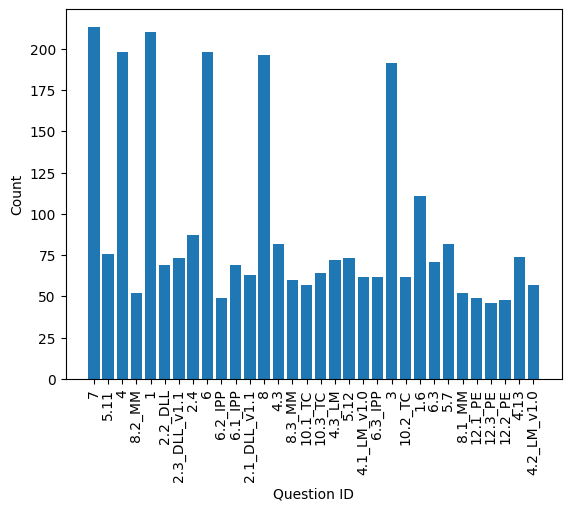

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
question_counts = Counter(q['question_id'] for q in training_data)

# Plot the histogram
plt.bar(question_counts.keys(), question_counts.values())
plt.xlabel('Question ID')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

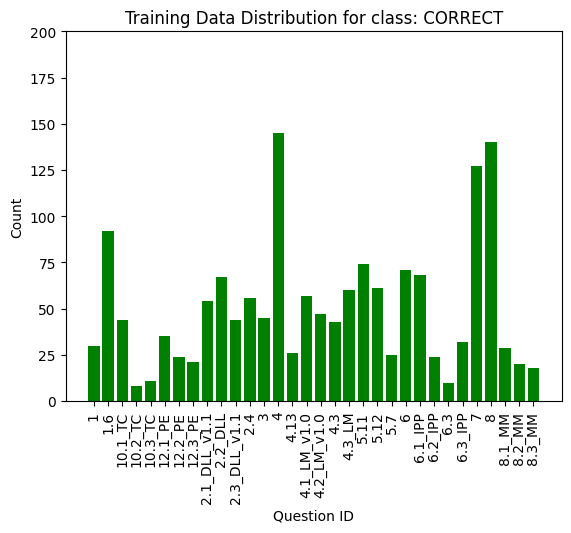

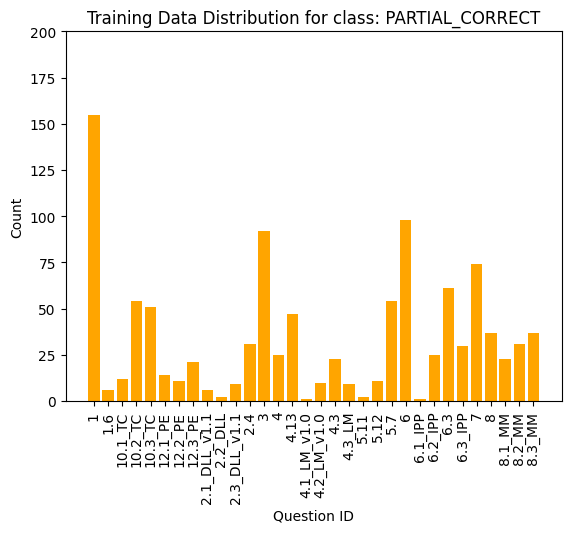

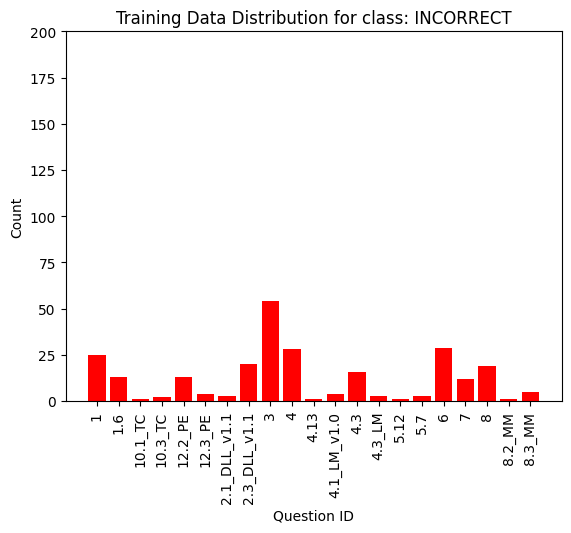

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
for l, c in zip(['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'],  ['green', 'orange', 'red']):
    question_counts = Counter(q['question_id'] for q in training_data if q['label']==l)
    question_counts = sorted(question_counts.items(), key=lambda x: x[0])
    question_counts = {k: v for k, v in question_counts}
    # Plot the histogram
    
    plt.bar(question_counts.keys(), question_counts.values(), color=c)
    plt.title('Training Data Distribution for class: ' + str(l) )
    plt.xlabel('Question ID')
    plt.xticks(rotation=90)
    plt.ylim((0,200))
    plt.ylabel('Count')
    plt.show()

In [19]:
import numpy as np
from scipy.stats import pearsonr

rubric_length = np.array([4, 3, 2, 2, 4, 2, 16, 1, 2, 5, 7, 6, 2, 18, 3, 5, 16, 2, 11, 10, 6, 2, 7, 2, 2, 2, 6, 4, 3, 6, 7, 2])
macro_f1 = np.array([0.224, 0.133, 0.167, 0.017, 0.208, 0.037, 1.000, 0.489, 0.275, 0.242, 0.052, 0.483, 0.000, 0.098, 0.484, 0.154, 0.240, 0.180, 0.156, 1.000, 0.570, 0.047, 0.400, 0.222, 0.478, 0.050, 0.393, 0.181, 0.026, 0.190, 0.228, 0.229])
weighted_f1 = np.array([0.29, 0.28, 0.63, 0.04, 0.44, 0.18, 1.00, 0.94, 0.74, 0.49, 0.17, 0.97, 0.00, 0.40, 0.97, 0.36, 0.51, 0.32, 0.58, 1.000, 0.83, 0.05, 0.50, 0.40, 0.88, 0.09, 0.44, 0.79, 0.01, 0.45, 0.38, 0.85])
acc = np.array([0.25, 0.241, 0.61, 0.019, 0.415, 0.103, 1, 0.957, 0.7, 0.5, 0.182, 0.933, 0, 0.313, 0.938, 0.375, 0.529, 0.385, 0.583, 1, 0.857, 0.1, 0.5, 0.444, 0.917, 0.071, 0.474, 0.792, 0.077, 0.412, 0.357, 0.786])


weighted_corr_coef, weighted_p_value = pearsonr(weighted_f1, rubric_length)
print("Weighted Pearson correlation coefficient:", weighted_corr_coef)
print("Weighted p-value:", weighted_p_value)

macro_corr_coef, macro_p_value = pearsonr(macro_f1, rubric_length)
print("Macro-F1 Pearson correlation coefficient:", macro_corr_coef)
print("Macro-F1 p-value:", macro_p_value)

acc_corr_coef, acc_p_value = pearsonr(acc, rubric_length)
print("Macro-F1 Pearson correlation coefficient:", acc_corr_coef)
print("Macro-F1 p-value:", acc_p_value)



Weighted Pearson correlation coefficient: 0.22150638323352811
Weighted p-value: 0.22307909103108403
Macro-F1 Pearson correlation coefficient: 0.35752229311890577
Macro-F1 p-value: 0.04454360842831703
Macro-F1 Pearson correlation coefficient: 0.20564357485299717
Macro-F1 p-value: 0.25884175059157544
